# construct SEDs for simulated galaxies in LGalaxies SAM
In this notebook I will construct SEDs for LGalaxies galaxies using their star formation and chemical enrichment history with `FSPS`

In [29]:
import os
import fsps
import pickle
import numpy as np 
import pandas as pd
from speclite import filters as specFilter
# -- astropy --
import astropy.units as U
import astropy.table as aTable
from astropy.cosmology import FlatLambdaCDM
# -- gqp_mc --
from gqp_mc import util as UT

In [2]:
# --- plotting --- 
import corner as dfm
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
dat_dir = '/global/cfs/cdirs/desi/mocks/LGal_spectra/'

In [4]:
# constants
seed = 123456789
RecycleFraction = 0.43
h = 0.673
cosmo = FlatLambdaCDM(H0=67.3 * U.km / U.s / U.Mpc, Om0=0.315)
c = 299792.458 #in km/s
t_BC = 0.03 # age of birth cloud, in Gyrs

to_ergsAcm2 = 3.846e33 * 1e-4 * 1e17 # 10^-17

In [5]:
lgal        = pd.read_csv(os.path.join(dat_dir, 'Lgal_forspectra_tojeiror_0.csv'))
sfh_times   = pd.read_csv('lgal_sfh_times.csv')

In [6]:
bgs_cut = (lgal['sdss_r'] < 20) & (lgal['z_app'] < 0.6)

In [7]:
bgs = aTable.Table.read('/global/cfs/cdirs/desi/science/gqp/provabgs.sv3.sbi.v0.fits')

g_bgs = 22.5 - 2.5 * np.log10(bgs['FLUX_G'])
r_bgs = 22.5 - 2.5 * np.log10(bgs['FLUX_R']) 
z_bgs = 22.5 - 2.5 * np.log10(bgs['FLUX_Z']) 

(0.0, 1.5)

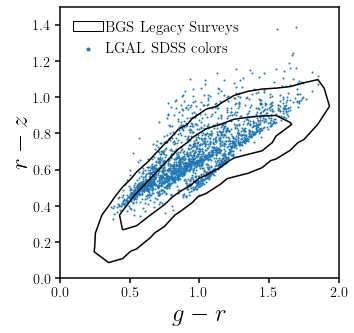

In [8]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
dfm.hist2d(g_bgs - r_bgs, r_bgs - z_bgs, color='k', levels=[0.68, 0.95], 
           range=[[-1., 3.], [-1., 3.]], bins=40, smooth=0.5,             
           plot_datapoints=False, fill_contours=False, plot_density=False, linewidth=0.5, ax=sub)
sub.fill_between([0],[0],[0], fc='none', ec='k', label='BGS Legacy Surveys') 
sub.scatter((lgal.sdss_g - lgal.sdss_r)[bgs_cut], (lgal.sdss_r - lgal.sdss_z)[bgs_cut], c='C0', s=1, label='LGAL SDSS colors')
sub.legend(loc='upper left', handletextpad=0.1, markerscale=3, fontsize=15)
sub.set_xlabel('$g-r$', fontsize=25)
sub.set_xlim(0., 2.)
sub.set_ylabel('$r-z$', fontsize=25)
sub.set_ylim(0., 1.5)

In [9]:
# initialize fsps 
ssp = fsps.StellarPopulation(
        zcontinuous=1,  # interpoalte metallicities
        sfh=0,          # ssp
        dust_type=0,
        imf_type=1)     # chabrier
# no dust attenuation
ssp.params['dust1'] = 0 # tau_BC = 0
ssp.params['dust2'] = 0 # tau_ISM = 0

# wavelength
wave_rest, _ = ssp.get_spectrum(tage=0.5, peraa=True)
dwave = np.zeros(len(wave_rest))
dwave[1:-1] = [(wave_rest[l+1] - wave_rest[l-1])/2 for l in range(1,len(wave_rest)-1)]
dwave[0] = dwave[1]
dwave[-1] = dwave[-2]

In [10]:
def get_extinction(igal):
    ''' get dust extinction
    '''
    np.random.seed(seed=igal)
    # Mathis+1983 extinction curve
    _lambda = np.array([0.091, 0.10, 0.13, 0.143, 0.18, 0.20, 0.21, 0.216, 0.23, 0.25, 0.346, 0.435, 0.55, 0.7, 0.9, 1.2, 1.8, 2.2, 2.4, 3.4, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0, 20.0, 25.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 100.0, 150.0, 200.0, 300.0, 400.0, 600.0, 800.0, 1000.0]) * 1e4 #in AA
    _Av = np.array([5.720, 4.650, 2.960, 2.700, 2.490, 2.780, 3.000, 3.120, 2.860, 2.350, 1.580, 1.320, 1.000, 0.750, 0.480, 0.280, 0.160, 0.122, 0.093, 0.038, 0.024, 0.018, 0.014, 0.013, 0.072, 0.030, 0.065, 0.062, 0.032, 0.017, 0.014, 0.012, 9.7e-3, 8.5e-3, 6.5e-3, 3.7e-3, 2.5e-3, 1.1e-3, 6.7e-4, 2.5e-4, 1.4e-4, 7.3e-5])
    _Albedo= np.array([ 0.42, 0.43, 0.45, 0.45, 0.53, 0.56, 0.56, 0.56, 0.63, 0.63, 0.71, 0.67, 0.63, 0.56, 0.50, 0.37, 0.25, 0.22, 0.15, 0.058, 0.046, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
                       0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
                       0.00, 0.00])

    #Zg = df[g].MetalsColdGas/df[g].ColdGas/0.02D
    Zg = lgal['metalsColdGas'][igal]/lgal['coldGas'][igal]/0.02
    #extinction curve from Mathis+1983
    A_Av = np.interp(wave_rest, _lambda, _Av)#[:,0]
    Albedo = np.interp(wave_rest, _lambda, _Albedo)#[:,0]
    
    fuv = (wave_rest <= 2000)
    A_Av[fuv] = A_Av[fuv] * Zg**(1.35) * (1. - Albedo[fuv])**0.5
    A_Av[~fuv] = A_Av[~fuv] * Zg**(1.60) * (1. - Albedo[~fuv])**0.5

    nh = lgal['coldGas'][igal] / (np.pi * (lgal['GasDiskRadius'][igal] * 0.94)**2 * 1.4)
    nh = nh / 3252.37;
    nh = nh * (1 + lgal['z_app'][igal])**(-1.0)

    tauISM = A_Av * nh #Eq S37 - note this is a function of wave

    cosinc = (lgal['cosInclination'][igal]).clip(0.2, None)
    sec = 1.0 / cosinc

    #compute mean tau_ISM_lambda at 5500 to get effective tau_ISM_V
    tauISM_V = np.mean(tauISM[ (wave_rest > 5450) & (wave_rest < 5550)])

    #Eq S40 for ISM
    T_ISM = (1.0 - np.exp(-tauISM*sec)) / (tauISM * sec)

    #birth cloud component
    mu = np.random.normal(0.3, 0.2)
    mu = np.min([mu, 1.0])
    mu = np.max([mu, 0.1])
    #print('mu = ' + str(mu))
    tauBC= tauISM * (1/mu - 1.0) * (wave_rest / 5500.0)**-0.7

    #compute mean tau_BC_lambda at 5500 to get effective tau_ISM_V
    tauBC_V = np.mean(tauBC[ (wave_rest > 5450) & (wave_rest < 5550)])

    #Eq S40 for BC
    T_BC = (1.0 - np.exp(-tauBC*sec)) / (tauBC * sec)
    return T_ISM, tauISM_V, T_BC, tauBC_V, cosinc

In [11]:
def rmNanInf(arr):
    arr=np.where(np.isnan(arr),0,arr)
    arr=np.where(np.isinf(arr),0,arr)
    return arr

def get_sfh(igal):
    sfh_t = np.array(sfh_times['lookbacktime'][sfh_times['snapnum'] == lgal['snapnum'][igal]] / 1.e9)
    dt = np.array(sfh_times['dt'][sfh_times['snapnum'] == lgal['snapnum'][igal]] / 1.e9)

    Nt = len(sfh_t)

    sfh_disk_gal = np.array([lgal['sfh_Diskmass_%i' % i][igal] for i in range(1,Nt+1)])
    sfh_bulge_gal = np.array([lgal['sfh_BulgeMass_%i' % i][igal] for i in range(1,Nt+1)])

    Z_bulge_gal = np.array([lgal['sfh_MetalsBulgeMass_'+str(i)][igal]/sfh_bulge_gal[i-1] for i in range(1,Nt+1)])
    Z_disk_gal = np.array([lgal['sfh_MetalsDiskMass_'+str(i)][igal]/sfh_disk_gal[i-1] for i in range(1,Nt+1)])

    Z_bulge_gal = rmNanInf(Z_bulge_gal)
    Z_disk_gal = rmNanInf(Z_disk_gal)

    return dt, sfh_t, sfh_disk_gal* 1e10 / (h*(1-RecycleFraction)), sfh_bulge_gal* 1e10 / (h*(1-RecycleFraction)), Z_disk_gal, Z_bulge_gal

In [12]:
def get_rest_frame_spectrum(igal, apply_vdisp=True):
    ''' get rest-frame spectrum using python-fsps package
    '''
    print()
    print('------- %i --------' % igal)
    dt, sfh_t, sfh_disk, sfh_bulge, z_disk, z_bulge = get_sfh(igal)

    #separate disk into brith cloud and "old" componenets
    #these will get different attenuation

    sfh_disk_BC = np.zeros(len(sfh_disk))
    sfh_disk_BC[ np.where(sfh_t <= t_BC)[0]] = sfh_disk[np.where(sfh_t <= t_BC)[0]]

    sfh_disk_old = np.zeros(len(sfh_disk))
    sfh_disk_old[ np.where(sfh_t > t_BC)[0]] = sfh_disk[np.where(sfh_t > t_BC)[0]]


    # loop through SFH and add up all the flux from every SSP components
    flux_bulge_rec = np.zeros(len(wave_rest))
    flux_disk_BC_rec = np.zeros(len(wave_rest))
    flux_disk_old_rec = np.zeros(len(wave_rest))

    for i in range(len(sfh_t)):
        if sfh_bulge[i] > 0.:
            ssp.params['logzsol'] = np.log10(z_bulge[i]/0.0190) # log(Z/Zsun)
            _, _flux = ssp.get_spectrum(tage=sfh_t[i], peraa=True) # Lsun/AA
            flux_bulge_rec += _flux * sfh_bulge[i]

        if sfh_disk_BC[i] > 0.:
            ssp.params['logzsol'] = np.log10(z_disk[i]/0.0190) # log(Z/Zsun)
            _, _flux = ssp.get_spectrum(tage=sfh_t[i], peraa=True) # Lsun/AA
            flux_disk_BC_rec += _flux * sfh_disk_BC[i]

        if sfh_disk_old[i] > 0.:
            ssp.params['logzsol'] = np.log10(z_disk[i]/0.0190) # log(Z/Zsun)
            _, _flux = ssp.get_spectrum(tage=sfh_t[i], peraa=True) # Lsun/AA
            flux_disk_old_rec += _flux * sfh_disk_old[i]

    #total reconstructed galaxy flux, before velocity dispersion and dust attenuation
    flux_disk_rec = flux_disk_old_rec + flux_disk_BC_rec
    flux_total_rec = flux_bulge_rec + flux_disk_rec

    #Velocity dispersion. Empirical relation based on Table 1 of Zahid et al. 2016 for bulge. Fixed for disk just now.
    M_bulge = np.sum(sfh_bulge)
    M_disk_BC = np.sum(sfh_disk_BC)
    M_disk_old = np.sum(sfh_disk_old)

    print('  M_bulge = %.2e, M_disk_BC = %.2e, M_disk_old = %.2e' % (M_bulge, M_disk_BC, M_disk_old))
    
    if apply_vdisp & (M_bulge > 0):
        vdisp_bulge = get_vdisp(M_bulge)
        flux_bulge_vd = np.array(apply_vd_pix(flux_bulge_rec, vdisp_bulge))
        print('  bulge vdisp = %.2f km/s' % vdisp_bulge)
    else:
        flux_bulge_vd = flux_bulge_rec
        vdisp_bulge=0

    if apply_vdisp & (M_disk_BC > 0):
        vdisp_disk = 50.
        flux_disk_BC_vd = np.array(apply_vd_pix(flux_disk_BC_rec, vdisp_disk))
        print('  disk BC vdisp = %.2f km/s' % vdisp_disk)
    else:
        flux_disk_BC_vd = flux_disk_BC_rec
        vdisp_disk=0

    if apply_vdisp & (M_disk_old > 0):
        vdisp_disk = 50.
        flux_disk_old_vd = np.array(apply_vd_pix(flux_disk_old_rec, vdisp_disk))
        print('  disk BC vdisp = %.2f km/s' % vdisp_disk)
    else:
        flux_disk_old_vd = flux_disk_old_rec
        vdisp_disk = 0
        
    #total galaxy flux with applied velocity dispersion, no dust
    flux_total_vd = flux_bulge_vd + flux_disk_BC_vd + flux_disk_old_vd

    #dust attenuation
    T_ISM, tauISM, T_BC, tauBC, cosi = get_extinction(igal)
    flux_final = flux_bulge_vd + flux_disk_old_vd * T_ISM + flux_disk_BC_vd * T_ISM * T_BC
    
    return flux_total_vd, flux_final, tauISM, tauBC, cosi, vdisp_bulge, vdisp_disk
    
    
def get_vdisp(M_bulge):
    ''' Empirical relation based on Table 1 of Zahid et al. 2016 for bulge.
    '''
    Mb = 10**10.26
    sigb = 10**2.073
    alpha1 = 0.403
    alpha2 = 0.293

    if M_bulge <= Mb:
        return sigb * (M_bulge/Mb)**alpha1
    else:
        return sigb * (M_bulge/Mb)**alpha2
    
def apply_vd_pix(flux, vdisp):
    #velocity dispersion in pixels
    vdisp_pix = vdisp / c * wave_rest / dwave
    conv_spec = gaussian_filter1d(flux, vdisp_pix)
    return conv_spec

def gaussian_filter1d(spec, sig):
    """
    FROM PPXF UTILS
    Convolve a spectrum by a Gaussian with different sigma for every pixel.
    If all sigma are the same this routine produces the same output as
    scipy.ndimage.gaussian_filter1d, except for the border treatment.
    Here the first/last p pixels are filled with zeros.
    When creating a template library for SDSS data, this implementation
    is 60x faster than a naive for loop over pixels.

    :param spec: vector with the spectrum to convolve
    :param sig: vector of sigma values (in pixels) for every pixel
    :return: spec convolved with a Gaussian with dispersion sig

    """
    sig = sig.clip(0.01)  # forces zero sigmas to have 0.01 pixels
    p = int(np.ceil(np.max(3*sig)))
    m = 2*p + 1  # kernel size
    x2 = np.linspace(-p, p, m)**2

    n = spec.size
    a = np.zeros((m, n))
    for j in range(m):   # Loop over the small size of the kernel
        a[j, p:-p] = spec[j:n-m+j+1]

    gau = np.exp(-x2[:, None]/(2*sig**2))
    gau /= np.sum(gau, 0)[None, :]  # Normalize kernel

    conv_spectrum = np.sum(a*gau, 0)

    return conv_spectrum

In [13]:
def get_observed_frame_spectrum(igal, apply_vdisp=True):
    ''' get observed-frame SED of igal-th galaxy of Lgal
    '''
    L_nodust, L, tauISM, tauBC, cosi, vdisp_bulge, vdisp_disk = get_rest_frame_spectrum(igal, apply_vdisp=apply_vdisp) #rest-frame luminosity
    print('  z = %f' % lgal['z_app'][igal])

    #from luminosity to flux
    L_nodust = L_nodust*U.Lsun/U.AA
    L_dust = L*U.Lsun/U.AA
    dL = cosmo.luminosity_distance(lgal['z_app'][igal])
    dL = dL.to(U.m)

    F_dust_nonoise = L_dust / (4*np.pi*dL**2*(1+lgal['z_app'][igal])) #to flux (Lsun/A/m^2)
    F_nodust_nonoise = L_nodust / (4*np.pi*dL**2*(1+lgal['z_app'][igal]))
    
    wave_obs = wave_rest * (1. + lgal['z_app'][igal]) * U.AA

    return wave_obs, F_dust_nonoise, F_nodust_nonoise, tauISM, tauBC, cosi, vdisp_bulge, vdisp_disk


------- 0 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


  M_bulge = 0.00e+00, M_disk_BC = 2.38e+06, M_disk_old = 2.64e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088248


(1000.0, 10000.0)

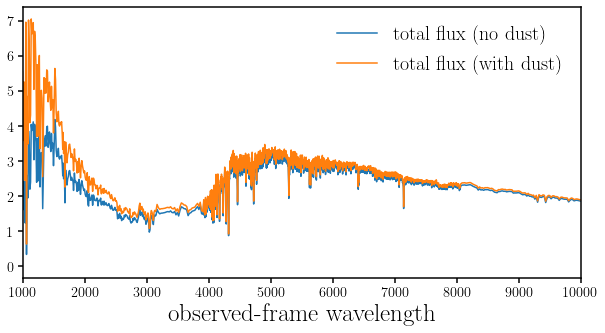

In [14]:
w, ft, ff, _, _, _, _, _ = get_observed_frame_spectrum(0)
fig = plt.figure(figsize=(10, 5))
sub = fig.add_subplot(111)
sub.plot(w, ft.to(1e-17*U.erg/U.s/U.AA/U.cm**2), label='total flux (no dust)')
sub.plot(w, ff.to(1e-17*U.erg/U.s/U.AA/U.cm**2), label='total flux (with dust)')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('observed-frame wavelength', fontsize=25)
sub.set_xlim(1e3, 1e4)

In [15]:
# load DECAM g, r, z and WISE W1-4
filters_desi = specFilter.load_filters('decam2014-g', 'decam2014-r', 'decam2014-z', 'wise2010-W1', 'wise2010-W2', 'wise2010-W3', 'wise2010-W4')
filters_sdss = specFilter.load_filters('sdss2010-*')

def get_mags_desi(w, f): 
    return 22.5 - 2.5 *np.log10(1e9* np.array(list((filters_desi.get_ab_maggies(np.atleast_2d(f), w)).as_array()[0])))
def get_mags_sdss(w, f): 
    return 22.5 - 2.5 *np.log10(1e9* np.array(list((filters_sdss.get_ab_maggies(np.atleast_2d(f), w)).as_array()[0])))

In [16]:
dts, sfh_ts, sfh_disks, sfh_bulges, Z_disks, Z_bulges = [], [], [], [], [], []
redshifts, tauISMs, tauBCs, cosis, vd_disks, vd_bulges = [], [], [], [], [], []
igals, waves_obs, fluxes_nodust, fluxes_dust = [], [], [], [] 

for igal in np.arange(lgal.shape[0])[bgs_cut]: 
    #SFHs
    dt, sfh_t, sfh_disk, sfh_bulge, Z_disk, Z_bulge = get_sfh(igal)
    # calculate observed-frame fluxes
    wave_obs, F_dust_nonoise, F_nodust_nonoise, tauISM, tauBC, cosi, vdisp_bulge, vdisp_disk = get_observed_frame_spectrum(igal, apply_vdisp=True)

    igals.append(igal)
    dts.append(dt)
    sfh_ts.append(sfh_t)
    sfh_disks.append(sfh_disk)
    sfh_bulges.append(sfh_bulge)
    Z_disks.append(Z_disk)
    Z_bulges.append(Z_bulge)
    redshifts.append(lgal['z_app'][igal])
    tauISMs.append(tauISM)
    tauBCs.append(tauBC)
    cosis.append(cosi)
    vd_disks.append(vdisp_disk)
    vd_bulges.append(vdisp_bulge)

    waves_obs.append(wave_obs)
    fluxes_nodust.append(F_nodust_nonoise)
    fluxes_dust.append(F_dust_nonoise)

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app



------- 1 --------
  M_bulge = 8.22e+09, M_disk_BC = 1.62e+07, M_disk_old = 8.48e+10
  bulge vdisp = 85.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088214

------- 2 --------
  M_bulge = 5.30e+08, M_disk_BC = 3.00e+04, M_disk_old = 7.74e+09
  bulge vdisp = 28.45 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088879

------- 3 --------
  M_bulge = 4.92e+08, M_disk_BC = 5.14e+05, M_disk_old = 7.68e+10
  bulge vdisp = 27.60 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087156

------- 4 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 0.00e+00, M_disk_BC = 1.84e+04, M_disk_old = 7.94e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.086805

------- 5 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.23e+05, M_disk_old = 3.70e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.086828

------- 6 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.44e+07, M_disk_old = 5.94e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.033833

------- 7 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.80e+07, M_disk_old = 2.23e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.039712

------- 8 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.97e+07, M_disk_old = 2.19e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.036557

------- 9 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.73e+07, M_disk_old = 7.59e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.038830

------- 10 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.13e+07, M

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 1.56e+09, M_disk_BC = 5.08e+07, M_disk_old = 1.45e+10
  bulge vdisp = 43.97 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.038688

------- 12 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.69e+07, M_disk_old = 1.23e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088335

------- 13 --------
  M_bulge = 4.70e+08, M_disk_BC = 8.82e+07, M_disk_old = 3.10e+10
  bulge vdisp = 27.10 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087107

------- 14 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.85e+07, M_disk_old = 2.36e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088412

------- 15 --------
  M_bulge = 5.00e+09, M_disk_BC = 1.23e+07, M_disk_old = 4.36e+08
  bulge vdisp = 70.27 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088753

------- 16 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.16e+05, M_disk_old = 6.13e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 5.06e+10, M_disk_BC = 0.00e+00, M_disk_old = 3.26e+07
  bulge vdisp = 159.60 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087435

------- 19 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


  M_bulge = 5.55e+06, M_disk_BC = 7.35e+07, M_disk_old = 1.87e+10
  bulge vdisp = 4.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087259

------- 20 --------
  M_bulge = 1.06e+09, M_disk_BC = 2.66e+07, M_disk_old = 2.31e+09
  bulge vdisp = 37.62 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087524

------- 21 --------
  M_bulge = 5.98e+09, M_disk_BC = 1.51e+08, M_disk_old = 3.55e+10
  bulge vdisp = 75.55 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087663

------- 22 --------
  M_bulge = 5.09e+09, M_disk_BC = 1.53e+07, M_disk_old = 1.41e+08
  bulge vdisp = 70.82 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.086647

------- 23 --------
  M_bulge = 4.16e+09, M_disk_BC = 3.11e+08, M_disk_old = 1.31e+11
  bulge vdisp = 65.29 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087213

------- 24 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.92e+09, M_disk_BC = 1.02e+05, M_disk_old = 3.87e+10
  bulge vdisp = 56.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.086839

------- 25 --------
  M_bulge = 1.02e+09, M_disk_BC = 1.31e+07, M_disk_old = 4.74e+10
  bulge vdisp = 36.99 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.077358

------- 26 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.07e+07, M_disk_old = 1.96e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.077047

------- 27 --------
  M_bulge = 2.78e+09, M_disk_BC = 2.50e+07, M_disk_old = 4.19e+10
  bulge vdisp = 55.51 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.077281

------- 28 --------
  M_bulge = 1.58e+09, M_disk_BC = 0.00e+00, M_disk_old = 6.42e+10
  bulge vdisp = 44.19 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.086360

------- 29 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.70e+07, M_disk_old = 6.28e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 3.12e+08, M_disk_BC = 1.60e+08, M_disk_old = 9.44e+10
  bulge vdisp = 22.99 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088598

------- 31 --------
  M_bulge = 6.97e+09, M_disk_BC = 1.16e+06, M_disk_old = 2.09e+09
  bulge vdisp = 80.35 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088232

------- 32 --------
  M_bulge = 9.83e+07, M_disk_BC = 5.49e+06, M_disk_old = 3.41e+09
  bulge vdisp = 14.43 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088136

------- 33 --------
  M_bulge = 1.64e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.51e+11
  bulge vdisp = 113.47 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.086519

------- 34 --------
  M_bulge = 1.78e+09, M_disk_BC = 0.00e+00, M_disk_old = 2.89e+10
  bulge vdisp = 46.34 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087610

------- 35 --------
  M_bulge = 1.14e+08, M_disk_BC = 8.00e+00, M_disk_old = 8.48e+09
  bulge vdisp = 15.34 km/s
  disk BC vdisp = 50.00 km/s


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 37 --------
  M_bulge = 7.68e+07, M_disk_BC = 4.25e+07, M_disk_old = 1.05e+10
  bulge vdisp = 13.06 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.086188

------- 38 --------
  M_bulge = 3.82e+09, M_disk_BC = 5.50e+06, M_disk_old = 2.57e+10
  bulge vdisp = 63.09 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088295

------- 39 --------
  M_bulge = 3.98e+09, M_disk_BC = 1.40e+08, M_disk_old = 1.24e+10
  bulge vdisp = 64.11 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087569

------- 40 --------
  M_bulge = 1.91e+09, M_disk_BC = 6.55e+06, M_disk_old = 1.22e+09
  bulge vdisp = 47.69 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087883

------- 41 --------
  M_bulge = 9.44e+08, M_disk_BC = 1.08e+08, M_disk_old = 2.87e+10
  bulge vdisp = 35.90 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088773

------- 42 --------
  M_bulge = 1.51e+08, M_disk_BC = 1.92e+08, 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 5.19e+09, M_disk_BC = 2.57e+08, M_disk_old = 8.74e+10
  bulge vdisp = 71.38 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.070012

------- 44 --------
  M_bulge = 2.30e+09, M_disk_BC = 1.79e+08, M_disk_old = 2.98e+10
  bulge vdisp = 51.45 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088486

------- 46 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.87e+07, M_disk_old = 4.93e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088399

------- 47 --------
  M_bulge = 5.33e+08, M_disk_BC = 5.83e+07, M_disk_old = 3.04e+10
  bulge vdisp = 28.52 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.077287

------- 48 --------
  M_bulge = 5.07e+07, M_disk_BC = 1.24e+08, M_disk_old = 3.27e+10
  bulge vdisp = 11.05 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.086775

------- 49 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.44e+07, M_disk_old = 5.43e+09
  disk BC vdisp = 50.00 km

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 1.16e+08, M_disk_BC = 9.56e+07, M_disk_old = 2.14e+10
  bulge vdisp = 15.42 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.077070

------- 51 --------
  M_bulge = 1.00e+09, M_disk_BC = 8.68e+07, M_disk_old = 2.72e+10
  bulge vdisp = 36.80 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.086912

------- 52 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.67e+07, M_disk_old = 5.82e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.077264

------- 53 --------
  M_bulge = 9.44e+07, M_disk_BC = 5.85e+07, M_disk_old = 1.07e+10
  bulge vdisp = 14.19 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087054

------- 54 --------
  M_bulge = 7.67e+07, M_disk_BC = 4.78e+07, M_disk_old = 9.63e+09
  bulge vdisp = 13.05 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.068074

------- 55 --------
  M_bulge = 1.02e+08, M_disk_BC = 4.21e+07, M_disk_old = 5.87e+09
  bulge vdisp = 14.62 km/s

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 0.00e+00, M_disk_BC = 3.59e+07, M_disk_old = 7.85e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088149

------- 57 --------
  M_bulge = 1.85e+08, M_disk_BC = 4.37e+07, M_disk_old = 9.00e+09
  bulge vdisp = 18.62 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088110

------- 58 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


  M_bulge = 0.00e+00, M_disk_BC = 3.11e+07, M_disk_old = 3.18e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087437

------- 59 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.50e+07, M_disk_old = 4.65e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087755

------- 60 --------
  M_bulge = 1.74e+09, M_disk_BC = 0.00e+00, M_disk_old = 7.53e+10
  bulge vdisp = 45.97 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.065761

------- 66 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.58e+07, M_disk_old = 1.11e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.039618

------- 67 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.70e+07, M_disk_old = 5.07e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.035539

------- 68 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.46e+07, M_disk_old = 5.18e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.034036

------- 69 --------
  M_bulge = 1.53e+09, M_disk_BC = 2.05e+07

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.033940

------- 70 --------
  M_bulge = 4.15e+07, M_disk_BC = 1.87e+07, M_disk_old = 4.06e+09
  bulge vdisp = 10.19 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.039035

------- 71 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.16e+07, M_disk_old = 3.97e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.032013

------- 72 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.93e+07, M_disk_old = 4.56e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.066113

------- 73 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.40e+07, M_disk_old = 7.31e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.067105

------- 138 --------
  M_bulge = 1.14e+09, M_disk_BC = 1.15e+06, M_disk_old = 7.81e+10
  bulge vdisp = 38.76 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.045749


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/


------- 139 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.14e+03, M_disk_old = 1.19e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.046200

------- 140 --------
  M_bulge = 3.07e+09, M_disk_BC = 8.18e+07, M_disk_old = 2.38e+10
  bulge vdisp = 57.71 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.052667

------- 141 --------
  M_bulge = 3.77e+09, M_disk_BC = 6.87e+07, M_disk_old = 1.84e+10
  bulge vdisp = 62.71 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.045747

------- 142 --------
  M_bulge = 1.43e+09, M_disk_BC = 1.50e+07, M_disk_old = 3.16e+09
  bulge vdisp = 42.39 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.052674

------- 143 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.40e+07, M_disk_old = 6.10e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.043592

------- 174 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 1.95e+09, M_disk_BC = 1.51e+07, M_disk_old = 2.05e+09
  bulge vdisp = 48.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087553

------- 175 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.77e+07, M_disk_old = 4.64e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087521

------- 176 --------
  M_bulge = 7.56e+08, M_disk_BC = 1.52e+07, M_disk_old = 1.96e+09
  bulge vdisp = 32.83 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088072

------- 177 --------
  M_bulge = 1.29e+09, M_disk_BC = 1.03e+07, M_disk_old = 1.79e+09
  bulge vdisp = 40.71 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088776

------- 178 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.66e+06, M_disk_old = 2.67e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088549

------- 179 --------
  M_bulge = 1.88e+09, M_disk_BC = 0.00e+00, M_disk_old = 4.38e+10
  bulge vdisp = 47.42 km/s
  disk BC vdisp = 50.

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 1.66e+07, M_disk_old = 2.97e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.045822

------- 296 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.44e+07, M_disk_old = 5.66e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.046169

------- 297 --------
  M_bulge = 1.17e+09, M_disk_BC = 1.59e+07, M_disk_old = 2.97e+09
  bulge vdisp = 39.15 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.045973

------- 298 --------
  M_bulge = 6.45e+10, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 171.41 km/s
  z = 0.066030

------- 299 --------
  M_bulge = 8.25e+09, M_disk_BC = 7.44e+04, M_disk_old = 1.77e+10
  bulge vdisp = 86.03 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.066244

------- 468 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.60e+08, M_disk_old = 2.63e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.066052

------- 469 --------
  M_bulge 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.13e+08, M_disk_BC = 9.47e+07, M_disk_old = 1.72e+10
  bulge vdisp = 19.70 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.065320

------- 471 --------
  M_bulge = 7.77e+08, M_disk_BC = 1.29e+07, M_disk_old = 2.75e+09
  bulge vdisp = 33.20 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.066096

------- 486 --------
  M_bulge = 1.31e+09, M_disk_BC = 1.74e+07, M_disk_old = 2.81e+10
  bulge vdisp = 41.00 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087346

------- 487 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.87e+00, M_disk_old = 1.11e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087086

------- 498 --------
  M_bulge = 4.87e+10, M_disk_BC = 1.57e+06, M_disk_old = 2.61e+08
  bulge vdisp = 157.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.067412

------- 624 --------
  M_bulge = 1.84e+08, M_disk_BC = 3.33e+07, M_disk_old = 6.66e+10
  bulge vdisp = 18.5

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 9.01e+08, M_disk_BC = 5.63e+07, M_disk_old = 1.16e+10
  bulge vdisp = 35.24 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.086808

------- 626 --------
  M_bulge = 9.94e+08, M_disk_BC = 2.28e+07, M_disk_old = 5.74e+09
  bulge vdisp = 36.66 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.087822

------- 627 --------
  M_bulge = 9.31e+10, M_disk_BC = 0.00e+00, M_disk_old = 5.25e+08
  bulge vdisp = 190.87 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.228443

------- 634 --------
  M_bulge = 9.76e+07, M_disk_BC = 6.11e+07, M_disk_old = 2.45e+10
  bulge vdisp = 14.39 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.210520

------- 635 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.48e+07, M_disk_old = 1.19e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.210264

------- 645 --------
  M_bulge = 2.97e+10, M_disk_BC = 1.10e+06, M_disk_old = 3.00e+11
  bulge vdisp = 136.53 km/s
  disk BC vdisp = 50.

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.19e+11, M_disk_BC = 0.00e+00, M_disk_old = 4.82e+07
  bulge vdisp = 273.82 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205399

------- 666 --------
  M_bulge = 4.33e+10, M_disk_BC = 2.28e+08, M_disk_old = 1.39e+11
  bulge vdisp = 152.55 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.226006

------- 668 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.16e+08, M_disk_old = 1.08e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.227334

------- 686 --------
  M_bulge = 1.64e+11, M_disk_BC = 1.77e+07, M_disk_old = 1.82e+10
  bulge vdisp = 225.12 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205189

------- 717 --------
  M_bulge = 3.16e+11, M_disk_BC = 0.00e+00, M_disk_old = 6.09e+09
  bulge vdisp = 272.97 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206363

------- 873 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 3.43e+09, M_disk_BC = 7.62e+04, M_disk_old = 7.56e+10
  bulge vdisp = 60.38 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.257836

------- 874 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.07e+08, M_disk_old = 2.75e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.258579

------- 894 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.17e+07, M_disk_old = 1.19e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.275345

------- 896 --------
  M_bulge = 1.51e+09, M_disk_BC = 6.73e+07, M_disk_old = 2.87e+10
  bulge vdisp = 43.37 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.275820

------- 897 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.04e+08, M_disk_old = 3.19e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.275862

------- 898 --------
  M_bulge = 1.90e+09, M_disk_BC = 6.32e+07, M_disk_old = 2.12e+10
  bulge vdisp = 47.57 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 5

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  z = 0.276149

------- 918 --------
  M_bulge = 2.14e+10, M_disk_BC = 3.48e+07, M_disk_old = 1.01e+11
  bulge vdisp = 124.00 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.258041

------- 972 --------
  M_bulge = 1.26e+10, M_disk_BC = 4.32e+07, M_disk_old = 1.71e+11
  bulge vdisp = 102.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206238

------- 973 --------
  M_bulge = 3.44e+10, M_disk_BC = 2.78e+06, M_disk_old = 9.98e+10
  bulge vdisp = 142.60 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.204953

------- 977 --------
  M_bulge = 1.31e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 210.95 km/s
  z = 0.205599

------- 985 --------
  M_bulge = 9.03e+07, M_disk_BC = 1.17e+07, M_disk_old = 3.65e+10
  bulge vdisp = 13.94 km/s
  disk BC vdisp = 50.00 km/s


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  disk BC vdisp = 50.00 km/s
  z = 0.211461

------- 988 --------
  M_bulge = 1.46e+08, M_disk_BC = 1.86e+07, M_disk_old = 4.64e+10
  bulge vdisp = 16.94 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.215711

------- 1020 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.99e+08, M_disk_old = 2.53e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.220414

------- 1022 --------
  M_bulge = 1.29e+11, M_disk_BC = 3.90e+08, M_disk_old = 1.16e+11
  bulge vdisp = 210.23 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.212588

------- 1023 --------
  M_bulge = 2.01e+07, M_disk_BC = 1.76e+08, M_disk_old = 6.01e+10
  bulge vdisp = 7.62 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.228941

------- 1025 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.62e+09, M_disk_BC = 1.28e+08, M_disk_old = 4.31e+10
  bulge vdisp = 44.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.226058

------- 1074 --------
  M_bulge = 3.86e+09, M_disk_BC = 0.00e+00, M_disk_old = 7.12e+10
  bulge vdisp = 63.36 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208907

------- 1078 --------
  M_bulge = 7.45e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.54e+08
  bulge vdisp = 178.77 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209564

------- 1089 --------
  M_bulge = 1.44e+09, M_disk_BC = 4.82e+05, M_disk_old = 1.11e+11
  bulge vdisp = 42.58 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.257573

------- 1149 --------
  M_bulge = 6.54e+10, M_disk_BC = 1.30e+08, M_disk_old = 2.06e+11
  bulge vdisp = 172.09 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206153

------- 1151 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 1.26e+10, M_disk_BC = 2.31e+06, M_disk_old = 8.39e+10
  bulge vdisp = 102.15 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205118

------- 1171 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.90e+07, M_disk_old = 1.73e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.264282

------- 1219 --------
  M_bulge = 6.94e+07, M_disk_BC = 3.67e+07, M_disk_old = 1.20e+10
  bulge vdisp = 12.54 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.225890

------- 1221 --------
  M_bulge = 2.00e+10, M_disk_BC = 5.29e+04, M_disk_old = 8.56e+10
  bulge vdisp = 121.66 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.227354

------- 1222 --------
  M_bulge = 3.91e+10, M_disk_BC = 2.23e+06, M_disk_old = 2.44e+07
  bulge vdisp = 148.00 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.228153

------- 1254 --------
  M_bulge = 2.39e+09, M_disk_BC = 2.90e+07, M_disk_old = 5.22e+10
  bulge vdisp

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206303

------- 1256 --------
  M_bulge = 4.25e+09, M_disk_BC = 1.33e+04, M_disk_old = 1.07e+11
  bulge vdisp = 65.86 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206359

------- 1265 --------
  M_bulge = 1.00e+09, M_disk_BC = 4.63e+07, M_disk_old = 2.04e+10
  bulge vdisp = 36.81 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.246362

------- 1327 --------
  M_bulge = 2.51e+08, M_disk_BC = 1.29e+08, M_disk_old = 4.86e+10
  bulge vdisp = 21.05 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.217584

------- 1331 --------
  M_bulge = 1.72e+10, M_disk_BC = 1.41e+08, M_disk_old = 4.40e+10
  bulge vdisp = 115.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.217647

------- 1354 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.10e+07, M_disk_old = 1.03e+10


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234182

------- 1380 --------
  M_bulge = 2.00e+11, M_disk_BC = 0.00e+00, M_disk_old = 7.69e+06
  bulge vdisp = 238.76 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205672

------- 1383 --------
  M_bulge = 1.59e+09, M_disk_BC = 2.13e+07, M_disk_old = 1.19e+10
  bulge vdisp = 44.27 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206763

------- 1392 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.38e+07, M_disk_old = 1.14e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.210865

------- 1394 --------
  M_bulge = 1.77e+09, M_disk_BC = 4.76e+06, M_disk_old = 4.06e+10
  bulge vdisp = 46.21 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205520

------- 1410 --------
  M_bulge = 5.12e+08, M_disk_BC = 3.23e+07, M_disk_old = 6.21e+09
  bulge vdisp = 28.06 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208425

------- 1414 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.01e+08, M_disk_BC = 2.13e+08, M_disk_old = 6.99e+10
  bulge vdisp = 19.23 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205862

------- 1440 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.35e+08, M_disk_old = 3.90e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205549

------- 1442 --------
  M_bulge = 2.43e+09, M_disk_BC = 0.00e+00, M_disk_old = 4.67e+10
  bulge vdisp = 52.57 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205799

------- 1445 --------
  M_bulge = 1.19e+08, M_disk_BC = 3.63e+07, M_disk_old = 6.37e+09
  bulge vdisp = 15.58 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206388

------- 1453 --------
  M_bulge = 5.56e+10, M_disk_BC = 3.51e+08, M_disk_old = 1.53e+11
  bulge vdisp = 164.09 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240375

------- 1454 --------
  M_bulge = 2.29e+08, M_disk_BC = 6.24e+07, M_disk_old = 3.08e+10
  bulge vdisp = 20.31 km/s
  disk BC vdisp =

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 1477 --------
  M_bulge = 1.34e+08, M_disk_BC = 3.02e+07, M_disk_old = 8.59e+09
  bulge vdisp = 16.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.203042

------- 1481 --------
  M_bulge = 2.90e+09, M_disk_BC = 4.93e+04, M_disk_old = 3.33e+10
  bulge vdisp = 56.46 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205014

------- 1500 --------
  M_bulge = 1.42e+09, M_disk_BC = 7.84e+06, M_disk_old = 6.02e+10
  bulge vdisp = 42.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.207442

------- 1501 --------
  M_bulge = 5.15e+09, M_disk_BC = 1.10e+08, M_disk_old = 6.45e+10
  bulge vdisp = 71.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.225600

------- 1503 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.08e+07, M_disk_old = 7.82e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209126

------- 1504 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 6.51e+08, M_disk_BC = 5.39e+07, M_disk_old = 2.15e+10
  bulge vdisp = 30.90 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.229218

------- 1530 --------
  M_bulge = 4.41e+11, M_disk_BC = 1.14e+08, M_disk_old = 1.60e+09
  bulge vdisp = 301.06 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254385

------- 1552 --------
  M_bulge = 5.56e+09, M_disk_BC = 8.19e+03, M_disk_old = 6.35e+10
  bulge vdisp = 73.35 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205783

------- 1553 --------
  M_bulge = 4.81e+08, M_disk_BC = 7.15e+07, M_disk_old = 7.05e+10
  bulge vdisp = 27.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206892

------- 1614 --------
  M_bulge = 3.22e+08, M_disk_BC = 1.49e+07, M_disk_old = 1.78e+10
  bulge vdisp = 23.27 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206496

------- 1615 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.86e+08, M_disk_BC = 4.66e+07, M_disk_old = 6.37e+10
  bulge vdisp = 25.05 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205921

------- 1616 --------
  M_bulge = 8.78e+07, M_disk_BC = 6.23e+07, M_disk_old = 2.27e+10
  bulge vdisp = 13.78 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206079

------- 1618 --------
  M_bulge = 2.56e+08, M_disk_BC = 1.94e+08, M_disk_old = 8.41e+10
  bulge vdisp = 21.23 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206045

------- 1619 --------
  M_bulge = 3.90e+09, M_disk_BC = 2.62e+08, M_disk_old = 1.21e+11
  bulge vdisp = 63.61 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205813

------- 1644 --------
  M_bulge = 3.83e+09, M_disk_BC = 1.30e+07, M_disk_old = 3.92e+10
  bulge vdisp = 63.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.211892

------- 1647 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 8.71e+09, M_disk_BC = 1.51e+08, M_disk_old = 7.74e+10
  bulge vdisp = 87.91 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.218332

------- 1649 --------
  M_bulge = 1.81e+10, M_disk_BC = 2.30e+08, M_disk_old = 4.41e+10
  bulge vdisp = 117.99 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.229107

------- 1651 --------
  M_bulge = 8.36e+07, M_disk_BC = 5.60e+07, M_disk_old = 1.01e+10
  bulge vdisp = 13.52 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206668

------- 1654 --------
  M_bulge = 2.25e+08, M_disk_BC = 8.65e+07, M_disk_old = 3.19e+10
  bulge vdisp = 20.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.230003

------- 1698 --------
  M_bulge = 3.71e+08, M_disk_BC = 3.55e+08, M_disk_old = 2.54e+11
  bulge vdisp = 24.63 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209400

------- 1700 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.01e+08, M_disk_BC = 7.25e+07, M_disk_old = 3.96e+10
  bulge vdisp = 22.66 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.210695

------- 1701 --------
  M_bulge = 6.84e+07, M_disk_BC = 5.00e+07, M_disk_old = 2.15e+10
  bulge vdisp = 12.47 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.210297

------- 1702 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.17e+08, M_disk_old = 1.18e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.210028

------- 1703 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.45e+07, M_disk_old = 1.79e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.210309

------- 1789 --------
  M_bulge = 2.97e+08, M_disk_BC = 2.80e+07, M_disk_old = 2.12e+10
  bulge vdisp = 22.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206497

------- 1792 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.20e+08, M_disk_old = 7.85e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.34e+08, M_disk_BC = 8.16e+07, M_disk_old = 2.97e+10
  bulge vdisp = 20.46 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.207021

------- 1802 --------
  M_bulge = 1.23e+08, M_disk_BC = 5.19e+07, M_disk_old = 3.07e+10
  bulge vdisp = 15.81 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205912

------- 1803 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.55e+07, M_disk_old = 1.07e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206072

------- 1805 --------
  M_bulge = 1.66e+08, M_disk_BC = 6.07e+07, M_disk_old = 1.40e+10
  bulge vdisp = 17.83 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206143

------- 1807 --------
  M_bulge = 2.58e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.15e+11
  bulge vdisp = 131.10 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.264486

------- 1811 --------
  M_bulge = 6.09e+09, M_disk_BC = 1.33e+08, M_disk_old = 3.81e+10
  bulge vdisp = 76.13 km/s
  disk BC vdisp =

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 8.84e+10, M_disk_BC = 7.98e+05, M_disk_old = 3.00e+08
  bulge vdisp = 187.99 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.207256

------- 1883 --------
  M_bulge = 3.37e+09, M_disk_BC = 1.12e+08, M_disk_old = 5.69e+10
  bulge vdisp = 59.98 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206955

------- 1892 --------
  M_bulge = 5.28e+07, M_disk_BC = 1.50e+07, M_disk_old = 2.69e+11
  bulge vdisp = 11.23 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.256040

------- 1893 --------
  M_bulge = 3.22e+08, M_disk_BC = 2.57e+07, M_disk_old = 1.09e+11
  bulge vdisp = 23.27 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.259008

------- 1903 --------
  M_bulge = 8.96e+09, M_disk_BC = 6.44e+07, M_disk_old = 2.17e+10
  bulge vdisp = 88.94 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206731

------- 1905 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.74e+09, M_disk_BC = 2.51e+07, M_disk_old = 8.04e+09
  bulge vdisp = 45.90 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205034

------- 1915 --------
  M_bulge = 1.16e+09, M_disk_BC = 5.24e+07, M_disk_old = 3.35e+10
  bulge vdisp = 39.01 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.204816

------- 1918 --------
  M_bulge = 1.71e+08, M_disk_BC = 1.55e+08, M_disk_old = 4.99e+10
  bulge vdisp = 18.04 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205656

------- 1919 --------
  M_bulge = 2.34e+09, M_disk_BC = 1.93e+07, M_disk_old = 5.76e+10
  bulge vdisp = 51.73 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.204266

------- 2046 --------
  M_bulge = 9.17e+10, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 190.02 km/s
  z = 0.264729

------- 2064 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.79e+08, M_disk_old = 1.40e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp =

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 5.09e+08, M_disk_BC = 1.48e+08, M_disk_old = 5.46e+10
  bulge vdisp = 27.99 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209546

------- 2072 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.52e+07, M_disk_old = 1.56e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.257695

------- 2074 --------
  M_bulge = 1.21e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.54e+11
  bulge vdisp = 100.42 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.266758

------- 2149 --------
  M_bulge = 3.46e+09, M_disk_BC = 4.42e+07, M_disk_old = 2.09e+10
  bulge vdisp = 60.63 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.211188

------- 2186 --------
  M_bulge = 2.56e+09, M_disk_BC = 2.30e+08, M_disk_old = 1.99e+11
  bulge vdisp = 53.71 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.266791

------- 2227 --------
  M_bulge = 2.72e+08, M_disk_BC = 3.48e+07, M_disk_old = 3.74e+10
  bulge vdisp = 21.73 km/s
  disk BC vdisp =

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.86e+10, M_disk_BC = 2.54e+07, M_disk_old = 1.48e+09
  bulge vdisp = 135.01 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.243500

------- 2257 --------
  M_bulge = 1.67e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 226.32 km/s
  z = 0.255035

------- 2258 --------
  M_bulge = 4.22e+10, M_disk_BC = 2.03e+08, M_disk_old = 9.87e+10
  bulge vdisp = 151.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.255227

------- 2259 --------
  M_bulge = 4.30e+09, M_disk_BC = 1.15e+08, M_disk_old = 4.58e+10
  bulge vdisp = 66.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.257185

------- 2261 --------
  M_bulge = 6.00e+09, M_disk_BC = 1.66e+08, M_disk_old = 7.42e+10
  bulge vdisp = 75.64 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.253070

------- 2322 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 6.40e+07, M_disk_old = 2.48e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.216544

------- 2323 --------
  M_bulge = 2.81e+08, M_disk_BC = 2.48e+07, M_disk_old = 3.16e+10
  bulge vdisp = 22.04 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.228007

------- 2325 --------
  M_bulge = 1.48e+08, M_disk_BC = 1.20e+08, M_disk_old = 4.59e+10
  bulge vdisp = 17.02 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.212366

------- 2326 --------
  M_bulge = 8.43e+08, M_disk_BC = 7.84e+07, M_disk_old = 1.07e+10
  bulge vdisp = 34.30 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206054

------- 2327 --------
  M_bulge = 1.48e+09, M_disk_BC = 1.46e+08, M_disk_old = 5.75e+10
  bulge vdisp = 43.00 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.217087

------- 2334 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 6.44e+08, M_disk_BC = 7.31e+07, M_disk_old = 2.27e+10
  bulge vdisp = 30.77 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.257409

------- 2336 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.14e+08, M_disk_old = 1.08e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.256755

------- 2340 --------
  M_bulge = 2.37e+08, M_disk_BC = 1.96e+06, M_disk_old = 3.72e+10
  bulge vdisp = 20.56 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.204631

------- 2341 --------
  M_bulge = 2.20e+11, M_disk_BC = 0.00e+00, M_disk_old = 3.25e+09
  bulge vdisp = 245.51 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205588

------- 2344 --------
  M_bulge = 2.08e+09, M_disk_BC = 3.17e+05, M_disk_old = 1.62e+11
  bulge vdisp = 49.33 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208039

------- 2419 --------
  M_bulge = 3.51e+08, M_disk_BC = 2.79e+07, M_disk_old = 3.57e+10
  bulge vdisp = 24.10 km/s
  disk BC vdisp =

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.67e+08, M_disk_BC = 9.87e+07, M_disk_old = 2.96e+10
  bulge vdisp = 24.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.210415

------- 2472 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.38e+08, M_disk_old = 6.16e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.207120

------- 2475 --------
  M_bulge = 2.86e+10, M_disk_BC = 1.15e+08, M_disk_old = 2.23e+10
  bulge vdisp = 135.00 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.217303

------- 2476 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.27e+07, M_disk_old = 1.97e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206980

------- 2550 --------
  M_bulge = 7.54e+07, M_disk_BC = 3.30e+08, M_disk_old = 1.06e+11
  bulge vdisp = 12.97 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.267419

------- 2553 --------
  M_bulge = 8.98e+10, M_disk_BC = 0.00e+00, M_disk_old = 2.54e+08
  bulge vdisp = 188.83 km/s
  disk BC vdis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.90e+09, M_disk_BC = 7.38e+07, M_disk_old = 3.25e+10
  bulge vdisp = 47.55 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.256951

------- 2566 --------
  M_bulge = 1.61e+11, M_disk_BC = 5.54e+05, M_disk_old = 8.32e+08
  bulge vdisp = 223.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.266218

------- 2613 --------
  M_bulge = 6.31e+08, M_disk_BC = 2.47e+05, M_disk_old = 8.63e+10
  bulge vdisp = 30.52 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.242260

------- 2615 --------
  M_bulge = 1.11e+09, M_disk_BC = 3.44e+07, M_disk_old = 2.66e+10
  bulge vdisp = 38.29 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240159

------- 2652 --------
  M_bulge = 1.06e+08, M_disk_BC = 9.90e+07, M_disk_old = 3.79e+10
  bulge vdisp = 14.87 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206311

------- 2654 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.70e+09, M_disk_BC = 2.24e+06, M_disk_old = 2.04e+10
  bulge vdisp = 45.49 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209525

------- 2655 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.10e+08, M_disk_old = 2.66e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.211939

------- 2668 --------
  M_bulge = 6.61e+08, M_disk_BC = 4.26e+07, M_disk_old = 1.68e+10
  bulge vdisp = 31.10 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.255602

------- 2671 --------
  M_bulge = 2.60e+08, M_disk_BC = 3.25e+07, M_disk_old = 2.58e+10
  bulge vdisp = 21.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209511

------- 2672 --------
  M_bulge = 5.08e+08, M_disk_BC = 8.12e+07, M_disk_old = 4.59e+10
  bulge vdisp = 27.96 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.210156

------- 2673 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.24e+09, M_disk_BC = 2.92e+07, M_disk_old = 1.04e+10
  bulge vdisp = 50.85 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209584

------- 2674 --------
  M_bulge = 1.96e+10, M_disk_BC = 1.06e+07, M_disk_old = 4.66e+09
  bulge vdisp = 120.91 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206862

------- 2675 --------
  M_bulge = 1.10e+08, M_disk_BC = 3.42e+07, M_disk_old = 1.14e+10
  bulge vdisp = 15.12 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206432

------- 2676 --------
  M_bulge = 3.76e+07, M_disk_BC = 7.41e+07, M_disk_old = 2.19e+10
  bulge vdisp = 9.80 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.227398

------- 2677 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.28e+07, M_disk_old = 1.21e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.214475

------- 2679 --------
  M_bulge = 3.10e+08, M_disk_BC = 3.08e+07, M_disk_old = 1.86e+10
  bulge vdisp = 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  z = 0.227767

------- 2680 --------
  M_bulge = 9.94e+09, M_disk_BC = 1.02e+08, M_disk_old = 5.32e+10
  bulge vdisp = 92.71 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.211405

------- 2681 --------
  M_bulge = 2.28e+08, M_disk_BC = 5.49e+07, M_disk_old = 1.41e+10
  bulge vdisp = 20.25 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.229330

------- 2714 --------
  M_bulge = 1.87e+09, M_disk_BC = 0.00e+00, M_disk_old = 1.19e+11
  bulge vdisp = 47.27 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.203830

------- 2716 --------
  M_bulge = 1.42e+08, M_disk_BC = 1.19e+08, M_disk_old = 4.85e+10
  bulge vdisp = 16.75 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.203611

------- 2717 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.27e+10, M_disk_BC = 5.54e+07, M_disk_old = 1.76e+11
  bulge vdisp = 102.22 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.207596

------- 2730 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.12e+07, M_disk_old = 2.77e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.204147

------- 2731 --------
  M_bulge = 1.02e+08, M_disk_BC = 8.19e+07, M_disk_old = 5.84e+10
  bulge vdisp = 14.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.204500

------- 2732 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.57e+07, M_disk_old = 2.07e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.204387

------- 2733 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.23e+07, M_disk_old = 1.35e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.204379

------- 2756 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.01e+08, M_disk_BC = 6.90e+07, M_disk_old = 3.03e+10
  bulge vdisp = 14.56 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208519

------- 2757 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.35e+07, M_disk_old = 6.04e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206590

------- 2758 --------
  M_bulge = 1.67e+09, M_disk_BC = 3.09e+07, M_disk_old = 7.74e+09
  bulge vdisp = 45.22 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.211611

------- 2778 --------
  M_bulge = 1.42e+10, M_disk_BC = 1.34e+08, M_disk_old = 1.83e+11
  bulge vdisp = 107.15 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254457

------- 2797 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.66e+07, M_disk_old = 4.50e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.204586

------- 2801 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 2.60e+08, M_disk_BC = 2.14e+07, M_disk_old = 4.14e+11
  bulge vdisp = 21.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.200051

------- 2868 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.96e+07, M_disk_old = 1.32e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.241157

------- 2869 --------
  M_bulge = 1.70e+09, M_disk_BC = 9.96e+07, M_disk_old = 4.06e+10
  bulge vdisp = 45.52 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.242898

------- 2877 --------
  M_bulge = 2.47e+09, M_disk_BC = 1.25e+08, M_disk_old = 5.68e+10
  bulge vdisp = 52.92 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.218961

------- 2879 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.04e+07, M_disk_old = 1.19e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.227442

------- 2897 --------
  M_bulge = 1.74e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 229.14 km/s
  z = 0.238570


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.44e+08, M_disk_BC = 1.11e+08, M_disk_old = 4.15e+10
  bulge vdisp = 23.90 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.243654

------- 2901 --------
  M_bulge = 1.71e+11, M_disk_BC = 3.57e+03, M_disk_old = 8.53e+07
  bulge vdisp = 228.19 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239306

------- 2904 --------
  M_bulge = 9.74e+08, M_disk_BC = 5.43e+05, M_disk_old = 5.36e+10
  bulge vdisp = 36.35 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.200242

------- 2907 --------
  M_bulge = 2.30e+08, M_disk_BC = 0.00e+00, M_disk_old = 1.11e+11
  bulge vdisp = 20.33 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.199210

------- 2908 --------
  M_bulge = 1.61e+08, M_disk_BC = 5.54e+07, M_disk_old = 2.04e+10
  bulge vdisp = 17.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.200239

------- 2928 --------
  M_bulge = 2.00e+08, M_disk_BC = 4.83e+07, M_disk_old = 1.54e+10
  bulge vdisp = 1

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 2959 --------
  M_bulge = 1.22e+08, M_disk_BC = 9.42e+07, M_disk_old = 4.26e+10
  bulge vdisp = 15.76 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.215260

------- 2962 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.08e+08, M_disk_old = 2.13e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.218076

------- 2963 --------
  M_bulge = 9.60e+07, M_disk_BC = 1.08e+08, M_disk_old = 3.02e+10
  bulge vdisp = 14.29 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.225365

------- 3000 --------
  M_bulge = 1.13e+08, M_disk_BC = 5.82e+07, M_disk_old = 2.32e+10
  bulge vdisp = 15.29 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.228114

------- 3001 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.39e+07, M_disk_BC = 4.59e+07, M_disk_old = 1.45e+10
  bulge vdisp = 6.55 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206076

------- 3002 --------
  M_bulge = 1.30e+09, M_disk_BC = 2.09e+07, M_disk_old = 1.36e+10
  bulge vdisp = 40.81 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.225378

------- 3004 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.73e+07, M_disk_old = 2.20e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.219024

------- 3005 --------
  M_bulge = 2.07e+08, M_disk_BC = 6.81e+07, M_disk_old = 3.01e+10
  bulge vdisp = 19.47 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.224863

------- 3036 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.29e+07, M_disk_old = 2.89e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206650

------- 3037 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.02e+08, M_disk_old = 3.76e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 5.41e+09, M_disk_BC = 0.00e+00, M_disk_old = 6.26e+10
  bulge vdisp = 72.58 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.193943

------- 3062 --------
  M_bulge = 4.24e+08, M_disk_BC = 2.77e+07, M_disk_old = 8.34e+09
  bulge vdisp = 26.01 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.193516

------- 3063 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.99e+07, M_disk_old = 3.18e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.194115

------- 3064 --------
  M_bulge = 5.16e+10, M_disk_BC = 1.31e+06, M_disk_old = 1.69e+08
  bulge vdisp = 160.55 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.193312

------- 3086 --------
  M_bulge = 3.57e+08, M_disk_BC = 4.43e+07, M_disk_old = 1.14e+10
  bulge vdisp = 24.25 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.231284

------- 3089 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.85e+07, M_disk_old = 9.13e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  z = 0.208147

------- 3151 --------
  M_bulge = 5.10e+07, M_disk_BC = 6.60e+07, M_disk_old = 2.30e+10
  bulge vdisp = 11.07 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.226907

------- 3152 --------
  M_bulge = 1.37e+09, M_disk_BC = 4.22e+07, M_disk_old = 8.27e+09
  bulge vdisp = 41.76 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.221387

------- 3154 --------
  M_bulge = 1.07e+08, M_disk_BC = 5.63e+07, M_disk_old = 1.61e+10
  bulge vdisp = 14.92 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.226082

------- 3155 --------
  M_bulge = 2.14e+09, M_disk_BC = 2.62e+07, M_disk_old = 7.49e+09
  bulge vdisp = 49.95 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209199

------- 3158 --------
  M_bulge = 8.78e+10, M_disk_BC = 3.87e+07, M_disk_old = 2.07e+09
  bulge vdisp = 187.64 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.244022

------- 3161 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 5.80e+09, M_disk_BC = 1.58e+07, M_disk_old = 6.80e+10
  bulge vdisp = 74.63 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.242156

------- 3196 --------
  M_bulge = 1.26e+08, M_disk_BC = 2.61e+07, M_disk_old = 3.36e+10
  bulge vdisp = 15.94 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.255777

------- 3221 --------
  M_bulge = 9.80e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.42e+09
  bulge vdisp = 193.74 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.268927

------- 3247 --------
  M_bulge = 8.93e+07, M_disk_BC = 6.16e+07, M_disk_old = 2.35e+10
  bulge vdisp = 13.88 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.207485

------- 3248 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.65e+07, M_disk_old = 1.29e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209756

------- 3249 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.94e+07, M_disk_old = 2.67e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206788

------- 3251 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.74e+07, M_disk_old = 4.32e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.211422

------- 3253 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.70e+07, M_disk_old = 3.18e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.213178

------- 3254 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.05e+07, M_disk_old = 1.04e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.210725

------- 3257 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.57e+07, M_disk_old = 7.11e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209634

------- 3330 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.29e+07, M_disk_old = 1.26e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208852

------- 3332 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.52e+07, M_disk_old = 1.15e+10
  disk BC vdisp = 50.00 km/s

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 3333 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.54e+07, M_disk_old = 1.12e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.210184

------- 3345 --------
  M_bulge = 1.89e+10, M_disk_BC = 1.45e+08, M_disk_old = 1.06e+11
  bulge vdisp = 119.63 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.253849

------- 3362 --------
  M_bulge = 3.53e+09, M_disk_BC = 0.00e+00, M_disk_old = 4.47e+10
  bulge vdisp = 61.07 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.197182

------- 3363 --------
  M_bulge = 2.96e+08, M_disk_BC = 1.59e+05, M_disk_old = 4.30e+10
  bulge vdisp = 22.50 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.197106

------- 3365 --------
  M_bulge = 5.85e+08, M_disk_BC = 0.00e+00, M_disk_old = 8.24e+10
  bulge vdisp = 29.61 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205260

------- 3369 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.78e+08, M_disk_old = 5.63e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  z = 0.204417

------- 3427 --------
  M_bulge = 3.97e+09, M_disk_BC = 1.86e+08, M_disk_old = 8.23e+10
  bulge vdisp = 64.03 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.268549

------- 3428 --------
  M_bulge = 1.27e+09, M_disk_BC = 2.91e+07, M_disk_old = 3.21e+10
  bulge vdisp = 40.51 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.269452

------- 3429 --------
  M_bulge = 2.77e+10, M_disk_BC = 2.36e+08, M_disk_old = 9.98e+10
  bulge vdisp = 133.83 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.266616

------- 3431 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.16e+08, M_disk_old = 1.39e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.266650

------- 3451 --------
  M_bulge = 2.81e+09, M_disk_BC = 2.35e+08, M_disk_old = 7.29e+10
  bulge vdisp = 55.72 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.194560

------- 3452 --------
  M_bulge = 0.

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  disk BC vdisp = 50.00 km/s
  z = 0.194422

------- 3453 --------
  M_bulge = 6.44e+09, M_disk_BC = 1.18e+08, M_disk_old = 2.21e+10
  bulge vdisp = 77.86 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.194367

------- 3454 --------
  M_bulge = 2.11e+10, M_disk_BC = 2.71e+05, M_disk_old = 1.40e+11
  bulge vdisp = 123.61 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.203102

------- 3455 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.18e+08, M_disk_old = 3.64e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.195600

------- 3456 --------
  M_bulge = 1.09e+10, M_disk_BC = 9.05e+07, M_disk_old = 4.14e+10
  bulge vdisp = 96.08 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240829

------- 3457 --------
  M_bulge = 2.10e+08, M_disk_BC = 7.72e+07, M_disk_old = 3.79e+10
  bulge vdisp = 19.60 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240631

------- 3458 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 8.08e+10, M_disk_BC = 4.71e+08, M_disk_old = 1.33e+11
  bulge vdisp = 183.09 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.235795

------- 3462 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.97e+07, M_disk_old = 1.74e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.235659

------- 3463 --------
  M_bulge = 1.11e+10, M_disk_BC = 2.17e+07, M_disk_old = 6.38e+08
  bulge vdisp = 96.77 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.236524

------- 3466 --------
  M_bulge = 1.30e+11, M_disk_BC = 0.00e+00, M_disk_old = 1.13e+10
  bulge vdisp = 210.65 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.237936

------- 3487 --------
  M_bulge = 9.06e+08, M_disk_BC = 6.10e+07, M_disk_old = 2.61e+10
  bulge vdisp = 35.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.266890

------- 3488 --------
  M_bulge = 2.64e+09, M_disk_BC = 0.00e+00, M_disk_old = 1.05e+11
  bulge vdisp = 54.30 km/s
  disk BC vdisp 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 7.50e+08, M_disk_BC = 1.08e+08, M_disk_old = 4.27e+10
  bulge vdisp = 32.73 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.253187

------- 3575 --------
  M_bulge = 4.74e+10, M_disk_BC = 4.74e+04, M_disk_old = 1.55e+11
  bulge vdisp = 156.63 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.266466

------- 3595 --------
  M_bulge = 5.82e+07, M_disk_BC = 6.32e+07, M_disk_old = 2.88e+10
  bulge vdisp = 11.68 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.238013

------- 3596 --------
  M_bulge = 2.99e+08, M_disk_BC = 7.10e+07, M_disk_old = 2.52e+10
  bulge vdisp = 22.60 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.237506

------- 3597 --------
  M_bulge = 2.09e+08, M_disk_BC = 8.07e+07, M_disk_old = 2.80e+10
  bulge vdisp = 19.54 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.237943

------- 3599 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 8.10e+07, M_disk_BC = 3.30e+07, M_disk_old = 1.41e+10
  bulge vdisp = 13.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.237867

------- 3624 --------
  M_bulge = 6.50e+10, M_disk_BC = 0.00e+00, M_disk_old = 6.28e+07
  bulge vdisp = 171.76 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.238863

------- 3625 --------
  M_bulge = 4.87e+10, M_disk_BC = 3.76e+04, M_disk_old = 9.22e+06
  bulge vdisp = 157.87 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240207

------- 3629 --------
  M_bulge = 4.99e+10, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 158.94 km/s
  z = 0.233344

------- 3642 --------
  M_bulge = 5.34e+09, M_disk_BC = 4.49e+07, M_disk_old = 5.24e+10
  bulge vdisp = 72.19 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254321

------- 3668 --------
  M_bulge = 1.39e+08, M_disk_BC = 5.27e+07, M_disk_old = 1.08e+10
  bulge vdisp = 16.61 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp =

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.40e+08, M_disk_BC = 2.55e+07, M_disk_old = 1.18e+10
  bulge vdisp = 16.66 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.228375

------- 3670 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.28e+07, M_disk_old = 1.31e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.232088

------- 3672 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.49e+07, M_disk_old = 1.12e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.229161

------- 3673 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.11e+07, M_disk_old = 1.01e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.231144

------- 3677 --------
  M_bulge = 4.37e+08, M_disk_BC = 3.47e+07, M_disk_old = 1.62e+10
  bulge vdisp = 26.33 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.228524

------- 3683 --------
  M_bulge = 2.14e+08, M_disk_BC = 1.58e+08, M_disk_old = 7.04e+10
  bulge vdisp = 19.75 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 6.04e+07, M_disk_BC = 2.41e+08, M_disk_old = 7.09e+10
  bulge vdisp = 11.86 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.267425

------- 3764 --------
  M_bulge = 2.91e+11, M_disk_BC = 0.00e+00, M_disk_old = 2.65e+09
  bulge vdisp = 266.42 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254230

------- 3780 --------
  M_bulge = 9.38e+07, M_disk_BC = 1.64e+08, M_disk_old = 1.28e+11
  bulge vdisp = 14.16 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.265368

------- 3782 --------
  M_bulge = 8.61e+08, M_disk_BC = 8.90e+06, M_disk_old = 8.90e+10
  bulge vdisp = 34.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.266846

------- 3784 --------
  M_bulge = 6.32e+09, M_disk_BC = 0.00e+00, M_disk_old = 8.85e+10
  bulge vdisp = 77.23 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.258362

------- 3786 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.73e+07, M_disk_old = 2.85e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp =

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 5.06e+09, M_disk_BC = 2.23e+08, M_disk_old = 7.23e+10
  bulge vdisp = 70.64 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.199332

------- 3790 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.01e+08, M_disk_old = 3.82e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.199912

------- 3791 --------
  M_bulge = 2.74e+09, M_disk_BC = 0.00e+00, M_disk_old = 5.05e+10
  bulge vdisp = 55.19 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.195662

------- 3864 --------
  M_bulge = 6.64e+07, M_disk_BC = 3.16e+07, M_disk_old = 1.15e+10
  bulge vdisp = 12.32 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.210983

------- 3865 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.91e+07, M_disk_old = 8.79e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.210797

------- 3888 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.96e+08, M_disk_old = 1.80e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.267827

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  bulge vdisp = 129.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.255937

------- 3890 --------
  M_bulge = 8.60e+07, M_disk_BC = 8.09e+07, M_disk_old = 2.08e+10
  bulge vdisp = 13.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.255827

------- 3892 --------
  M_bulge = 9.56e+07, M_disk_BC = 1.24e+08, M_disk_old = 5.38e+10
  bulge vdisp = 14.27 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.253513

------- 3913 --------
  M_bulge = 5.78e+10, M_disk_BC = 7.60e+07, M_disk_old = 1.37e+11
  bulge vdisp = 166.00 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.255521

------- 3950 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.27e+08, M_disk_old = 8.26e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.194455

------- 3951 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.52e+07, M_disk_old = 1.41e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.194027

------

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.67e+11, M_disk_BC = 3.23e+08, M_disk_old = 9.53e+10
  bulge vdisp = 226.58 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.195147

------- 3957 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.11e+07, M_disk_old = 9.25e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.256127

------- 3971 --------
  M_bulge = 1.35e+08, M_disk_BC = 6.01e+07, M_disk_old = 2.12e+10
  bulge vdisp = 16.39 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.257078

------- 4026 --------
  M_bulge = 2.78e+09, M_disk_BC = 2.19e+07, M_disk_old = 1.33e+11
  bulge vdisp = 55.47 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.267670

------- 4027 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.54e+08, M_disk_old = 5.13e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.266047

------- 4030 --------
  M_bulge = 2.12e+10, M_disk_BC = 2.07e+08, M_disk_old = 6.47e+10
  bulge vdisp = 123.69 km/s
  disk BC vdis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 8.06e+10, M_disk_BC = 2.95e+08, M_disk_old = 1.24e+11
  bulge vdisp = 182.98 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.255365

------- 4038 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.10e+08, M_disk_old = 1.40e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.198373

------- 4039 --------
  M_bulge = 5.71e+09, M_disk_BC = 2.14e+08, M_disk_old = 4.80e+10
  bulge vdisp = 74.15 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.194205

------- 4040 --------
  M_bulge = 6.13e+09, M_disk_BC = 2.54e+07, M_disk_old = 3.13e+10
  bulge vdisp = 76.32 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.194308

------- 4041 --------
  M_bulge = 1.82e+08, M_disk_BC = 9.01e+07, M_disk_old = 9.64e+10
  bulge vdisp = 18.49 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.193442

------- 4043 --------
  M_bulge = 6.35e+09, M_disk_BC = 1.93e+08, M_disk_old = 9.51e+10
  bulge vdisp =

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 3.04e+08, M_disk_BC = 1.46e+08, M_disk_old = 6.05e+10
  bulge vdisp = 22.75 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.256474

------- 4063 --------
  M_bulge = 1.38e+08, M_disk_BC = 8.01e+07, M_disk_old = 4.09e+10
  bulge vdisp = 16.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.275353

------- 4065 --------
  M_bulge = 7.52e+07, M_disk_BC = 1.06e+08, M_disk_old = 2.18e+10
  bulge vdisp = 12.95 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.260174

------- 4092 --------
  M_bulge = 5.17e+09, M_disk_BC = 1.67e+08, M_disk_old = 7.41e+10
  bulge vdisp = 71.26 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.255120

------- 4104 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.24e+08, M_disk_old = 2.78e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.267811

------- 4106 --------
  M_bulge = 2.73e+10, M_disk_BC = 2.54e+08, M_disk_old = 8.40e+10
  bulge vdisp = 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  z = 0.276129

------- 4107 --------
  M_bulge = 2.20e+09, M_disk_BC = 5.70e+06, M_disk_old = 7.13e+10
  bulge vdisp = 50.52 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.255286

------- 4108 --------
  M_bulge = 2.35e+08, M_disk_BC = 2.73e+07, M_disk_old = 2.30e+10
  bulge vdisp = 20.50 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254779

------- 4112 --------
  M_bulge = 1.20e+09, M_disk_BC = 1.33e+07, M_disk_old = 9.40e+10
  bulge vdisp = 39.51 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240480

------- 4114 --------
  M_bulge = 7.15e+08, M_disk_BC = 3.86e+07, M_disk_old = 7.71e+09
  bulge vdisp = 32.10 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234433

------- 4131 --------
  M_bulge = 2.61e+08, M_disk_BC = 1.47e+07, M_disk_old = 5.63e+10
  bulge vdisp = 21.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.255221


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 4155 --------
  M_bulge = 2.83e+08, M_disk_BC = 3.28e+04, M_disk_old = 1.33e+11
  bulge vdisp = 22.09 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254986

------- 4246 --------
  M_bulge = 1.05e+08, M_disk_BC = 1.57e+07, M_disk_old = 1.95e+10
  bulge vdisp = 14.81 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.236493

------- 4247 --------
  M_bulge = 1.08e+09, M_disk_BC = 2.43e+07, M_disk_old = 1.47e+10
  bulge vdisp = 37.97 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234683

------- 4326 --------
  M_bulge = 1.11e+08, M_disk_BC = 4.75e+07, M_disk_old = 1.81e+10
  bulge vdisp = 15.15 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234988

------- 4328 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.11e+10, M_disk_BC = 1.90e+08, M_disk_old = 8.09e+10
  bulge vdisp = 123.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.232239

------- 4329 --------
  M_bulge = 1.39e+08, M_disk_BC = 1.19e+08, M_disk_old = 5.04e+10
  bulge vdisp = 16.58 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.238100

------- 4331 --------
  M_bulge = 2.46e+08, M_disk_BC = 7.04e+07, M_disk_old = 5.85e+10
  bulge vdisp = 20.88 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239759

------- 4429 --------
  M_bulge = 6.26e+09, M_disk_BC = 2.06e+08, M_disk_old = 7.39e+10
  bulge vdisp = 76.97 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.195628

------- 4430 --------
  M_bulge = 1.44e+10, M_disk_BC = 8.99e+07, M_disk_old = 2.22e+10
  bulge vdisp = 107.56 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.196852

------- 4432 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.67e+08, M_disk_ol

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.269216

------- 4538 --------
  M_bulge = 3.36e+09, M_disk_BC = 1.79e+08, M_disk_old = 4.26e+10
  bulge vdisp = 59.88 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.268922

------- 4568 --------
  M_bulge = 4.71e+08, M_disk_BC = 8.70e+07, M_disk_old = 3.47e+10
  bulge vdisp = 27.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.259589

------- 4570 --------
  M_bulge = 5.38e+08, M_disk_BC = 5.00e+07, M_disk_old = 3.98e+10
  bulge vdisp = 28.63 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.266520

------- 4571 --------
  M_bulge = 1.76e+08, M_disk_BC = 1.12e+08, M_disk_old = 3.38e+10
  bulge vdisp = 18.26 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.267530

------- 4596 --------
  M_bulge = 4.69e+09, M_disk_BC = 2.03e+07, M_disk_old = 8.31e+10
  bulge vdisp = 68.52 km/s
  disk BC vdisp = 50.00 km/s


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  z = 0.256214

------- 4668 --------
  M_bulge = 4.51e+07, M_disk_BC = 1.12e+08, M_disk_old = 4.51e+10
  bulge vdisp = 10.54 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.191012

------- 4670 --------
  M_bulge = 3.27e+08, M_disk_BC = 1.25e+08, M_disk_old = 6.87e+10
  bulge vdisp = 23.43 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205047

------- 4672 --------
  M_bulge = 1.75e+08, M_disk_BC = 4.08e+07, M_disk_old = 1.13e+10
  bulge vdisp = 18.22 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.191739

------- 4676 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.70e+07, M_disk_old = 7.19e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.192962

------- 4678 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.53e+08, M_disk_old = 5.53e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.197068

------- 4679 --------
  M_bulge = 2.85e+09, M_disk_BC = 1.14e+08

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/


------- 4681 --------
  M_bulge = 1.95e+10, M_disk_BC = 2.34e+08, M_disk_old = 6.21e+10
  bulge vdisp = 120.70 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.192722

------- 4684 --------
  M_bulge = 5.89e+08, M_disk_BC = 4.33e+07, M_disk_old = 2.46e+10
  bulge vdisp = 29.68 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.192303

------- 4686 --------
  M_bulge = 3.00e+08, M_disk_BC = 4.29e+08, M_disk_old = 3.26e+11
  bulge vdisp = 22.63 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254806

------- 4689 --------
  M_bulge = 7.04e+10, M_disk_BC = 9.74e+02, M_disk_old = 3.94e+08
  bulge vdisp = 175.88 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.255713

------- 4690 --------
  M_bulge = 3.63e+09, M_disk_BC = 1.91e+08, M_disk_old = 1.11e+11
  bulge vdisp = 61.77 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254614

------- 4723 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 6.79e+08, M_disk_BC = 1.58e+08, M_disk_old = 9.61e+09
  bulge vdisp = 31.43 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.258053

------- 4725 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.06e+07, M_disk_old = 1.50e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.270459

------- 4736 --------
  M_bulge = 4.25e+10, M_disk_BC = 4.50e+06, M_disk_old = 1.57e+11
  bulge vdisp = 151.69 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254783

------- 4739 --------
  M_bulge = 3.53e+10, M_disk_BC = 1.29e+07, M_disk_old = 2.55e+09
  bulge vdisp = 143.61 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254059

------- 4833 --------
  M_bulge = 1.28e+09, M_disk_BC = 9.62e+07, M_disk_old = 2.91e+10
  bulge vdisp = 40.60 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.210990

------- 4863 --------
  M_bulge = 6.08e+07, M_disk_BC = 8.40e+07, M_disk_old = 1.64e+10
  bulge vdisp 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240685

------- 5007 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.13e+08, M_disk_old = 4.53e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234005

------- 5009 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.70e+07, M_disk_old = 3.11e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240466

------- 5011 --------
  M_bulge = 3.41e+08, M_disk_BC = 7.65e+07, M_disk_old = 1.04e+10
  bulge vdisp = 23.82 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.237321

------- 5013 --------
  M_bulge = 1.66e+08, M_disk_BC = 6.67e+07, M_disk_old = 2.36e+10
  bulge vdisp = 17.83 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.236493

------- 5015 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.98e+07, M_disk_old = 2.91e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.235788

------- 5064 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 7.01e+09, M_disk_BC = 1.76e+08, M_disk_old = 6.54e+10
  bulge vdisp = 80.56 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.194650

------- 5065 --------
  M_bulge = 1.49e+08, M_disk_BC = 6.61e+07, M_disk_old = 1.56e+10
  bulge vdisp = 17.08 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.196962

------- 5068 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.14e+07, M_disk_old = 9.51e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.196730

------- 5125 --------
  M_bulge = 5.19e+08, M_disk_BC = 3.41e+07, M_disk_old = 2.82e+10
  bulge vdisp = 28.21 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.196419

------- 5127 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.50e+08, M_disk_old = 8.74e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.199244

------- 5128 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.00e+08, M_disk_old = 1.21e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 0.00e+00, M_disk_BC = 3.13e+07, M_disk_old = 9.54e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.217723

------- 5148 --------
  M_bulge = 7.39e+08, M_disk_BC = 3.55e+06, M_disk_old = 2.96e+10
  bulge vdisp = 32.52 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.204161

------- 5149 --------
  M_bulge = 5.16e+08, M_disk_BC = 8.91e+07, M_disk_old = 3.67e+10
  bulge vdisp = 28.15 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.196333

------- 5150 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.03e+08, M_disk_old = 2.42e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.196499

------- 5151 --------
  M_bulge = 3.20e+09, M_disk_BC = 6.98e+04, M_disk_old = 3.79e+10
  bulge vdisp = 58.75 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.192453

------- 5153 --------
  M_bulge = 1.19e+09, M_disk_BC = 3.43e+07, M_disk_old = 2.90e+10
  bulge vdisp = 39.38 km/s
  disk BC vdisp 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 6.71e+07, M_disk_old = 1.38e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.253201

------- 5277 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.29e+08, M_disk_old = 5.08e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.265237

------- 5278 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.13e+07, M_disk_old = 3.41e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.256109

------- 5328 --------
  M_bulge = 1.77e+08, M_disk_BC = 7.11e+07, M_disk_old = 2.17e+10
  bulge vdisp = 18.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.257883

------- 5329 --------
  M_bulge = 4.42e+08, M_disk_BC = 8.68e+07, M_disk_old = 1.82e+10
  bulge vdisp = 26.44 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.260557

------- 5330 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.35e+07, M_disk_old = 1.12e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.2576

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.71e+08, M_disk_BC = 8.22e+07, M_disk_old = 4.13e+10
  bulge vdisp = 18.06 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254570

------- 5346 --------
  M_bulge = 4.07e+10, M_disk_BC = 1.04e+08, M_disk_old = 1.21e+11
  bulge vdisp = 149.81 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.252834

------- 5348 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.21e+07, M_disk_old = 1.52e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.255964

------- 5349 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.23e+07, M_disk_old = 3.82e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.253938

------- 5350 --------
  M_bulge = 1.85e+11, M_disk_BC = 4.43e+05, M_disk_old = 2.18e+09
  bulge vdisp = 233.50 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254964

------- 5359 --------
  M_bulge = 1.05e+08, M_disk_BC = 8.34e+07, M_disk_old = 2.28e+10
  bulge vdisp = 14.81 km/s
  disk BC vdis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 5394 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.48e+07, M_disk_old = 3.37e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.196051

------- 5395 --------
  M_bulge = 2.99e+08, M_disk_BC = 8.67e+07, M_disk_old = 2.83e+10
  bulge vdisp = 22.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.196219

------- 5397 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.17e+07, M_disk_old = 7.57e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.192746

------- 5430 --------
  M_bulge = 1.52e+10, M_disk_BC = 3.73e+07, M_disk_old = 1.87e+09
  bulge vdisp = 110.09 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.255360

------- 5431 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.57e+07, M_disk_old = 1.86e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.266546

------- 5435 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.44e+07, M_disk_old = 1.97e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp =

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.58e+09, M_disk_BC = 3.50e+07, M_disk_old = 1.16e+10
  bulge vdisp = 44.16 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.207432

------- 5532 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.67e+07, M_disk_old = 4.26e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.268085

------- 5537 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.77e+07, M_disk_old = 2.83e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.255590

------- 5748 --------
  M_bulge = 2.60e+08, M_disk_BC = 5.50e+07, M_disk_old = 1.62e+10
  bulge vdisp = 21.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240767

------- 5751 --------
  M_bulge = 3.19e+08, M_disk_BC = 3.70e+07, M_disk_old = 2.01e+10
  bulge vdisp = 23.18 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.237112

------- 5753 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.28e+07, M_disk_BC = 4.05e+07, M_disk_old = 1.49e+10
  bulge vdisp = 9.27 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234070

------- 5802 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.89e+07, M_disk_old = 6.25e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.194412

------- 5803 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.25e+07, M_disk_old = 1.61e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.192729

------- 5804 --------
  M_bulge = 2.10e+09, M_disk_BC = 9.17e+06, M_disk_old = 2.45e+10
  bulge vdisp = 49.54 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.192491

------- 5805 --------
  M_bulge = 3.97e+08, M_disk_BC = 4.60e+07, M_disk_old = 2.08e+10
  bulge vdisp = 25.32 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.198416

------- 5806 --------
  M_bulge = 7.37e+07, M_disk_BC = 2.71e+07, M_disk_old = 1.07e+10
  bulge vdisp = 12.84 km/s
  disk BC vdisp =

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  bulge vdisp = 21.80 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.193667

------- 6024 --------
  M_bulge = 1.03e+08, M_disk_BC = 2.45e+07, M_disk_old = 1.24e+10
  bulge vdisp = 14.70 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.197057

------- 6025 --------
  M_bulge = 4.48e+08, M_disk_BC = 1.22e+07, M_disk_old = 2.47e+10
  bulge vdisp = 26.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.193480

------- 6026 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.89e+07, M_disk_old = 1.64e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.192257

------- 6027 --------
  M_bulge = 3.65e+08, M_disk_BC = 5.08e+07, M_disk_old = 2.52e+10
  bulge vdisp = 24.47 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.192023

------- 6028 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.58e+07, M_disk_old = 1.67e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.189495

------- 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 5.35e+10, M_disk_BC = 1.19e+06, M_disk_old = 2.99e+08
  bulge vdisp = 162.26 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.252702

------- 6047 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.99e+08, M_disk_old = 1.07e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254031

------- 6087 --------
  M_bulge = 3.88e+08, M_disk_BC = 3.13e+07, M_disk_old = 1.14e+10
  bulge vdisp = 25.09 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.196246

------- 6138 --------
  M_bulge = 7.47e+09, M_disk_BC = 4.58e+07, M_disk_old = 1.68e+10
  bulge vdisp = 82.62 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.196940

------- 6139 --------
  M_bulge = 6.42e+07, M_disk_BC = 3.72e+07, M_disk_old = 1.56e+10
  bulge vdisp = 12.15 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.194063

------- 6140 --------
  M_bulge = 1.55e+09, M_disk_BC = 2.74e+07, M_disk_old = 5.06e+09
  bulge vdisp =

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarni


------- 6141 --------
  M_bulge = 2.08e+08, M_disk_BC = 4.79e+07, M_disk_old = 2.30e+10
  bulge vdisp = 19.51 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.192070

------- 6142 --------
  M_bulge = 3.51e+08, M_disk_BC = 1.90e+07, M_disk_old = 1.14e+10
  bulge vdisp = 24.09 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.194883

------- 6143 --------
  M_bulge = 1.19e+08, M_disk_BC = 4.37e+07, M_disk_old = 1.84e+10
  bulge vdisp = 15.58 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.196370

------- 6144 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.25e+07, M_disk_old = 8.95e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.198721

------- 6145 --------
  M_bulge = 1.19e+08, M_disk_BC = 3.84e+07, M_disk_old = 1.99e+10
  bulge vdisp = 15.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.195393

------- 6146 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.01e+07, M_disk_old = 1.

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/


------- 6148 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.92e+07, M_disk_old = 1.79e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.197545

------- 6195 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.08e+07, M_disk_old = 2.40e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.235138

------- 6196 --------
  M_bulge = 4.93e+09, M_disk_BC = 5.95e+07, M_disk_old = 1.80e+10
  bulge vdisp = 69.90 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.233207

------- 6283 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.16e+07, M_disk_old = 1.63e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240359

------- 6284 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.32e+07, M_disk_old = 2.15e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.235459

------- 6285 --------
  M_bulge = 1.20e+08, M_disk_BC = 5.67e+07, M_disk_old = 2.72e+10
  bulge vdisp = 15.66 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 6.09e+07, M_disk_old = 1.04e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234721

------- 6404 --------
  M_bulge = 2.39e+08, M_disk_BC = 5.98e+07, M_disk_old = 2.47e+10
  bulge vdisp = 20.66 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.255584

------- 6456 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.33e+07, M_disk_old = 1.45e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.190135

------- 6458 --------
  M_bulge = 1.95e+08, M_disk_BC = 2.10e+07, M_disk_old = 8.90e+09
  bulge vdisp = 19.00 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.194741

------- 6460 --------
  M_bulge = 1.16e+09, M_disk_BC = 2.61e+07, M_disk_old = 1.42e+10
  bulge vdisp = 39.07 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.196426

------- 6498 --------
  M_bulge = 3.71e+09, M_disk_BC = 6.09e+07, M_disk_old = 1.35e+10
  bulge vdisp = 62.30 km/s
  disk BC vdisp 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 6.74e+07, M_disk_old = 8.41e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.253620

------- 6559 --------
  M_bulge = 1.92e+08, M_disk_BC = 5.94e+07, M_disk_old = 2.18e+10
  bulge vdisp = 18.88 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.267313

------- 6924 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.39e+07, M_disk_old = 1.19e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.194484

------- 6925 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.39e+07, M_disk_old = 8.95e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.185963

------- 6928 --------
  M_bulge = 2.20e+08, M_disk_BC = 2.33e+07, M_disk_old = 1.08e+10
  bulge vdisp = 19.96 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.193994

------- 6929 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.21e+07, M_disk_old = 1.09e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.2052

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.36e+10, M_disk_BC = 5.01e+04, M_disk_old = 6.69e+10
  bulge vdisp = 127.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.253905

------- 7084 --------
  M_bulge = 2.91e+10, M_disk_BC = 2.76e+06, M_disk_old = 1.07e+11
  bulge vdisp = 135.81 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239039

------- 7085 --------
  M_bulge = 1.69e+11, M_disk_BC = 0.00e+00, M_disk_old = 5.50e+06
  bulge vdisp = 227.39 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240040

------- 7430 --------
  M_bulge = 2.79e+09, M_disk_BC = 2.92e+07, M_disk_old = 1.17e+10
  bulge vdisp = 55.56 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.195459

------- 7432 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.18e+07, M_disk_old = 1.29e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205080

------- 7433 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.39e+07, M_disk_old = 9.65e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdi

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 8.70e+10, M_disk_BC = 1.11e+06, M_disk_old = 4.05e+09
  bulge vdisp = 187.08 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.241115

------- 7574 --------
  M_bulge = 1.08e+09, M_disk_BC = 4.77e+07, M_disk_old = 2.38e+10
  bulge vdisp = 37.91 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.238321

------- 7577 --------
  M_bulge = 2.89e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 265.99 km/s
  z = 0.240338

------- 7785 --------
  M_bulge = 5.72e+08, M_disk_BC = 1.21e+07, M_disk_old = 1.13e+11
  bulge vdisp = 29.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.241020

------- 8298 --------
  M_bulge = 3.63e+10, M_disk_BC = 7.45e+07, M_disk_old = 8.48e+10
  bulge vdisp = 144.81 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.241007

------- 8299 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.14e+10, M_disk_BC = 1.83e+06, M_disk_old = 3.11e+09
  bulge vdisp = 138.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239124

------- 8300 --------
  M_bulge = 1.68e+09, M_disk_BC = 7.05e+07, M_disk_old = 2.93e+10
  bulge vdisp = 45.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239327

------- 8302 --------
  M_bulge = 5.05e+09, M_disk_BC = 4.85e+06, M_disk_old = 4.32e+10
  bulge vdisp = 70.55 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.238800

------- 8337 --------
  M_bulge = 1.60e+11, M_disk_BC = 1.81e+06, M_disk_old = 6.58e+08
  bulge vdisp = 223.66 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239735

------- 8338 --------
  M_bulge = 6.71e+09, M_disk_BC = 5.90e+06, M_disk_old = 3.34e+10
  bulge vdisp = 79.12 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239396

------- 8590 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 4.15e+08, M_disk_BC = 7.38e+07, M_disk_old = 3.67e+10
  bulge vdisp = 25.79 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239130

------- 8702 --------
  M_bulge = 1.60e+11, M_disk_BC = 0.00e+00, M_disk_old = 4.57e+08
  bulge vdisp = 223.61 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234793

------- 8704 --------
  M_bulge = 1.56e+09, M_disk_BC = 4.51e+05, M_disk_old = 4.07e+10
  bulge vdisp = 43.96 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234875

------- 8995 --------
  M_bulge = 1.92e+11, M_disk_BC = 9.99e+05, M_disk_old = 4.36e+08
  bulge vdisp = 235.98 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234941

------- 8998 --------
  M_bulge = 1.48e+10, M_disk_BC = 2.50e+08, M_disk_old = 8.71e+10
  bulge vdisp = 108.80 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234679

------- 8999 --------
  M_bulge = 1.34e+08, M_disk_BC = 3.32e+06, M_disk_old = 7.33e+10
  bulge vdisp =

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.90e+08, M_disk_BC = 0.00e+00, M_disk_old = 9.44e+10
  bulge vdisp = 25.14 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.205836

------- 9886 --------
  M_bulge = 1.03e+09, M_disk_BC = 9.62e+05, M_disk_old = 2.10e+10
  bulge vdisp = 37.17 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206820

------- 10062 --------
  M_bulge = 8.01e+10, M_disk_BC = 1.80e+08, M_disk_old = 6.84e+10
  bulge vdisp = 182.62 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.207097

------- 10064 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.13e+08, M_disk_old = 3.55e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.210286

------- 10066 --------
  M_bulge = 8.76e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.19e+05
  bulge vdisp = 187.49 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208332

------- 10176 --------
  M_bulge = 1.61e+09, M_disk_BC = 0.00e+00, M_disk_old = 5.48e+10
  bulge vdisp = 44.49 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.2381

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 6.28e+09, M_disk_BC = 2.92e+07, M_disk_old = 6.67e+10
  bulge vdisp = 77.07 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239184

------- 10179 --------
  M_bulge = 8.91e+08, M_disk_BC = 8.36e+04, M_disk_old = 7.29e+10
  bulge vdisp = 35.07 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.237811

------- 10426 --------
  M_bulge = 1.67e+10, M_disk_BC = 4.61e+07, M_disk_old = 2.00e+11
  bulge vdisp = 114.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206701

------- 10427 --------
  M_bulge = 1.13e+11, M_disk_BC = 0.00e+00, M_disk_old = 1.21e+09
  bulge vdisp = 201.93 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208569

------- 10680 --------
  M_bulge = 3.10e+09, M_disk_BC = 9.98e+06, M_disk_old = 2.34e+10
  bulge vdisp = 57.94 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.238656

------- 10682 --------
  M_bulge = 1.87e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdi

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 6.10e+10, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 168.59 km/s
  z = 0.251609

------- 10920 --------
  M_bulge = 1.61e+09, M_disk_BC = 2.63e+07, M_disk_old = 9.76e+10
  bulge vdisp = 44.57 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209190

------- 10922 --------
  M_bulge = 1.16e+09, M_disk_BC = 2.19e+07, M_disk_old = 3.02e+10
  bulge vdisp = 38.99 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209020

------- 10923 --------
  M_bulge = 1.79e+09, M_disk_BC = 4.91e+06, M_disk_old = 1.75e+10
  bulge vdisp = 46.48 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208140

------- 10924 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.93e+07, M_disk_old = 3.80e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208736

------- 10964 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.23e+07, M_disk_old = 1.83e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.21

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 3.72e+07, M_disk_old = 2.24e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209448

------- 11187 --------
  M_bulge = 5.09e+10, M_disk_BC = 1.61e+05, M_disk_old = 3.39e+08
  bulge vdisp = 159.96 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209775

------- 11189 --------
  M_bulge = 1.30e+09, M_disk_BC = 4.50e+06, M_disk_old = 3.63e+10
  bulge vdisp = 40.83 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209810

------- 11221 --------
  M_bulge = 8.72e+10, M_disk_BC = 1.12e+08, M_disk_old = 1.45e+11
  bulge vdisp = 187.26 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.251355

------- 11222 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.09e+07, M_disk_old = 3.64e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.250217

------- 11224 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.63e+07, M_disk_old = 3.05e+10
  disk BC vdisp = 50.00 km/s
  disk 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 11287 --------
  M_bulge = 3.07e+08, M_disk_BC = 7.00e+07, M_disk_old = 8.10e+10
  bulge vdisp = 22.83 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.249713

------- 11412 --------
  M_bulge = 4.74e+11, M_disk_BC = 0.00e+00, M_disk_old = 8.81e+03
  bulge vdisp = 307.49 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.235864

------- 11417 --------
  M_bulge = 9.81e+07, M_disk_BC = 5.97e+07, M_disk_old = 1.40e+10
  bulge vdisp = 14.42 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.237095

------- 11657 --------
  M_bulge = 1.74e+08, M_disk_BC = 2.58e+07, M_disk_old = 8.28e+10
  bulge vdisp = 18.17 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208046

------- 11787 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.40e+05, M_disk_old = 6.56e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.207456

------- 11896 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.77e+09, M_disk_BC = 3.87e+07, M_disk_old = 8.34e+10
  bulge vdisp = 46.29 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.246800

------- 12048 --------
  M_bulge = 2.66e+08, M_disk_BC = 5.43e+07, M_disk_old = 3.98e+10
  bulge vdisp = 21.54 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208629

------- 12049 --------
  M_bulge = 5.02e+09, M_disk_BC = 5.84e+07, M_disk_old = 3.09e+10
  bulge vdisp = 70.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209836

------- 12052 --------
  M_bulge = 1.15e+09, M_disk_BC = 3.83e+07, M_disk_old = 1.93e+10
  bulge vdisp = 38.85 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208614

------- 12284 --------
  M_bulge = 4.29e+09, M_disk_BC = 1.04e+07, M_disk_old = 1.17e+11
  bulge vdisp = 66.11 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.250289

------- 12285 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 4.12e+10, M_disk_BC = 1.60e+01, M_disk_old = 7.50e+10
  bulge vdisp = 150.33 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.249582

------- 12287 --------
  M_bulge = 9.61e+09, M_disk_BC = 7.31e+05, M_disk_old = 5.44e+10
  bulge vdisp = 91.45 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.249500

------- 12541 --------
  M_bulge = 2.04e+08, M_disk_BC = 2.73e+07, M_disk_old = 3.33e+10
  bulge vdisp = 19.37 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208478

------- 12654 --------
  M_bulge = 2.64e+08, M_disk_BC = 7.20e+06, M_disk_old = 1.88e+10
  bulge vdisp = 21.50 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.207890

------- 12655 --------
  M_bulge = 2.35e+08, M_disk_BC = 8.06e+07, M_disk_old = 3.03e+10
  bulge vdisp = 20.49 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208395

------- 12656 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 1.56e+08, M_disk_old = 5.69e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208308

------- 12657 --------
  M_bulge = 1.86e+08, M_disk_BC = 3.61e+07, M_disk_old = 1.34e+10
  bulge vdisp = 18.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.208104

------- 12658 --------
  M_bulge = 1.75e+09, M_disk_BC = 0.00e+00, M_disk_old = 9.82e+10
  bulge vdisp = 46.02 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.209172

------- 12776 --------
  M_bulge = 1.66e+11, M_disk_BC = 3.95e+08, M_disk_old = 1.06e+11
  bulge vdisp = 226.28 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240148

------- 12777 --------
  M_bulge = 2.08e+09, M_disk_BC = 5.74e+07, M_disk_old = 3.57e+10
  bulge vdisp = 49.35 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240952

------- 12779 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 7.37e+08, M_disk_BC = 3.71e+07, M_disk_old = 5.10e+10
  bulge vdisp = 32.50 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240133

------- 13186 --------
  M_bulge = 2.01e+09, M_disk_BC = 6.60e+07, M_disk_old = 9.47e+10
  bulge vdisp = 48.73 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.236823

------- 13753 --------
  M_bulge = 8.92e+09, M_disk_BC = 0.00e+00, M_disk_old = 1.44e+11
  bulge vdisp = 88.78 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.231976

------- 13754 --------
  M_bulge = 2.57e+08, M_disk_BC = 3.50e+06, M_disk_old = 4.15e+10
  bulge vdisp = 21.25 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.229922

------- 13963 --------
  M_bulge = 6.80e+08, M_disk_BC = 1.09e+08, M_disk_old = 3.70e+10
  bulge vdisp = 31.45 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.238547

------- 13967 --------
  M_bulge = 6.44e+09, M_disk_BC = 0.00e+00, M_disk_old = 9.07e+10
  bulge vdisp

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.45e+08, M_disk_BC = 7.43e+07, M_disk_old = 2.62e+10
  bulge vdisp = 20.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240504

------- 13970 --------
  M_bulge = 5.22e+10, M_disk_BC = 1.02e+08, M_disk_old = 5.60e+10
  bulge vdisp = 161.09 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240521

------- 13971 --------
  M_bulge = 1.74e+09, M_disk_BC = 4.84e+05, M_disk_old = 8.16e+10
  bulge vdisp = 45.90 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239958

------- 14024 --------
  M_bulge = 5.51e+09, M_disk_BC = 4.61e+06, M_disk_old = 1.50e+11
  bulge vdisp = 73.12 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.253861

------- 14027 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.27e+08, M_disk_old = 4.63e+10
  disk BC vdisp = 50.00 km/s


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  z = 0.253979

------- 14208 --------
  M_bulge = 5.16e+08, M_disk_BC = 0.00e+00, M_disk_old = 7.88e+10
  bulge vdisp = 28.14 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.248019

------- 14239 --------
  M_bulge = 1.57e+09, M_disk_BC = 8.32e+05, M_disk_old = 5.42e+10
  bulge vdisp = 44.03 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.237915

------- 14241 --------
  M_bulge = 2.52e+09, M_disk_BC = 3.24e+07, M_disk_old = 6.26e+10
  bulge vdisp = 53.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.237559

------- 14242 --------
  M_bulge = 4.12e+10, M_disk_BC = 1.53e+08, M_disk_old = 6.71e+10
  bulge vdisp = 150.28 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.236093

------- 14245 --------
  M_bulge = 1.03e+09, M_disk_BC = 4.76e+08, M_disk_old = 1.89e+11
  bulge vdisp = 37.18 km/s


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.248897

------- 14282 --------
  M_bulge = 1.06e+10, M_disk_BC = 0.00e+00, M_disk_old = 7.31e+10
  bulge vdisp = 95.16 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.238829

------- 14284 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.01e+08, M_disk_old = 1.78e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239527

------- 14900 --------
  M_bulge = 9.69e+08, M_disk_BC = 3.10e+06, M_disk_old = 1.00e+11
  bulge vdisp = 36.28 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.251005

------- 14902 --------
  M_bulge = 3.91e+09, M_disk_BC = 5.54e+08, M_disk_old = 2.77e+11
  bulge vdisp = 63.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254676

------- 15055 --------
  M_bulge = 1.70e+09, M_disk_BC = 6.28e+07, M_disk_old = 3.40e+10
  bulge vdisp = 45.54 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234702

------- 15056 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 2.61e+08, M_disk_BC = 3.75e+07, M_disk_old = 1.14e+10
  bulge vdisp = 21.39 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234762

------- 15058 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.94e+07, M_disk_old = 1.67e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234882

------- 15345 --------
  M_bulge = 1.77e+09, M_disk_BC = 3.68e+07, M_disk_old = 3.92e+10
  bulge vdisp = 46.26 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239340

------- 15409 --------
  M_bulge = 3.49e+09, M_disk_BC = 3.97e+05, M_disk_old = 7.69e+10
  bulge vdisp = 60.82 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.235939

------- 15411 --------
  M_bulge = 1.30e+08, M_disk_BC = 2.03e+08, M_disk_old = 8.84e+10
  bulge vdisp = 16.15 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.235581

------- 15413 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 4.39e+08, M_disk_BC = 2.37e+07, M_disk_old = 2.59e+10
  bulge vdisp = 26.37 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.236081

------- 15451 --------
  M_bulge = 7.26e+09, M_disk_BC = 0.00e+00, M_disk_old = 6.61e+10
  bulge vdisp = 81.70 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.235084

------- 15452 --------
  M_bulge = 1.13e+09, M_disk_BC = 4.44e+07, M_disk_old = 3.60e+10
  bulge vdisp = 38.62 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240625

------- 15552 --------
  M_bulge = 4.17e+08, M_disk_BC = 1.31e+08, M_disk_old = 5.22e+10
  bulge vdisp = 25.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.250157

------- 15554 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.19e+07, M_disk_old = 3.68e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.249799

------- 15555 --------
  M_bulge = 6.23e+10, M_disk_BC = 2.38e+08, M_disk_old = 1.68e+11
  bulge vdisp = 169.66 km/s
  disk BC vd

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 3.78e+08, M_disk_old = 1.29e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239745

------- 15559 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.79e+07, M_disk_old = 1.05e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240560

------- 15562 --------
  M_bulge = 1.21e+08, M_disk_BC = 2.83e+08, M_disk_old = 1.70e+11
  bulge vdisp = 15.70 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.238559

------- 15566 --------
  M_bulge = 5.50e+10, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 163.55 km/s
  z = 0.242263

------- 15568 --------
  M_bulge = 7.30e+09, M_disk_BC = 5.65e+05, M_disk_old = 5.51e+10
  bulge vdisp = 81.87 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240253

------- 15621 --------
  M_bulge = 1.01e+09, M_disk_BC = 2.74e+07, M_disk_old = 4.22e+10
  bulge vdisp = 36.85 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.24

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


  M_bulge = 1.16e+08, M_disk_BC = 3.38e+07, M_disk_old = 7.94e+09
  bulge vdisp = 15.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.236041

------- 15895 --------
  M_bulge = 1.11e+10, M_disk_BC = 1.08e+08, M_disk_old = 4.70e+10
  bulge vdisp = 96.85 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.235704

------- 15898 --------
  M_bulge = 7.62e+09, M_disk_BC = 1.80e+05, M_disk_old = 7.88e+10
  bulge vdisp = 83.28 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239521

------- 15967 --------
  M_bulge = 1.29e+11, M_disk_BC = 0.00e+00, M_disk_old = 1.47e+09
  bulge vdisp = 210.03 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240216

------- 15968 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 1.01e+08, M_disk_old = 3.22e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.244669

------- 15969 --------
  M_bulge = 2.32e+08, M_disk_BC = 3.66e+07, M_disk_old = 1.49e+10
  bulge vdisp = 20.41 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.245198

------- 15970 --------
  M_bulge = 7.55e+08, M_disk_BC = 9.14e+07, M_disk_old = 1.76e+10
  bulge vdisp = 32.80 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.245159

------- 16142 --------
  M_bulge = 1.42e+08, M_disk_BC = 2.59e+08, M_disk_old = 8.18e+10
  bulge vdisp = 16.73 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.237842

------- 16145 --------
  M_bulge = 2.04e+08, M_disk_BC = 1.84e+08, M_disk_old = 9.14e+10
  bulge vdisp = 19.35 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254268

------- 16532 --------
  M_bulge = 4.97e+09, M_disk_BC = 2.74e+06, M_disk_old = 5.74e+10
  bulge vdi

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  z = 0.241311

------- 16534 --------
  M_bulge = 6.40e+07, M_disk_BC = 7.36e+07, M_disk_old = 2.06e+10
  bulge vdisp = 12.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.242371

------- 16538 --------
  M_bulge = 1.96e+09, M_disk_BC = 1.21e+07, M_disk_old = 9.24e+10
  bulge vdisp = 48.22 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.237068

------- 17092 --------
  M_bulge = 1.19e+09, M_disk_BC = 4.47e+06, M_disk_old = 3.70e+10
  bulge vdisp = 39.39 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.231843

------- 17094 --------
  M_bulge = 3.94e+10, M_disk_BC = 3.33e+08, M_disk_old = 5.93e+10
  bulge vdisp = 148.38 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.251117

------- 17096 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 4.80e+08, M_disk_BC = 1.67e+08, M_disk_old = 5.30e+10
  bulge vdisp = 27.33 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.253674

------- 17099 --------
  M_bulge = 4.88e+09, M_disk_BC = 4.38e+07, M_disk_old = 7.85e+10
  bulge vdisp = 69.61 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234306

------- 17125 --------
  M_bulge = 6.22e+08, M_disk_BC = 2.85e+06, M_disk_old = 7.84e+10
  bulge vdisp = 30.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.246171

------- 17126 --------
  M_bulge = 7.17e+10, M_disk_BC = 3.45e+08, M_disk_old = 4.98e+10
  bulge vdisp = 176.83 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.253329

------- 17128 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.45e+07, M_disk_old = 8.94e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.233465

------- 17188 --------
  M_bulge = 2.53e+08, M_disk_BC = 1.15e+08, M_disk_old = 3.06e+10
  bulge vd

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 8.12e+08, M_disk_BC = 5.52e+07, M_disk_old = 3.10e+10
  bulge vdisp = 33.78 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.236045

------- 17719 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.23e+08, M_disk_old = 8.17e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.241526

------- 17722 --------
  M_bulge = 1.53e+08, M_disk_BC = 1.02e+08, M_disk_old = 3.89e+10
  bulge vdisp = 17.24 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234047

------- 17723 --------
  M_bulge = 2.83e+09, M_disk_BC = 2.26e+06, M_disk_old = 5.77e+10
  bulge vdisp = 55.86 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240101

------- 17725 --------
  M_bulge = 6.74e+08, M_disk_BC = 9.00e+06, M_disk_old = 5.39e+10
  bulge vdisp = 31.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.241839

------- 17726 --------
  M_bulge = 1.28e+08, M_disk_BC = 9.18e+07, M_disk_old = 3.18e+10
  bulge vdi

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  z = 0.251404

------- 17728 --------
  M_bulge = 6.73e+08, M_disk_BC = 1.03e+06, M_disk_old = 3.61e+10
  bulge vdisp = 31.33 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.232681

------- 17729 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.42e+07, M_disk_old = 2.68e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.241571

------- 17874 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.35e+08, M_disk_old = 6.75e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254282

------- 17876 --------
  M_bulge = 3.08e+08, M_disk_BC = 8.73e+07, M_disk_old = 3.75e+10
  bulge vdisp = 22.86 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.237455

------- 17878 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.07e+07, M_disk_old = 2.10e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240324

------- 17959 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 4.45e+08, M_disk_BC = 2.54e+06, M_disk_old = 4.14e+10
  bulge vdisp = 26.52 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234252

------- 17961 --------
  M_bulge = 2.51e+08, M_disk_BC = 3.09e+07, M_disk_old = 3.54e+10
  bulge vdisp = 21.04 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.250541

------- 17963 --------
  M_bulge = 5.94e+07, M_disk_BC = 1.08e+08, M_disk_old = 3.50e+10
  bulge vdisp = 11.78 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.248977

------- 17995 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.06e+08, M_disk_old = 3.32e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.253798

------- 17996 --------
  M_bulge = 1.32e+08, M_disk_BC = 6.66e+07, M_disk_old = 2.78e+10
  bulge vdisp = 16.24 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.242287

------- 17999 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.94e+07, M_disk_old = 1.21e+10
  disk BC v

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 1.28e+08, M_disk_old = 6.34e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.245106

------- 18002 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.30e+07, M_disk_old = 1.59e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.245077

------- 18003 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.40e+08, M_disk_old = 4.38e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.250264

------- 18004 --------
  M_bulge = 8.49e+07, M_disk_BC = 4.69e+07, M_disk_old = 1.47e+10
  bulge vdisp = 13.60 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254887

------- 18005 --------
  M_bulge = 2.47e+08, M_disk_BC = 8.91e+07, M_disk_old = 3.68e+10
  bulge vdisp = 20.93 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.245995

------- 18042 --------
  M_bulge = 4.59e+08, M_disk_BC = 5.78e+07, M_disk_old = 9.50e+09
  bulge vdisp = 26.86 km/s
  disk BC vdisp = 50.00 km/s
  disk BC

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.11e+07, M_disk_BC = 6.97e+07, M_disk_old = 2.83e+10
  bulge vdisp = 9.08 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.247323

------- 18051 --------
  M_bulge = 4.35e+08, M_disk_BC = 7.26e+07, M_disk_old = 2.18e+10
  bulge vdisp = 26.27 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.238469

------- 18052 --------
  M_bulge = 9.94e+08, M_disk_BC = 7.53e+07, M_disk_old = 6.02e+10
  bulge vdisp = 36.66 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239876

------- 18053 --------
  M_bulge = 1.28e+09, M_disk_BC = 4.36e+07, M_disk_old = 2.49e+10
  bulge vdisp = 40.61 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.248718

------- 18505 --------
  M_bulge = 1.35e+10, M_disk_BC = 1.01e+08, M_disk_old = 4.91e+10
  bulge vdisp = 104.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254097

------- 18507 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.31e+09, M_disk_BC = 4.12e+07, M_disk_old = 2.95e+10
  bulge vdisp = 40.92 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.241589

------- 18508 --------
  M_bulge = 1.22e+09, M_disk_BC = 9.00e+07, M_disk_old = 7.35e+09
  bulge vdisp = 39.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.242546

------- 18518 --------
  M_bulge = 1.64e+08, M_disk_BC = 4.93e+07, M_disk_old = 1.57e+10
  bulge vdisp = 17.75 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240925

------- 18519 --------
  M_bulge = 7.01e+08, M_disk_BC = 5.77e+07, M_disk_old = 3.67e+10
  bulge vdisp = 31.85 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.237187

------- 18565 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.22e+08, M_disk_old = 4.89e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.252758

------- 18566 --------
  M_bulge = 3.54e+08, M_disk_BC = 5.94e+07, M_disk_old = 3.38e+10
  bulge vdi

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 4.40e+07, M_disk_old = 1.05e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.247032

------- 18569 --------
  M_bulge = 9.76e+08, M_disk_BC = 1.08e+08, M_disk_old = 4.89e+10
  bulge vdisp = 36.39 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.244161

------- 18589 --------
  M_bulge = 3.30e+08, M_disk_BC = 1.11e+08, M_disk_old = 4.46e+10
  bulge vdisp = 23.50 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.238509

------- 18590 --------
  M_bulge = 2.73e+08, M_disk_BC = 7.21e+07, M_disk_old = 2.68e+10
  bulge vdisp = 21.79 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240919

------- 18811 --------
  M_bulge = 4.52e+09, M_disk_BC = 7.84e+07, M_disk_old = 4.08e+10
  bulge vdisp = 67.46 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.246380

------- 18812 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 7.42e+07, M_disk_BC = 5.69e+07, M_disk_old = 1.90e+10
  bulge vdisp = 12.88 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240965

------- 18814 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.15e+08, M_disk_old = 2.03e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.252868

------- 18815 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.72e+07, M_disk_old = 1.43e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.241651

------- 18847 --------
  M_bulge = 5.37e+08, M_disk_BC = 8.78e+07, M_disk_old = 2.70e+10
  bulge vdisp = 28.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.252474

------- 18850 --------
  M_bulge = 1.56e+08, M_disk_BC = 8.80e+07, M_disk_old = 1.97e+10
  bulge vdisp = 17.39 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239408

------- 18851 --------
  M_bulge = 8.62e+09, M_disk_BC = 5.31e+07, M_disk_old = 1.59e+10
  bulge vdisp = 87.53 km/s
  disk BC v

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.47e+08, M_disk_BC = 6.32e+07, M_disk_old = 1.84e+10
  bulge vdisp = 20.90 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.254964

------- 18862 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.84e+07, M_disk_old = 1.12e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.247769

------- 18863 --------
  M_bulge = 2.70e+09, M_disk_BC = 1.06e+08, M_disk_old = 3.19e+10
  bulge vdisp = 54.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.244382

------- 18894 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.04e+07, M_disk_old = 1.22e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.253840

------- 18895 --------
  M_bulge = 9.47e+07, M_disk_BC = 6.26e+07, M_disk_old = 1.47e+10
  bulge vdisp = 14.21 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.251760

------- 18898 --------
  M_bulge = 3.58e+08, M_disk_BC = 6.29e+07, M_disk_old = 2.40e+10
  bulge vdisp = 24.29 km/s
  disk BC v

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 5.96e+08, M_disk_BC = 8.90e+07, M_disk_old = 3.64e+10
  bulge vdisp = 29.83 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.243331

------- 18986 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.27e+08, M_disk_old = 3.67e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.251082

------- 19483 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.81e+07, M_disk_old = 3.72e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.242441

------- 19484 --------
  M_bulge = 2.06e+08, M_disk_BC = 9.91e+07, M_disk_old = 3.16e+10
  bulge vdisp = 19.43 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234314

------- 19485 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.28e+07, M_disk_old = 2.44e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.250801

------- 19486 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.94e+07, M_disk_old = 2.13e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 9.61e+07, M_disk_old = 2.43e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.248500

------- 19490 --------
  M_bulge = 4.83e+09, M_disk_BC = 5.51e+07, M_disk_old = 9.68e+09
  bulge vdisp = 69.32 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240082

------- 19491 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.22e+07, M_disk_old = 1.55e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240429

------- 19493 --------
  M_bulge = 3.17e+08, M_disk_BC = 5.50e+07, M_disk_old = 2.34e+10
  bulge vdisp = 23.12 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234799

------- 19530 --------
  M_bulge = 6.87e+09, M_disk_BC = 5.89e+07, M_disk_old = 3.12e+10
  bulge vdisp = 79.90 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239715

------- 19543 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.59e+07, M_disk_old = 6.01e+09
  disk BC vdisp = 50.00 km/s
  disk BC

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.55e+08, M_disk_BC = 5.97e+07, M_disk_old = 1.97e+10
  bulge vdisp = 17.35 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.237344

------- 19548 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.05e+07, M_disk_old = 1.93e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.250925

------- 19550 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.62e+07, M_disk_old = 1.61e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.245377

------- 19552 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.29e+07, M_disk_old = 9.85e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.235424

------- 19602 --------
  M_bulge = 1.05e+08, M_disk_BC = 5.26e+07, M_disk_old = 1.41e+10
  bulge vdisp = 14.82 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.185836

------- 19604 --------
  M_bulge = 5.82e+08, M_disk_BC = 3.95e+07, M_disk_old = 1.82e+10
  bulge vdisp = 29.55 km/s
  disk BC vdisp = 50.00 km/s
  disk BC

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 19867 --------
  M_bulge = 5.16e+07, M_disk_BC = 5.98e+07, M_disk_old = 1.96e+10
  bulge vdisp = 11.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.233820

------- 19869 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.90e+07, M_disk_old = 3.57e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240536

------- 19896 --------
  M_bulge = 7.22e+07, M_disk_BC = 6.27e+07, M_disk_old = 1.60e+10
  bulge vdisp = 12.74 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.239264

------- 19922 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.06e+07, M_disk_old = 1.61e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.238507

------- 19971 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.47e+07, M_disk_old = 8.05e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240223

------- 19972 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 5.70e+07, M_disk_old = 1.78e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.235056

------- 20129 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.78e+07, M_disk_old = 1.70e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.238626

------- 20191 --------
  M_bulge = 5.58e+08, M_disk_BC = 4.33e+07, M_disk_old = 1.91e+10
  bulge vdisp = 29.04 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.241442

------- 20192 --------
  M_bulge = 6.38e+07, M_disk_BC = 3.77e+07, M_disk_old = 9.03e+09
  bulge vdisp = 12.12 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.242113

------- 20193 --------
  M_bulge = 2.93e+08, M_disk_BC = 4.87e+07, M_disk_old = 2.08e+10
  bulge vdisp = 22.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.244703

------- 20790 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.31e+07, M_disk_old = 1.49e+10
  disk BC vdisp = 50.00 km/s
  disk BC

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 5.02e+07, M_disk_old = 1.43e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.240755

------- 22340 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.58e+07, M_disk_old = 1.59e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.238283

------- 27319 --------
  M_bulge = 7.73e+08, M_disk_BC = 3.96e+07, M_disk_old = 2.22e+10
  bulge vdisp = 33.12 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.268341

------- 27323 --------
  M_bulge = 7.21e+07, M_disk_BC = 1.35e+08, M_disk_old = 1.23e+11
  bulge vdisp = 12.73 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.274569

------- 27511 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.33e+08, M_disk_old = 1.46e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.275217

------- 27513 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.86e+07, M_disk_old = 8.94e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 4.96e+09, M_disk_BC = 0.00e+00, M_disk_old = 7.71e+10
  bulge vdisp = 70.07 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.234256

------- 28810 --------
  M_bulge = 1.26e+09, M_disk_BC = 3.45e+05, M_disk_old = 2.00e+11
  bulge vdisp = 40.29 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.235065

------- 29114 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.38e+08, M_disk_old = 4.63e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.278470

------- 29116 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.10e+08, M_disk_old = 4.88e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.278791

------- 60150 --------
  M_bulge = 2.54e+11, M_disk_BC = 0.00e+00, M_disk_old = 4.09e+05
  bulge vdisp = 256.19 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.394744

------- 63155 --------
  M_bulge = 1.40e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 215.32 km/s
  z = 0.394301

------- 65819 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 5.51e+09, M_disk_BC = 1.90e+08, M_disk_old = 1.49e+11
  bulge vdisp = 73.10 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.391524

------- 66778 --------
  M_bulge = 1.08e+08, M_disk_BC = 3.96e+08, M_disk_old = 1.04e+11
  bulge vdisp = 15.00 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.381738

------- 67301 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.85e+08, M_disk_old = 1.72e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.392489

------- 69450 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.33e+08, M_disk_old = 1.48e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.387652

------- 70407 --------
  M_bulge = 3.82e+07, M_disk_BC = 1.83e+08, M_disk_old = 4.67e+10
  bulge vdisp = 9.85 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.412580

------- 70446 --------
  M_bulge = 1.44e+11, M_disk_BC = 3.50e+07, M_disk_old = 1.06e+10
  bulge vdisp = 216.69 km/s
  disk BC v

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.425631

------- 70610 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.79e+08, M_disk_old = 9.40e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.393500

------- 70638 --------
  M_bulge = 2.88e+11, M_disk_BC = 3.00e+07, M_disk_old = 3.08e+09
  bulge vdisp = 265.70 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.409639

------- 70888 --------
  M_bulge = 1.94e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 236.70 km/s
  z = 0.399184

------- 71148 --------
  M_bulge = 9.85e+07, M_disk_BC = 1.91e+08, M_disk_old = 4.92e+10
  bulge vdisp = 14.44 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.386931

------- 71150 --------
  M_bulge = 1.95e+07, M_disk_BC = 1.91e+08, M_disk_old = 3.14e+10
  bulge vdisp = 7.52 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.383689

------- 71152 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 1.79e+08, M_disk_old = 5.41e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.393018

------- 71261 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.49e+08, M_disk_old = 3.73e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.413790

------- 71458 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.89e+08, M_disk_old = 3.97e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.398564

------- 72504 --------
  M_bulge = 3.73e+08, M_disk_BC = 6.96e+07, M_disk_old = 1.64e+11
  bulge vdisp = 24.69 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.395616

------- 72843 --------
  M_bulge = 9.80e+07, M_disk_BC = 2.50e+08, M_disk_old = 8.37e+10
  bulge vdisp = 14.41 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.422639

------- 73845 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 4.25e+09, M_disk_BC = 1.24e+08, M_disk_old = 1.46e+11
  bulge vdisp = 65.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.416745

------- 75357 --------
  M_bulge = 8.23e+07, M_disk_BC = 2.93e+08, M_disk_old = 1.02e+11
  bulge vdisp = 13.43 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.387010

------- 75427 --------
  M_bulge = 1.81e+11, M_disk_BC = 1.10e+08, M_disk_old = 1.96e+09
  bulge vdisp = 231.73 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.387035

------- 75767 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.27e+08, M_disk_old = 4.33e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.400502

------- 75769 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.17e+08, M_disk_old = 1.21e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.395058

------- 75770 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 7.17e+07, M_disk_BC = 1.73e+08, M_disk_old = 3.03e+10
  bulge vdisp = 12.70 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.394953

------- 75969 --------
  M_bulge = 5.29e+09, M_disk_BC = 2.41e+07, M_disk_old = 1.94e+11
  bulge vdisp = 71.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.411777

------- 76443 --------
  M_bulge = 2.51e+08, M_disk_BC = 3.31e+08, M_disk_old = 5.60e+10
  bulge vdisp = 21.06 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.408288

------- 76621 --------
  M_bulge = 2.20e+09, M_disk_BC = 5.92e+08, M_disk_old = 2.15e+11
  bulge vdisp = 50.46 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.403672

------- 77071 --------
  M_bulge = 5.53e+10, M_disk_BC = 3.32e+08, M_disk_old = 1.33e+11
  bulge vdisp = 163.81 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.398409

------- 77179 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_la

  M_bulge = 2.75e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 262.23 km/s
  z = 0.441654

------- 77472 --------
  M_bulge = 1.61e+08, M_disk_BC = 2.59e+08, M_disk_old = 6.13e+10
  bulge vdisp = 17.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.396718

------- 77502 --------
  M_bulge = 2.33e+08, M_disk_BC = 2.49e+08, M_disk_old = 1.35e+11
  bulge vdisp = 20.44 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.395522

------- 77516 --------
  M_bulge = 4.18e+08, M_disk_BC = 1.35e+08, M_disk_old = 5.62e+10
  bulge vdisp = 25.85 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.396853

------- 77781 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.11e+09, M_disk_old = 4.97e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.481858

------- 77832 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 1.05e+08, M_disk_BC = 2.35e+08, M_disk_old = 8.71e+10
  bulge vdisp = 14.81 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.444970

------- 78060 --------
  M_bulge = 3.22e+10, M_disk_BC = 3.34e+08, M_disk_old = 8.11e+10
  bulge vdisp = 139.80 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.406503

------- 78065 --------
  M_bulge = 6.64e+09, M_disk_BC = 2.44e+08, M_disk_old = 1.71e+11
  bulge vdisp = 78.81 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.395871

------- 78152 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.02e+09, M_disk_old = 2.38e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.462642

------- 78628 --------
  M_bulge = 2.36e+08, M_disk_BC = 2.98e+08, M_disk_old = 1.16e+11
  bulge vdisp = 20.55 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.395558

------- 79215 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.53e+10, M_disk_BC = 2.35e+08, M_disk_old = 1.01e+11
  bulge vdisp = 143.65 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.396854

------- 79975 --------
  M_bulge = 1.74e+10, M_disk_BC = 1.30e+08, M_disk_old = 9.66e+10
  bulge vdisp = 116.26 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.437751

------- 80155 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.19e+08, M_disk_old = 2.34e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.427642

------- 80457 --------
  M_bulge = 2.54e+10, M_disk_BC = 1.89e+08, M_disk_old = 1.04e+11
  bulge vdisp = 130.45 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.394261

------- 80863 --------
  M_bulge = 1.64e+10, M_disk_BC = 1.40e+08, M_disk_old = 9.77e+10
  bulge vdisp = 113.58 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.396592

------- 81493 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 3.48e+08, M_disk_old = 8.76e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.437937

------- 81509 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.80e+08, M_disk_old = 9.72e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.427978

------- 81597 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.37e+08, M_disk_old = 1.86e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.491157

------- 81671 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.22e+08, M_disk_old = 5.25e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.437709

------- 81844 --------
  M_bulge = 9.23e+08, M_disk_BC = 3.48e+08, M_disk_old = 1.22e+11
  bulge vdisp = 35.58 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.462438

------- 81892 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.39e+08, M_disk_old = 6.42e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.402672

------- 82457 ----

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.52e+08, M_disk_BC = 2.06e+08, M_disk_old = 3.93e+10
  bulge vdisp = 17.20 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.409783

------- 82558 --------
  M_bulge = 8.50e+09, M_disk_BC = 1.54e+08, M_disk_old = 4.12e+10
  bulge vdisp = 87.05 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.443933

------- 82600 --------
  M_bulge = 4.91e+10, M_disk_BC = 3.90e+08, M_disk_old = 1.02e+11
  bulge vdisp = 158.24 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.475094

------- 82996 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.74e+08, M_disk_old = 1.33e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.430168

------- 83428 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.32e+08, M_disk_old = 6.92e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.485748

------- 83740 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.36e+08, M_disk_old = 1.56e+11
  disk BC vdisp = 50.00 km/s
  disk B

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  z = 0.428839

------- 84026 --------
  M_bulge = 1.22e+10, M_disk_BC = 2.84e+08, M_disk_old = 2.45e+11
  bulge vdisp = 100.85 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.489659

------- 84265 --------
  M_bulge = 9.52e+09, M_disk_BC = 1.47e+08, M_disk_old = 4.79e+10
  bulge vdisp = 91.11 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.398049

------- 85163 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.68e+08, M_disk_old = 6.07e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.412127

------- 85913 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.76e+08, M_disk_old = 4.64e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.387298

------- 86868 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.51e+08, M_disk_old = 1.54e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.487767

------- 87121 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 2.98e+08, M_disk_old = 7.11e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.459675

------- 87553 --------
  M_bulge = 1.96e+11, M_disk_BC = 6.00e+07, M_disk_old = 7.76e+08
  bulge vdisp = 237.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.442895

------- 87757 --------
  M_bulge = 6.22e+11, M_disk_BC = 2.74e+07, M_disk_old = 7.97e+08
  bulge vdisp = 333.02 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.491227

------- 90447 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.41e+08, M_disk_old = 2.37e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.456867

------- 92355 --------
  M_bulge = 3.80e+11, M_disk_BC = 1.24e+08, M_disk_old = 5.49e+10
  bulge vdisp = 288.27 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.479281

------- 92360 --------
  M_bulge = 2.46e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 253.73 km/s
  z = 0

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 4.71e+08, M_disk_old = 7.79e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.449551

------- 96188 --------
  M_bulge = 6.99e+08, M_disk_BC = 3.66e+08, M_disk_old = 2.55e+11
  bulge vdisp = 31.80 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.476893

------- 96191 --------
  M_bulge = 1.37e+10, M_disk_BC = 2.15e+08, M_disk_old = 7.98e+10
  bulge vdisp = 105.43 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.476815

------- 97681 --------
  M_bulge = 1.06e+08, M_disk_BC = 1.78e+08, M_disk_old = 2.16e+11
  bulge vdisp = 14.86 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.480121

------- 97866 --------
  M_bulge = 2.94e+09, M_disk_BC = 1.28e+08, M_disk_old = 1.43e+11
  bulge vdisp = 56.71 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.446217

------- 99831 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 4.11e+10, M_disk_BC = 5.91e+08, M_disk_old = 1.95e+11
  bulge vdisp = 150.19 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.489364

------- 100804 --------
  M_bulge = 1.25e+09, M_disk_BC = 8.04e+08, M_disk_old = 3.07e+11
  bulge vdisp = 40.21 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.487577

------- 103742 --------
  M_bulge = 2.78e+11, M_disk_BC = 2.68e+06, M_disk_old = 9.80e+09
  bulge vdisp = 263.07 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.471232

------- 104292 --------
  M_bulge = 1.62e+11, M_disk_BC = 2.72e+08, M_disk_old = 2.12e+09
  bulge vdisp = 224.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.479286

------- 109035 --------
  M_bulge = 5.77e+10, M_disk_BC = 4.46e+08, M_disk_old = 1.31e+11
  bulge vdisp = 165.90 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.455959

------- 109247 --------
  M_bulge = 5.24e+11, M_disk_BC = 3.88e+0

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  bulge vdisp = 316.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.442185

------- 111039 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.44e+08, M_disk_old = 1.80e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.449638

------- 114251 --------
  M_bulge = 1.05e+11, M_disk_BC = 1.63e+08, M_disk_old = 1.24e+09
  bulge vdisp = 197.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.469577

------- 118484 --------
  M_bulge = 7.59e+07, M_disk_BC = 3.41e+08, M_disk_old = 5.68e+10
  bulge vdisp = 13.00 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.450886

------- 119195 --------
  M_bulge = 2.50e+07, M_disk_BC = 4.59e+08, M_disk_old = 1.31e+11
  bulge vdisp = 8.32 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.455756

------- 212863 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.48e+08, M_disk_old = 1.32e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.51123

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  z = 0.507687

------- 219886 --------
  M_bulge = 5.85e+10, M_disk_BC = 6.02e+08, M_disk_old = 1.43e+11
  bulge vdisp = 166.58 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.508190

------- 224735 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.60e+09, M_disk_old = 2.56e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.530236

------- 225852 --------
  M_bulge = 5.06e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 313.42 km/s
  z = 0.369409

------- 226169 --------
  M_bulge = 3.05e+08, M_disk_BC = 3.75e+08, M_disk_old = 7.39e+10
  bulge vdisp = 22.76 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.359291

------- 226556 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.12e+08, M_disk_old = 7.03e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.380039

------- 226860 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 7.73e+07, M_disk_BC = 1.41e+08, M_disk_old = 1.03e+11
  bulge vdisp = 13.10 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.331796

------- 226865 --------
  M_bulge = 3.79e+08, M_disk_BC = 2.46e+08, M_disk_old = 5.96e+10
  bulge vdisp = 24.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.354136

------- 227386 --------
  M_bulge = 5.98e+09, M_disk_BC = 6.22e+07, M_disk_old = 7.37e+10
  bulge vdisp = 75.56 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.380297

------- 227509 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.09e+08, M_disk_old = 2.43e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.368452

------- 227512 --------
  M_bulge = 3.17e+08, M_disk_BC = 8.93e+07, M_disk_old = 6.71e+10
  bulge vdisp = 23.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.379541

------- 227570 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.39e+08, M_disk_old = 5.46e+10
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 4.57e+08, M_disk_old = 7.21e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.341691

------- 227791 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.39e+08, M_disk_old = 1.87e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.329686

------- 228513 --------
  M_bulge = 1.36e+08, M_disk_BC = 1.27e+08, M_disk_old = 5.03e+10
  bulge vdisp = 16.42 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.368517

------- 228618 --------
  M_bulge = 2.87e+09, M_disk_BC = 1.80e+08, M_disk_old = 5.79e+10
  bulge vdisp = 56.23 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.334171

------- 228620 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.12e+08, M_disk_old = 3.63e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.355437

------- 228704 --------
  M_bulge = 1.36e+09, M_disk_BC = 2.29e+08, M_disk_old = 8.95e+10
  bulge vdisp = 41.59 km/s
  disk BC vdisp = 50.00 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.18e+08, M_disk_BC = 1.28e+08, M_disk_old = 3.04e+10
  bulge vdisp = 15.55 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.339510

------- 228814 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.79e+08, M_disk_old = 7.74e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.337483

------- 228819 --------
  M_bulge = 3.73e+09, M_disk_BC = 7.15e+07, M_disk_old = 1.17e+11
  bulge vdisp = 62.49 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.341602

------- 229369 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.51e+08, M_disk_old = 3.21e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.375748

------- 229371 --------
  M_bulge = 9.36e+09, M_disk_BC = 1.37e+08, M_disk_old = 8.02e+10
  bulge vdisp = 90.49 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.377848

------- 229373 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.29e+08, M_disk_old = 6.07e+10
  disk BC vdisp = 50.00 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.89e+08, M_disk_BC = 5.55e+08, M_disk_old = 1.81e+11
  bulge vdisp = 18.79 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.356127

------- 230328 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.04e+08, M_disk_old = 3.58e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.353442

------- 230330 --------
  M_bulge = 9.23e+07, M_disk_BC = 9.58e+07, M_disk_old = 2.75e+10
  bulge vdisp = 14.07 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.342347

------- 230332 --------
  M_bulge = 8.27e+07, M_disk_BC = 1.53e+08, M_disk_old = 6.35e+10
  bulge vdisp = 13.46 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.344796

------- 230569 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.98e+08, M_disk_old = 4.75e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.336162

------- 230572 --------
  M_bulge = 3.27e+10, M_disk_BC = 3.22e+08, M_disk_old = 7.75e+10
  bulge vdisp = 140.43 km/s
  dis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.77e+08, M_disk_BC = 1.46e+08, M_disk_old = 2.97e+10
  bulge vdisp = 21.90 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.338414

------- 230979 --------
  M_bulge = 1.57e+10, M_disk_BC = 1.09e+08, M_disk_old = 4.88e+10
  bulge vdisp = 111.41 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.356201

------- 231048 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.42e+08, M_disk_old = 4.21e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.367712

------- 231078 --------
  M_bulge = 7.53e+07, M_disk_BC = 1.49e+08, M_disk_old = 2.64e+10
  bulge vdisp = 12.96 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.329124

------- 231079 --------
  M_bulge = 8.81e+08, M_disk_BC = 8.61e+07, M_disk_old = 2.14e+10
  bulge vdisp = 34.92 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.342851

------- 231116 --------
  M_bulge = 3.36e+09, M_disk_BC = 1.18e+08, M_disk_old = 5.83e+10
  bul

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 1.89e+08, M_disk_old = 2.81e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.355417

------- 231168 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.42e+08, M_disk_old = 6.91e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.358027

------- 231172 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.48e+08, M_disk_old = 6.74e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.356128

------- 231173 --------
  M_bulge = 5.66e+07, M_disk_BC = 1.20e+08, M_disk_old = 2.45e+10
  bulge vdisp = 11.55 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.359350

------- 231437 --------
  M_bulge = 1.79e+11, M_disk_BC = 4.61e+06, M_disk_old = 4.35e+09
  bulge vdisp = 231.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.333854

------- 231887 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.15e+08, M_disk_old = 8.80e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 5.08e+08, M_disk_BC = 1.46e+08, M_disk_old = 5.57e+10
  bulge vdisp = 27.98 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.335652

------- 231969 --------
  M_bulge = 3.41e+08, M_disk_BC = 1.02e+08, M_disk_old = 4.36e+10
  bulge vdisp = 23.83 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.340848

------- 232410 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.60e+08, M_disk_old = 5.02e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.333853

------- 232422 --------
  M_bulge = 2.83e+10, M_disk_BC = 2.41e+08, M_disk_old = 3.54e+10
  bulge vdisp = 134.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.330420

------- 232426 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.39e+08, M_disk_old = 3.73e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.332935

------- 232427 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.18e+08, M_disk_old = 2.19e+10
  disk BC vdisp = 50.00 km/s
  d

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 1.53e+08, M_disk_old = 3.94e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.331242

------- 233330 --------
  M_bulge = 6.47e+07, M_disk_BC = 1.37e+08, M_disk_old = 2.08e+10
  bulge vdisp = 12.19 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.337799

------- 234248 --------
  M_bulge = 2.54e+09, M_disk_BC = 4.33e+08, M_disk_old = 1.04e+11
  bulge vdisp = 53.49 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.525659

------- 234333 --------
  M_bulge = 2.91e+10, M_disk_BC = 2.15e+08, M_disk_old = 4.70e+10
  bulge vdisp = 135.73 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.334865

------- 234462 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.66e+08, M_disk_old = 2.02e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.335293

------- 235290 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.10e+08, M_disk_old = 3.73e+10
  disk BC vdisp = 50.00 km/s
  d

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 4.98e+09, M_disk_BC = 1.02e+08, M_disk_old = 3.12e+10
  bulge vdisp = 70.16 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.333304

------- 235610 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.32e+08, M_disk_old = 2.69e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.341252

------- 236774 --------
  M_bulge = 2.15e+11, M_disk_BC = 4.53e+05, M_disk_old = 1.64e+09
  bulge vdisp = 244.07 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.361169

------- 236777 --------
  M_bulge = 1.80e+11, M_disk_BC = 9.91e+08, M_disk_old = 3.43e+11
  bulge vdisp = 231.35 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.360963

------- 236839 --------
  M_bulge = 6.73e+10, M_disk_BC = 3.16e+06, M_disk_old = 1.01e+11
  bulge vdisp = 173.54 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.336062

------- 237066 --------
  M_bulge = 2.75e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  b

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  z = 0.359794

------- 237093 --------
  M_bulge = 9.25e+09, M_disk_BC = 1.77e+07, M_disk_old = 9.02e+10
  bulge vdisp = 90.07 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.336274

------- 237346 --------
  M_bulge = 2.08e+10, M_disk_BC = 5.58e+06, M_disk_old = 9.68e+10
  bulge vdisp = 123.01 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.336282

------- 237392 --------
  M_bulge = 9.10e+08, M_disk_BC = 2.55e+08, M_disk_old = 4.41e+10
  bulge vdisp = 35.38 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.337850

------- 237395 --------
  M_bulge = 7.67e+08, M_disk_BC = 1.61e+08, M_disk_old = 6.69e+10
  bulge vdisp = 33.02 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.334512

------- 237548 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.56e+07, M_disk_old = 1.55e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.330871

------- 237755 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 6.97e+09, M_disk_BC = 3.95e+08, M_disk_old = 1.02e+11
  bulge vdisp = 80.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.365705

------- 238258 --------
  M_bulge = 1.44e+11, M_disk_BC = 1.18e+07, M_disk_old = 8.67e+08
  bulge vdisp = 217.08 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.364522

------- 238347 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.91e+08, M_disk_old = 1.76e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.358861

------- 238719 --------
  M_bulge = 8.29e+09, M_disk_BC = 2.30e+07, M_disk_old = 1.10e+11
  bulge vdisp = 86.16 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.333419

------- 238872 --------
  M_bulge = 9.44e+10, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 191.62 km/s
  z = 0.369298

------- 238997 --------
  M_bulge = 5.17e+10, M_disk_BC = 9.98e+07, M_disk_old = 6.79e+10
  bulge vdisp = 160.68 km/s
  disk BC vdisp = 50.00 km/s
  dis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 3.54e+08, M_disk_old = 1.03e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.364920

------- 239270 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.45e+08, M_disk_old = 3.69e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.365107

------- 239318 --------
  M_bulge = 4.48e+09, M_disk_BC = 7.45e+07, M_disk_old = 7.69e+10
  bulge vdisp = 67.22 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.356193

------- 239363 --------
  M_bulge = 1.77e+11, M_disk_BC = 3.47e+07, M_disk_old = 7.65e+09
  bulge vdisp = 230.32 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.356051

------- 239383 --------
  M_bulge = 9.90e+07, M_disk_BC = 2.16e+08, M_disk_old = 6.03e+10
  bulge vdisp = 14.47 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.364347

------- 239882 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.36e+08, M_disk_old = 4.08e+10
  disk BC vdisp = 50.00 km/s
  d

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 1.77e+11, M_disk_BC = 1.39e+04, M_disk_old = 2.79e+09
  bulge vdisp = 230.30 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.369533

------- 241340 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.42e+08, M_disk_old = 2.69e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.364261

------- 241679 --------
  M_bulge = 2.93e+08, M_disk_BC = 1.29e+08, M_disk_old = 9.58e+10
  bulge vdisp = 22.41 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.339999

------- 242072 --------
  M_bulge = 3.09e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 271.13 km/s
  z = 0.339568

------- 242163 --------
  M_bulge = 4.65e+07, M_disk_BC = 1.73e+08, M_disk_old = 4.54e+10
  bulge vdisp = 10.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.364925

------- 242576 --------
  M_bulge = 1.59e+08, M_disk_BC = 1.25e+08, M_disk_old = 4.95e+10
  bulge vdisp = 17.51 km/s
  disk BC vdisp = 50.00 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 1.31e+08, M_disk_old = 3.76e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.361913

------- 242728 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.60e+08, M_disk_old = 3.84e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.359878

------- 242838 --------
  M_bulge = 1.63e+09, M_disk_BC = 8.79e+06, M_disk_old = 1.54e+11
  bulge vdisp = 44.76 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.339443

------- 243642 --------
  M_bulge = 1.31e+09, M_disk_BC = 8.82e+07, M_disk_old = 3.39e+10
  bulge vdisp = 40.93 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.340351

------- 243927 --------
  M_bulge = 1.67e+11, M_disk_BC = 3.05e+06, M_disk_old = 3.96e+08
  bulge vdisp = 226.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.341194

------- 244542 --------
  M_bulge = 1.99e+10, M_disk_BC = 3.05e+08, M_disk_old = 1.15e+11
  bulge vdisp = 121.41 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  z = 0.330416

------- 245220 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.85e+07, M_disk_old = 9.03e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.330729

------- 245221 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.41e+07, M_disk_old = 3.29e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.329026

------- 245310 --------
  M_bulge = 4.64e+10, M_disk_BC = 2.44e+08, M_disk_old = 2.87e+10
  bulge vdisp = 155.65 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.330122

------- 245311 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.76e+08, M_disk_old = 1.92e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.330542

------- 245358 --------
  M_bulge = 1.02e+08, M_disk_BC = 2.27e+07, M_disk_old = 1.27e+11
  bulge vdisp = 14.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.355371

------- 245468 --------
  M_bulge = 4.00e+08, M_disk_BC = 1.03e+08, M_disk_old = 5.91e+10
  bulge vdisp = 25.

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.341845

------- 245913 --------
  M_bulge = 1.78e+09, M_disk_BC = 8.07e+06, M_disk_old = 9.86e+10
  bulge vdisp = 46.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.336842

------- 245915 --------
  M_bulge = 3.57e+08, M_disk_BC = 1.64e+08, M_disk_old = 5.61e+10
  bulge vdisp = 24.26 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.337883

------- 246034 --------
  M_bulge = 2.01e+10, M_disk_BC = 1.45e+07, M_disk_old = 1.68e+11
  bulge vdisp = 121.75 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.341541

------- 246122 --------
  M_bulge = 7.16e+10, M_disk_BC = 1.86e+07, M_disk_old = 1.32e+09
  bulge vdisp = 176.70 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.341703

------- 246123 --------
  M_bulge = 4.72e+08, M_disk_BC = 1.16e+08, M_disk_old = 3.33e+10
  bulge vdisp = 27.16 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  bulge vdisp = 220.43 km/s
  z = 0.336206

------- 246809 --------
  M_bulge = 1.86e+09, M_disk_BC = 2.39e+06, M_disk_old = 1.53e+11
  bulge vdisp = 47.16 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.329779

------- 246896 --------
  M_bulge = 2.25e+09, M_disk_BC = 9.44e+07, M_disk_old = 2.72e+10
  bulge vdisp = 50.95 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.329296

------- 246897 --------
  M_bulge = 2.97e+07, M_disk_BC = 9.50e+07, M_disk_old = 2.66e+10
  bulge vdisp = 8.91 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.330345

------- 247188 --------
  M_bulge = 1.30e+11, M_disk_BC = 0.00e+00, M_disk_old = 3.99e+08
  bulge vdisp = 210.26 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.334514

------- 247190 --------
  M_bulge = 1.20e+09, M_disk_BC = 1.19e+07, M_disk_old = 8.47e+10
  bulge vdisp = 39.51 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.334118

------- 247191 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.08e+10, M_disk_BC = 1.06e+08, M_disk_old = 2.93e+10
  bulge vdisp = 95.86 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.335132

------- 247192 --------
  M_bulge = 2.26e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 247.39 km/s
  z = 0.329623

------- 247386 --------
  M_bulge = 1.76e+11, M_disk_BC = 3.01e+04, M_disk_old = 4.64e+08
  bulge vdisp = 230.12 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.348595

------- 247974 --------
  M_bulge = 5.53e+09, M_disk_BC = 3.99e+06, M_disk_old = 1.54e+11
  bulge vdisp = 73.23 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.342034

------- 247976 --------
  M_bulge = 4.42e+08, M_disk_BC = 1.14e+08, M_disk_old = 5.08e+10
  bulge vdisp = 26.46 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.342631

------- 248064 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.31e+08, M_disk_old = 7.06e+10
  disk BC vdisp = 50.00 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.09e+11, M_disk_BC = 0.00e+00, M_disk_old = 5.35e+09
  bulge vdisp = 199.98 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.334974

------- 248865 --------
  M_bulge = 7.86e+09, M_disk_BC = 5.84e+08, M_disk_old = 2.90e+11
  bulge vdisp = 84.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.345421

------- 248906 --------
  M_bulge = 1.36e+08, M_disk_BC = 1.26e+08, M_disk_old = 2.58e+11
  bulge vdisp = 16.45 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.347500

------- 250108 --------
  M_bulge = 1.44e+11, M_disk_BC = 0.00e+00, M_disk_old = 1.10e+06
  bulge vdisp = 216.66 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.332651

------- 250883 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.43e+08, M_disk_old = 3.87e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.336871

------- 250908 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.15e+07, M_disk_old = 2.87e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.69e+09, M_disk_BC = 2.19e+08, M_disk_old = 1.02e+11
  bulge vdisp = 62.21 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.346778

------- 251404 --------
  M_bulge = 3.62e+10, M_disk_BC = 2.41e+08, M_disk_old = 1.29e+11
  bulge vdisp = 144.75 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.340519

------- 251647 --------
  M_bulge = 1.28e+11, M_disk_BC = 1.09e+07, M_disk_old = 3.11e+09
  bulge vdisp = 209.39 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.354592

------- 251967 --------
  M_bulge = 5.87e+10, M_disk_BC = 4.13e+07, M_disk_old = 1.27e+11
  bulge vdisp = 166.70 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.340804

------- 251969 --------
  M_bulge = 1.69e+08, M_disk_BC = 2.03e+08, M_disk_old = 3.35e+10
  bulge vdisp = 17.95 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.341528

------- 252074 --------
  M_bulge = 9.52e+07, M_disk_BC = 3.75e+08

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 252186 --------
  M_bulge = 7.01e+11, M_disk_BC = 0.00e+00, M_disk_old = 3.06e+10
  bulge vdisp = 344.86 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.367952

------- 252496 --------
  M_bulge = 2.45e+11, M_disk_BC = 0.00e+00, M_disk_old = 8.78e+09
  bulge vdisp = 253.46 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.365341

------- 252846 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.10e+08, M_disk_old = 1.17e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.336546

------- 252851 --------
  M_bulge = 3.52e+10, M_disk_BC = 5.12e+07, M_disk_old = 8.51e+10
  bulge vdisp = 143.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.349726

------- 252922 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.06e+08, M_disk_old = 2.80e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.328824

------- 252993 --------
  M_bulge = 1.44e+08, M_disk_BC = 4.77e+07, M_disk_old = 5.57e+10
  bulge vdisp = 16.82 km/s
  disk BC vdisp = 50.00 km/s
  disk 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 1.56e+08, M_disk_old = 2.53e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.337319

------- 253013 --------
  M_bulge = 1.70e+08, M_disk_BC = 1.06e+08, M_disk_old = 4.96e+10
  bulge vdisp = 18.01 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.370128

------- 253044 --------
  M_bulge = 1.03e+11, M_disk_BC = 0.00e+00, M_disk_old = 2.34e+11
  bulge vdisp = 196.58 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.341685

------- 253045 --------
  M_bulge = 1.18e+09, M_disk_BC = 1.45e+08, M_disk_old = 8.41e+10
  bulge vdisp = 39.25 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.340824

------- 253049 --------
  M_bulge = 5.58e+08, M_disk_BC = 1.46e+08, M_disk_old = 5.87e+10
  bulge vdisp = 29.05 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.341677

------- 253117 --------
  M_bulge = 1.09e+08, M_disk_BC = 1.10e+08, M_disk_old = 4.08e+10
  bulge vdisp = 15.02 km/s
  disk 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.70e+11, M_disk_BC = 7.15e+05, M_disk_old = 1.89e+09
  bulge vdisp = 227.60 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.329638

------- 253611 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.59e+08, M_disk_old = 1.12e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.353973

------- 253818 --------
  M_bulge = 2.65e+10, M_disk_BC = 1.16e+08, M_disk_old = 4.91e+10
  bulge vdisp = 132.01 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.332134

------- 253822 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.88e+08, M_disk_old = 3.78e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.329455

------- 254009 --------
  M_bulge = 9.50e+09, M_disk_BC = 2.29e+07, M_disk_old = 1.00e+11
  bulge vdisp = 91.04 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.349588

------- 254255 --------
  M_bulge = 4.75e+08, M_disk_BC = 1.16e+08, M_disk_old = 4.03e+10
  bulge vdisp = 27.21 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 254401 --------
  M_bulge = 2.86e+10, M_disk_BC = 2.82e+08, M_disk_old = 6.58e+10
  bulge vdisp = 135.06 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.346599

------- 254498 --------
  M_bulge = 9.00e+09, M_disk_BC = 8.99e+07, M_disk_old = 1.08e+11
  bulge vdisp = 89.08 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.351328

------- 254501 --------
  M_bulge = 2.09e+10, M_disk_BC = 2.26e+08, M_disk_old = 1.29e+11
  bulge vdisp = 123.12 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.346346

------- 254502 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.11e+08, M_disk_old = 9.30e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.338731

------- 254506 --------
  M_bulge = 2.64e+08, M_disk_BC = 1.26e+08, M_disk_old = 2.57e+10
  bulge vdisp = 21.48 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.343561

------- 254688 --------
  M_bulge = 3.59e+08, M_disk_BC = 2.57e+08, M

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  bulge vdisp = 24.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.333695

------- 254690 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.04e+08, M_disk_old = 6.92e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.354574

------- 254844 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.79e+08, M_disk_old = 8.77e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.329636

------- 254846 --------
  M_bulge = 1.04e+11, M_disk_BC = 0.00e+00, M_disk_old = 6.41e+09
  bulge vdisp = 197.14 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.328695

------- 254849 --------
  M_bulge = 1.63e+08, M_disk_BC = 2.16e+08, M_disk_old = 4.43e+10
  bulge vdisp = 17.68 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.335507

------- 254925 --------
  M_bulge = 2.65e+10, M_disk_BC = 2.02e+08, M_disk_old = 1.41e+11
  bulge vdisp = 132.06 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.335927

------- 254927 --------
 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 255153 --------
  M_bulge = 4.89e+08, M_disk_BC = 1.35e+08, M_disk_old = 7.32e+10
  bulge vdisp = 27.55 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.331033

------- 255193 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.68e+08, M_disk_old = 5.35e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.354606

------- 255202 --------
  M_bulge = 4.90e+09, M_disk_BC = 3.31e+07, M_disk_old = 9.57e+10
  bulge vdisp = 69.73 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.331919

------- 255345 --------
  M_bulge = 1.78e+11, M_disk_BC = 8.16e+07, M_disk_old = 5.87e+09
  bulge vdisp = 230.63 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.375332

------- 256162 --------
  M_bulge = 5.77e+07, M_disk_BC = 6.45e+07, M_disk_old = 3.91e+10
  bulge vdisp = 11.64 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.330249

------- 256732 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 2.82e+08, M_disk_old = 5.75e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.371666

------- 256839 --------
  M_bulge = 9.98e+08, M_disk_BC = 1.61e+08, M_disk_old = 4.50e+10
  bulge vdisp = 36.72 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.330730

------- 256957 --------
  M_bulge = 5.45e+10, M_disk_BC = 2.90e+08, M_disk_old = 1.01e+11
  bulge vdisp = 163.15 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.353248

------- 256960 --------
  M_bulge = 1.12e+10, M_disk_BC = 6.16e+06, M_disk_old = 1.66e+11
  bulge vdisp = 97.18 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.340927

------- 257586 --------
  M_bulge = 2.01e+08, M_disk_BC = 1.45e+08, M_disk_old = 7.08e+10
  bulge vdisp = 19.23 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.339471

------- 257588 --------
  M_bulge = 9.56e+07, M_disk_BC = 2.68e+08, M_disk_old = 4.40e+10
  bul

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.29e+10, M_disk_BC = 2.64e+08, M_disk_old = 7.07e+10
  bulge vdisp = 102.87 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.332089

------- 258068 --------
  M_bulge = 3.09e+09, M_disk_BC = 1.27e+08, M_disk_old = 1.13e+11
  bulge vdisp = 57.91 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.357009

------- 258073 --------
  M_bulge = 3.90e+08, M_disk_BC = 1.65e+08, M_disk_old = 1.27e+11
  bulge vdisp = 25.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.333439

------- 258076 --------
  M_bulge = 2.20e+08, M_disk_BC = 1.03e+08, M_disk_old = 5.96e+10
  bulge vdisp = 19.97 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.341867

------- 258111 --------
  M_bulge = 2.88e+09, M_disk_BC = 9.23e+07, M_disk_old = 5.65e+10
  bulge vdisp = 56.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.336064

------- 258594 --------
  M_bulge = 1.66e+10, M_disk_BC = 1.03e+07, 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 1.89e+08, M_disk_BC = 1.61e+08, M_disk_old = 4.72e+10
  bulge vdisp = 18.79 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.380417

------- 259527 --------
  M_bulge = 4.87e+08, M_disk_BC = 1.19e+08, M_disk_old = 5.45e+10
  bulge vdisp = 27.49 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.371517

------- 259651 --------
  M_bulge = 1.12e+10, M_disk_BC = 4.87e+08, M_disk_old = 3.10e+11
  bulge vdisp = 97.46 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.369657

------- 259880 --------
  M_bulge = 1.56e+08, M_disk_BC = 1.76e+08, M_disk_old = 9.07e+10
  bulge vdisp = 17.37 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.368503

------- 260067 --------
  M_bulge = 9.67e+08, M_disk_BC = 2.85e+08, M_disk_old = 8.26e+10
  bulge vdisp = 36.26 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.379948

------- 260073 --------
  M_bulge = 1.14e+10, M_disk_BC = 7.02e+07, M

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.31e+11, M_disk_BC = 3.87e+08, M_disk_old = 9.00e+10
  bulge vdisp = 210.97 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.371197

------- 260083 --------
  M_bulge = 4.08e+09, M_disk_BC = 2.98e+08, M_disk_old = 1.07e+11
  bulge vdisp = 64.76 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.371484

------- 260090 --------
  M_bulge = 9.44e+10, M_disk_BC = 1.51e+08, M_disk_old = 9.59e+10
  bulge vdisp = 191.62 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.371594

------- 260294 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.34e+08, M_disk_old = 5.83e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.352127

------- 260872 --------
  M_bulge = 1.32e+08, M_disk_BC = 2.05e+08, M_disk_old = 1.01e+11
  bulge vdisp = 16.24 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.354856

------- 261182 --------
  M_bulge = 3.09e+08, M_disk_BC = 1.80e+08, M_disk_old = 7.84e+10
  bu

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 1.79e+08, M_disk_BC = 1.84e+08, M_disk_old = 7.88e+10
  bulge vdisp = 18.37 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.356448

------- 261349 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.84e+08, M_disk_old = 4.59e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.357411

------- 261656 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.06e+08, M_disk_old = 5.08e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.374563

------- 261820 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.37e+08, M_disk_old = 4.66e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.379638

------- 262330 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.39e+08, M_disk_old = 4.43e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.367037

------- 269083 --------
  M_bulge = 2.46e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 253.61 km/s
  z = 0.310793

------- 269223 --------
  M_bulge = 0.00e+0

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.34e+09, M_disk_BC = 3.15e+06, M_disk_old = 2.25e+11
  bulge vdisp = 51.80 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.309408

------- 269373 --------
  M_bulge = 4.48e+09, M_disk_BC = 4.40e+05, M_disk_old = 1.27e+11
  bulge vdisp = 67.25 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.309201

------- 269971 --------
  M_bulge = 1.04e+11, M_disk_BC = 7.88e+06, M_disk_old = 7.18e+08
  bulge vdisp = 197.26 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.319661

------- 269972 --------
  M_bulge = 2.54e+09, M_disk_BC = 6.31e+07, M_disk_old = 6.73e+10
  bulge vdisp = 53.54 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.319063

------- 270036 --------
  M_bulge = 1.22e+08, M_disk_BC = 1.19e+08, M_disk_old = 4.57e+10
  bulge vdisp = 15.74 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.318575

------- 270040 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 1.79e+08, M_disk_old = 6.25e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.319447

------- 270772 --------
  M_bulge = 1.06e+08, M_disk_BC = 1.15e+08, M_disk_old = 3.74e+10
  bulge vdisp = 14.87 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.312701

------- 270806 --------
  M_bulge = 1.44e+10, M_disk_BC = 3.10e+07, M_disk_old = 2.30e+11
  bulge vdisp = 107.69 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.318547

------- 271877 --------
  M_bulge = 3.05e+08, M_disk_BC = 3.90e+07, M_disk_old = 6.47e+10
  bulge vdisp = 22.76 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.315377

------- 272451 --------
  M_bulge = 1.69e+08, M_disk_BC = 9.16e+07, M_disk_old = 3.44e+10
  bulge vdisp = 17.95 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.306002

------- 272585 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.09e+06, M_disk_old = 7.46e+10
  dis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 3.05e+08, M_disk_old = 3.85e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.313686

------- 272899 --------
  M_bulge = 5.22e+08, M_disk_BC = 9.98e+07, M_disk_old = 7.78e+10
  bulge vdisp = 28.28 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.318299

------- 272901 --------
  M_bulge = 8.51e+09, M_disk_BC = 2.46e+08, M_disk_old = 1.24e+11
  bulge vdisp = 87.07 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.319934

------- 272929 --------
  M_bulge = 9.55e+09, M_disk_BC = 1.18e+05, M_disk_old = 8.02e+10
  bulge vdisp = 91.25 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.307903

------- 272933 --------
  M_bulge = 7.43e+07, M_disk_BC = 2.90e+08, M_disk_old = 8.36e+10
  bulge vdisp = 12.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.313543

------- 272945 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 4.99e+08, M_disk_old = 2.01e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.316145

------- 272999 --------
  M_bulge = 8.54e+07, M_disk_BC = 4.66e+08, M_disk_old = 1.78e+11
  bulge vdisp = 13.63 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.319507

------- 273780 --------
  M_bulge = 1.06e+11, M_disk_BC = 0.00e+00, M_disk_old = 6.28e+09
  bulge vdisp = 198.07 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.308615

------- 273782 --------
  M_bulge = 1.09e+09, M_disk_BC = 2.44e+06, M_disk_old = 7.35e+10
  bulge vdisp = 38.05 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.314241

------- 273784 --------
  M_bulge = 1.40e+10, M_disk_BC = 4.87e+08, M_disk_old = 1.65e+11
  bulge vdisp = 106.29 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.307707

------- 273859 --------
  M_bulge = 4.71e+09, M_disk_BC = 0.00e+00, M_disk_old = 8.98e+10
  bulge vdisp = 68.61 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.21e+10, M_disk_BC = 3.38e+06, M_disk_old = 9.14e+10
  bulge vdisp = 125.23 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.307604

------- 274808 --------
  M_bulge = 9.85e+06, M_disk_BC = 4.06e+08, M_disk_old = 1.57e+11
  bulge vdisp = 5.71 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.308668

------- 274878 --------
  M_bulge = 1.80e+08, M_disk_BC = 3.51e+07, M_disk_old = 6.53e+10
  bulge vdisp = 18.41 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.320891

------- 274879 --------
  M_bulge = 7.21e+09, M_disk_BC = 2.71e+07, M_disk_old = 5.79e+10
  bulge vdisp = 81.45 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.309289

------- 274882 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.50e+07, M_disk_old = 3.20e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.311481

------- 275024 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.47e+08, M_disk_BC = 7.86e+07, M_disk_old = 3.41e+10
  bulge vdisp = 20.93 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.314132

------- 275025 --------
  M_bulge = 3.95e+09, M_disk_BC = 4.31e+07, M_disk_old = 5.13e+10
  bulge vdisp = 63.94 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.309752

------- 275076 --------
  M_bulge = 1.15e+08, M_disk_BC = 2.09e+08, M_disk_old = 9.23e+10
  bulge vdisp = 15.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.318958

------- 275077 --------
  M_bulge = 4.59e+08, M_disk_BC = 1.94e+08, M_disk_old = 1.10e+11
  bulge vdisp = 26.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.320839

------- 275209 --------
  M_bulge = 1.47e+08, M_disk_BC = 1.24e+08, M_disk_old = 3.57e+10
  bulge vdisp = 16.98 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.312851

------- 275212 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 6.24e+08, M_disk_BC = 1.18e+08, M_disk_old = 1.44e+10
  bulge vdisp = 30.39 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.313248

------- 275669 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.26e+08, M_disk_old = 3.19e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.311287

------- 275739 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.14e+07, M_disk_old = 1.73e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.320368

------- 275740 --------
  M_bulge = 7.23e+09, M_disk_BC = 1.80e+08, M_disk_old = 7.75e+10
  bulge vdisp = 81.57 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.310055

------- 275864 --------
  M_bulge = 3.31e+08, M_disk_BC = 1.27e+08, M_disk_old = 6.62e+10
  bulge vdisp = 23.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.316953

------- 275908 --------
  M_bulge = 4.20e+09, M_disk_BC = 7.02e+07, M_disk_old = 2.80e+10
  bulge vdisp = 65.55 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 1.44e+08, M_disk_old = 3.32e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.321972

------- 276161 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.01e+08, M_disk_old = 1.50e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.310827

------- 276705 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.66e+07, M_disk_old = 2.04e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.310336

------- 276709 --------
  M_bulge = 4.19e+08, M_disk_BC = 8.26e+07, M_disk_old = 2.52e+10
  bulge vdisp = 25.88 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.304248

------- 276712 --------
  M_bulge = 4.77e+08, M_disk_BC = 1.24e+08, M_disk_old = 3.04e+10
  bulge vdisp = 27.28 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.317559

------- 277502 --------
  M_bulge = 2.64e+11, M_disk_BC = 0.00e+00, M_disk_old = 1.46e+08
  bulge vdisp = 258.90 km/s
  disk BC vdisp = 50.00 km/s
  z

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 2.11e+08, M_disk_old = 3.39e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.285174

------- 278026 --------
  M_bulge = 1.04e+08, M_disk_BC = 1.17e+08, M_disk_old = 4.04e+10
  bulge vdisp = 14.77 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.287309

------- 278027 --------
  M_bulge = 8.98e+08, M_disk_BC = 1.83e+08, M_disk_old = 6.38e+10
  bulge vdisp = 35.18 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.285765

------- 278057 --------
  M_bulge = 3.77e+09, M_disk_BC = 5.74e+08, M_disk_old = 1.75e+11
  bulge vdisp = 62.76 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.285874

------- 278071 --------
  M_bulge = 1.94e+10, M_disk_BC = 1.71e+06, M_disk_old = 1.53e+11
  bulge vdisp = 120.47 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.284594

------- 278227 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.86e+07, M_disk_old = 2.72e+10
  dis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 9.80e+07, M_disk_BC = 2.19e+05, M_disk_old = 1.20e+11
  bulge vdisp = 14.41 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.285986

------- 278253 --------
  M_bulge = 5.02e+09, M_disk_BC = 6.50e+05, M_disk_old = 1.59e+11
  bulge vdisp = 70.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.286304

------- 278276 --------
  M_bulge = 9.98e+10, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 194.81 km/s
  z = 0.287793

------- 278306 --------
  M_bulge = 6.54e+07, M_disk_BC = 1.02e+08, M_disk_old = 3.50e+10
  bulge vdisp = 12.25 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.310418

------- 278329 --------
  M_bulge = 1.16e+09, M_disk_BC = 8.06e+07, M_disk_old = 1.92e+10
  bulge vdisp = 38.99 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.312890

------- 278347 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.55e+07, M_disk_old = 2.77e+10
  disk BC vdisp = 50.00 km/s
  disk 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.00e+11, M_disk_BC = 3.82e+06, M_disk_old = 1.30e+11
  bulge vdisp = 195.18 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.284410

------- 278581 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.52e+07, M_disk_old = 1.23e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.284423

------- 278583 --------
  M_bulge = 3.48e+09, M_disk_BC = 3.98e+07, M_disk_old = 1.20e+10
  bulge vdisp = 60.78 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.284505

------- 278856 --------
  M_bulge = 1.76e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 229.91 km/s
  z = 0.287803

------- 278861 --------
  M_bulge = 7.50e+10, M_disk_BC = 7.24e+08, M_disk_old = 2.04e+11
  bulge vdisp = 179.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.286593

------- 278872 --------
  M_bulge = 1.22e+11, M_disk_BC = 0.00e+00, M_disk_old = 9.62e+04
  bulge vdisp = 206.49 km/s
  disk BC vdisp = 50.00 km/s


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  z = 0.284335

------- 279234 --------
  M_bulge = 1.82e+10, M_disk_BC = 2.48e+08, M_disk_old = 7.95e+10
  bulge vdisp = 118.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.284124

------- 279262 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.13e+08, M_disk_old = 1.94e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.308242

------- 279736 --------
  M_bulge = 5.08e+09, M_disk_BC = 1.84e+07, M_disk_old = 5.42e+10
  bulge vdisp = 70.74 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.287238

------- 279763 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.43e+08, M_disk_old = 1.25e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.286637

------- 279768 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 8.29e+07, M_disk_BC = 6.60e+07, M_disk_old = 2.77e+10
  bulge vdisp = 13.47 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.308449

------- 279834 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.32e+08, M_disk_old = 2.09e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.287762

------- 279837 --------
  M_bulge = 2.84e+08, M_disk_BC = 2.05e+08, M_disk_old = 1.21e+11
  bulge vdisp = 22.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.286055

------- 279839 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.98e+08, M_disk_old = 1.14e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.284107

------- 279872 --------
  M_bulge = 1.86e+11, M_disk_BC = 1.08e+07, M_disk_old = 3.59e+09
  bulge vdisp = 233.74 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.284974

------- 279873 --------
  M_bulge = 6.87e+10, M_disk_BC = 5.16e+05, M_disk_old = 5.04e+09
  bulge vdisp = 174.61 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  z = 0.291919

------- 280476 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.64e+07, M_disk_old = 1.51e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.283996

------- 280478 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.00e+08, M_disk_old = 2.74e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.285793

------- 280483 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.88e+07, M_disk_old = 1.83e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.286855

------- 280996 --------
  M_bulge = 2.31e+09, M_disk_BC = 1.01e+08, M_disk_old = 2.81e+10
  bulge vdisp = 51.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.286983

------- 280997 --------
  M_bulge = 2.28e+08, M_disk_BC = 9.91e+07, M_disk_old = 2.44e+10
  bulge vdisp = 20.24 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.283942

------- 281480 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.43e+08, M_disk_BC = 1.25e+08, M_disk_old = 2.57e+10
  bulge vdisp = 20.77 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.286899

------- 281481 --------
  M_bulge = 6.56e+07, M_disk_BC = 9.39e+07, M_disk_old = 2.80e+10
  bulge vdisp = 12.26 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.283569

------- 281482 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.00e+08, M_disk_old = 1.94e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.287257

------- 281570 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.15e+07, M_disk_old = 2.82e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.288366

------- 281898 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.31e+08, M_disk_old = 2.15e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.286948

------- 284627 --------
  M_bulge = 9.20e+08, M_disk_BC = 1.22e+07, M_disk_old = 9.05e+10
  bulge vdisp = 35.54 km/s
  disk BC vdisp = 50.00 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 7.03e+09, M_disk_BC = 1.83e+07, M_disk_old = 1.17e+11
  bulge vdisp = 80.64 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.297859

------- 284782 --------
  M_bulge = 1.25e+08, M_disk_BC = 2.48e+08, M_disk_old = 8.57e+10
  bulge vdisp = 15.91 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.297865

------- 285175 --------
  M_bulge = 2.59e+08, M_disk_BC = 4.06e+07, M_disk_old = 6.19e+10
  bulge vdisp = 21.30 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.296187

------- 285176 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.18e+08, M_disk_old = 3.95e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.295696

------- 285376 --------
  M_bulge = 3.16e+08, M_disk_BC = 8.40e+07, M_disk_old = 1.58e+10
  bulge vdisp = 23.10 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.306594

------- 285684 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.07e+11, M_disk_BC = 2.63e+06, M_disk_old = 1.10e+10
  bulge vdisp = 241.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.297733

------- 285687 --------
  M_bulge = 1.68e+08, M_disk_BC = 2.13e+08, M_disk_old = 6.79e+10
  bulge vdisp = 17.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.295249

------- 286098 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.76e+07, M_disk_old = 7.71e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.295971

------- 286099 --------
  M_bulge = 6.64e+10, M_disk_BC = 4.43e+08, M_disk_old = 2.13e+11
  bulge vdisp = 172.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.298008

------- 286102 --------
  M_bulge = 3.01e+08, M_disk_BC = 1.12e+08, M_disk_old = 3.22e+10
  bulge vdisp = 22.64 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.297427

------- 286214 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.58e+07, M_disk_BC = 7.27e+07, M_disk_old = 2.67e+10
  bulge vdisp = 9.60 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.299543

------- 286313 --------
  M_bulge = 2.25e+08, M_disk_BC = 2.19e+08, M_disk_old = 1.63e+11
  bulge vdisp = 20.15 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.280551

------- 286344 --------
  M_bulge = 7.64e+09, M_disk_BC = 2.33e+08, M_disk_old = 1.31e+11
  bulge vdisp = 83.39 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.281175

------- 286346 --------
  M_bulge = 1.28e+08, M_disk_BC = 7.45e+07, M_disk_old = 8.33e+10
  bulge vdisp = 16.05 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.281203

------- 287041 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.12e+08, M_disk_old = 1.70e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.301127

------- 287278 --------
  M_bulge = 1.87e+10, M_disk_BC = 1.03e+06, M_disk_old = 1.36e+11
  bulge

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  z = 0.301452

------- 287304 --------
  M_bulge = 8.28e+08, M_disk_BC = 4.00e+07, M_disk_old = 9.06e+10
  bulge vdisp = 34.06 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.282148

------- 287305 --------
  M_bulge = 1.17e+09, M_disk_BC = 3.09e+07, M_disk_old = 2.96e+10
  bulge vdisp = 39.21 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.282405

------- 287307 --------
  M_bulge = 1.23e+11, M_disk_BC = 1.99e+06, M_disk_old = 3.45e+09
  bulge vdisp = 207.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.287286

------- 287780 --------
  M_bulge = 1.67e+08, M_disk_BC = 1.66e+08, M_disk_old = 4.86e+10
  bulge vdisp = 17.87 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.303391

------- 287892 --------
  M_bulge = 5.25e+08, M_disk_BC = 2.20e+07, M_disk_old = 8.97e+10
  bulge vdisp = 28.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  z = 0.280479

------- 287894 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.24e+08, M_disk_old = 7.80e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.278798

------- 287897 --------
  M_bulge = 1.78e+10, M_disk_BC = 3.24e+08, M_disk_old = 1.20e+11
  bulge vdisp = 117.38 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.279221

------- 287922 --------
  M_bulge = 2.78e+09, M_disk_BC = 2.56e+07, M_disk_old = 7.63e+10
  bulge vdisp = 55.50 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.281183

------- 287923 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.58e+08, M_disk_old = 4.31e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.284550

------- 287926 --------
  M_bulge = 4.72e+09, M_disk_BC = 1.25e+08, M_disk_old = 3.49e+10
  bulge vdisp = 68.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.281892

------- 287930 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 1.33e+08, M_disk_old = 5.66e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.281675

------- 287933 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.05e+08, M_disk_old = 1.51e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.281586

------- 287937 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.68e+07, M_disk_old = 1.41e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.289068

------- 287943 --------
  M_bulge = 1.00e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.51e+11
  bulge vdisp = 92.99 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.294368

------- 288598 --------
  M_bulge = 8.26e+10, M_disk_BC = 6.54e+08, M_disk_old = 2.43e+11
  bulge vdisp = 184.30 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.294454

------- 288627 --------
  M_bulge = 5.21e+09, M_disk_BC = 8.73e+07, M_disk_old = 1.13e+11
  bulge vdisp = 71.44 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 4.73e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.52e+11
  bulge vdisp = 156.48 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.301536

------- 288829 --------
  M_bulge = 9.05e+07, M_disk_BC = 9.21e+07, M_disk_old = 3.77e+10
  bulge vdisp = 13.96 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.300799

------- 288831 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.83e+07, M_disk_old = 1.51e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.300329

------- 288833 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.80e+07, M_disk_old = 1.46e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.301703

------- 288834 --------
  M_bulge = 1.27e+08, M_disk_BC = 1.75e+08, M_disk_old = 1.08e+11
  bulge vdisp = 15.98 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.298159

------- 288836 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.88e+08, M_disk_old = 4.90e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.303818

------- 289116 --------
  M_bulge = 6.94e+10, M_disk_BC = 5.94e+08, M_disk_old = 1.52e+11
  bulge vdisp = 175.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.296211

------- 289121 --------
  M_bulge = 5.80e+08, M_disk_BC = 1.60e+08, M_disk_old = 1.37e+11
  bulge vdisp = 29.51 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.302713

------- 289242 --------
  M_bulge = 2.84e+08, M_disk_BC = 3.19e+07, M_disk_old = 9.07e+10
  bulge vdisp = 22.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.294462

------- 289247 --------
  M_bulge = 1.00e+09, M_disk_BC = 1.41e+08, M_disk_old = 7.43e+10
  bulge vdisp = 36.77 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.301052

------- 289496 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.40e+11, M_disk_BC = 2.32e+07, M_disk_old = 8.75e+09
  bulge vdisp = 214.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.300825

------- 289497 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.78e+08, M_disk_old = 6.42e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.294915

------- 289501 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.03e+08, M_disk_old = 2.38e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.294426

------- 289502 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.80e+07, M_disk_old = 1.90e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.293995

------- 289504 --------
  M_bulge = 8.16e+09, M_disk_BC = 5.95e+07, M_disk_old = 5.63e+10
  bulge vdisp = 85.65 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.296373

------- 289506 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.64e+08, M_disk_old = 7.65e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.72e+09, M_disk_BC = 2.51e+08, M_disk_old = 6.81e+10
  bulge vdisp = 45.75 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.300687

------- 289524 --------
  M_bulge = 1.27e+09, M_disk_BC = 1.49e+08, M_disk_old = 7.12e+10
  bulge vdisp = 40.52 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.301559

------- 289671 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.62e+08, M_disk_old = 6.22e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.306310

------- 289796 --------
  M_bulge = 1.07e+08, M_disk_BC = 1.22e+08, M_disk_old = 1.99e+10
  bulge vdisp = 14.93 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.294857

------- 289797 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.10e+08, M_disk_old = 2.89e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.300579

------- 289892 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.39e+11, M_disk_BC = 0.00e+00, M_disk_old = 2.98e+05
  bulge vdisp = 251.45 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.328146

------- 289987 --------
  M_bulge = 2.45e+08, M_disk_BC = 6.23e+07, M_disk_old = 1.65e+10
  bulge vdisp = 20.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.300762

------- 289991 --------
  M_bulge = 4.28e+08, M_disk_BC = 7.03e+07, M_disk_old = 3.08e+10
  bulge vdisp = 26.10 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.300911

------- 290399 --------
  M_bulge = 1.79e+11, M_disk_BC = 2.10e+06, M_disk_old = 1.45e+09
  bulge vdisp = 231.16 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.330134

------- 290512 --------
  M_bulge = 1.31e+10, M_disk_BC = 5.03e+07, M_disk_old = 1.14e+11
  bulge vdisp = 103.63 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.326581

------- 290522 --------
  M_bulge = 8.24e+08, M_disk_BC = 4.77e+07, M_disk_old = 2.95e+10
  bul

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 1.13e+08, M_disk_old = 5.11e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.299117

------- 290696 --------
  M_bulge = 4.21e+08, M_disk_BC = 7.64e+07, M_disk_old = 2.80e+10
  bulge vdisp = 25.92 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.302808

------- 290870 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.22e+07, M_disk_old = 2.08e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.293843

------- 290871 --------
  M_bulge = 3.19e+07, M_disk_BC = 1.12e+08, M_disk_old = 2.69e+10
  bulge vdisp = 9.17 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.302452

------- 290961 --------
  M_bulge = 1.48e+11, M_disk_BC = 2.88e+07, M_disk_old = 3.45e+09
  bulge vdisp = 218.77 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.327914

------- 290963 --------
  M_bulge = 7.07e+08, M_disk_BC = 1.07e+08, M_disk_old = 1.41e+11
  bulge vdisp = 31.96 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  disk BC vdisp = 50.00 km/s
  z = 0.303763

------- 291466 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.13e+08, M_disk_old = 1.36e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.299390

------- 291564 --------
  M_bulge = 4.68e+08, M_disk_BC = 1.43e+08, M_disk_old = 2.88e+10
  bulge vdisp = 27.05 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.329241

------- 291575 --------
  M_bulge = 2.86e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.20e+11
  bulge vdisp = 135.13 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.325098

------- 292158 --------
  M_bulge = 3.24e+08, M_disk_BC = 1.69e+06, M_disk_old = 2.29e+11
  bulge vdisp = 23.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.324807

------- 292160 --------
  M_bulge = 1.32e+11, M_disk_BC = 5.78e+06, M_disk_old = 1.28e+09
  bulge vdisp = 211.29 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.324634

------- 292336 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.09e+09, M_disk_BC = 2.03e+07, M_disk_old = 8.84e+10
  bulge vdisp = 38.02 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.325180

------- 292418 --------
  M_bulge = 2.24e+11, M_disk_BC = 0.00e+00, M_disk_old = 2.21e+05
  bulge vdisp = 246.79 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.328033

------- 292481 --------
  M_bulge = 6.22e+08, M_disk_BC = 0.00e+00, M_disk_old = 2.51e+11
  bulge vdisp = 30.35 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.324538

------- 292714 --------
  M_bulge = 7.20e+10, M_disk_BC = 1.74e+08, M_disk_old = 1.04e+11
  bulge vdisp = 177.00 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.323498

------- 294121 --------
  M_bulge = 3.76e+10, M_disk_BC = 1.13e+04, M_disk_old = 1.17e+11
  bulge vdisp = 146.35 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.325887

------- 294245 --------
  M_bulge = 8.01e+08, M_disk_BC = 1.47e+08, M_disk_old = 9.54e+10
  bulge vdisp = 33.60 km/s
  disk 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  z = 0.324673

------- 294486 --------
  M_bulge = 1.92e+10, M_disk_BC = 0.00e+00, M_disk_old = 6.83e+10
  bulge vdisp = 120.24 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.325053

------- 295470 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.41e+07, M_disk_old = 5.00e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.318568

------- 295472 --------
  M_bulge = 6.15e+08, M_disk_BC = 3.62e+07, M_disk_old = 1.17e+11
  bulge vdisp = 30.22 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.329129

------- 295862 --------
  M_bulge = 2.64e+08, M_disk_BC = 5.33e+07, M_disk_old = 5.43e+10
  bulge vdisp = 21.48 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.319086

------- 295864 --------
  M_bulge = 1.14e+08, M_disk_BC = 2.71e+08, M_disk_old = 9.61e+10
  bulge vdisp = 15.33 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.318577

------- 295920 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 3.25e+08, M_disk_BC = 3.06e+08, M_disk_old = 1.89e+11
  bulge vdisp = 23.38 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.328220

------- 295923 --------
  M_bulge = 5.71e+10, M_disk_BC = 2.83e+08, M_disk_old = 1.17e+11
  bulge vdisp = 165.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.325231

------- 295924 --------
  M_bulge = 3.25e+10, M_disk_BC = 1.36e+03, M_disk_old = 1.13e+11
  bulge vdisp = 140.23 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.325557

------- 295932 --------
  M_bulge = 9.69e+10, M_disk_BC = 6.51e+08, M_disk_old = 1.50e+11
  bulge vdisp = 193.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.325117

------- 295933 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 9.54e+10, M_disk_BC = 4.32e+08, M_disk_old = 2.18e+11
  bulge vdisp = 192.24 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.328238

------- 295934 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.40e+08, M_disk_old = 1.43e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.322171

------- 295983 --------
  M_bulge = 2.59e+08, M_disk_BC = 4.13e+08, M_disk_old = 1.95e+11
  bulge vdisp = 21.33 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.325793

------- 295994 --------
  M_bulge = 7.37e+07, M_disk_BC = 9.33e+07, M_disk_old = 1.42e+10
  bulge vdisp = 12.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.325550

------- 295995 --------
  M_bulge = 3.80e+08, M_disk_BC = 1.80e+08, M_disk_old = 9.73e+10
  bulge vdisp = 24.88 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.326676

------- 295998 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.84e+10, M_disk_BC = 2.95e+07, M_disk_old = 8.32e+10
  bulge vdisp = 118.74 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.326137

------- 295999 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.62e+08, M_disk_old = 7.24e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.326678

------- 296002 --------
  M_bulge = 1.40e+08, M_disk_BC = 1.16e+08, M_disk_old = 8.97e+10
  bulge vdisp = 16.63 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.324593

------- 296360 --------
  M_bulge = 9.55e+10, M_disk_BC = 0.00e+00, M_disk_old = 3.18e+04
  bulge vdisp = 192.29 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.175228

------- 296361 --------
  M_bulge = 2.64e+09, M_disk_BC = 7.06e+04, M_disk_old = 8.30e+10
  bulge vdisp = 54.38 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.175615

------- 296362 --------
  M_bulge = 1.33e+09, M_disk_BC = 2.81e+05, M_disk_old = 5.19e+10
  bulge vdisp = 41.28 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 1.75e+08, M_disk_BC = 1.35e+07, M_disk_old = 8.86e+09
  bulge vdisp = 18.22 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.176041

------- 296371 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.76e+07, M_disk_old = 6.40e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.174628

------- 296374 --------
  M_bulge = 1.36e+08, M_disk_BC = 1.12e+07, M_disk_old = 2.49e+10
  bulge vdisp = 16.43 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.160373

------- 296436 --------
  M_bulge = 2.55e+11, M_disk_BC = 7.46e+08, M_disk_old = 2.29e+11
  bulge vdisp = 256.52 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.176488

------- 296437 --------
  M_bulge = 5.65e+09, M_disk_BC = 5.93e+00, M_disk_old = 4.61e+10
  bulge vdisp = 73.82 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.176091

------- 296439 --------
  M_bulge = 4.32e+10, M_disk_BC = 1.50e+07, M_disk_old = 2.12e+11
  bul

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 2.71e+09, M_disk_BC = 1.29e+05, M_disk_old = 6.74e+10
  bulge vdisp = 54.95 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.177293

------- 296443 --------
  M_bulge = 3.64e+10, M_disk_BC = 4.45e+08, M_disk_old = 1.98e+11
  bulge vdisp = 144.90 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.328027

------- 296444 --------
  M_bulge = 1.00e+08, M_disk_BC = 1.78e+08, M_disk_old = 7.79e+10
  bulge vdisp = 14.54 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.318619

------- 296446 --------
  M_bulge = 1.19e+08, M_disk_BC = 1.10e+08, M_disk_old = 3.09e+10
  bulge vdisp = 15.58 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.326124

------- 296497 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.80e+08, M_disk_old = 1.99e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.326158

------- 296499 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.57e+08, M_disk_old = 1.05e+11
  dis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 296569 --------
  M_bulge = 2.77e+09, M_disk_BC = 1.36e+08, M_disk_old = 4.33e+10
  bulge vdisp = 55.37 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.176425

------- 296570 --------
  M_bulge = 3.65e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.17e+09
  bulge vdisp = 145.01 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.176761

------- 296571 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.24e+07, M_disk_old = 4.30e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.176471

------- 296572 --------
  M_bulge = 1.15e+10, M_disk_BC = 1.71e+04, M_disk_old = 5.93e+10
  bulge vdisp = 98.19 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.158067

------- 296581 --------
  M_bulge = 6.38e+09, M_disk_BC = 7.65e+06, M_disk_old = 1.47e+09
  bulge vdisp = 77.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.157702

------- 296583 --------
  M_bulge = 2.63e+08, M_disk_BC = 6.46e+05, M_disk_old = 1.32e+11
  bulge v

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 1.54e+08, M_disk_BC = 0.00e+00, M_disk_old = 8.69e+10
  bulge vdisp = 17.31 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.175146

------- 296586 --------
  M_bulge = 1.62e+09, M_disk_BC = 1.56e+08, M_disk_old = 9.10e+10
  bulge vdisp = 44.68 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.174974

------- 296587 --------
  M_bulge = 4.27e+08, M_disk_BC = 1.88e+07, M_disk_old = 1.31e+10
  bulge vdisp = 26.08 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.174452

------- 296588 --------
  M_bulge = 8.27e+09, M_disk_BC = 0.00e+00, M_disk_old = 6.99e+10
  bulge vdisp = 86.11 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.163382

------- 296590 --------
  M_bulge = 6.06e+08, M_disk_BC = 3.01e+07, M_disk_old = 1.49e+10
  bulge vdisp = 30.03 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.163043

------- 296591 --------
  M_bulge = 5.57e+10, M_disk_BC = 1.47e+05, M_disk_old = 5.44e+08
  bulge vdisp = 164.21 km/s
  disk BC

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  bulge vdisp = 25.20 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.176957

------- 296659 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.61e+06, M_disk_old = 5.63e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.177057

------- 296660 --------
  M_bulge = 2.18e+09, M_disk_BC = 0.00e+00, M_disk_old = 3.98e+10
  bulge vdisp = 50.35 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.161451

------- 296661 --------
  M_bulge = 1.02e+08, M_disk_BC = 8.66e+07, M_disk_old = 3.59e+10
  bulge vdisp = 14.63 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.161756

------- 296670 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.07e+07, M_disk_old = 1.57e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.160583

------- 296671 --------
  M_bulge = 8.97e+10, M_disk_BC = 8.54e+07, M_disk_old = 1.40e+11
  bulge vdisp = 188.80 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.176475

------- 296672 --------
  

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 6.10e+08, M_disk_BC = 0.00e+00, M_disk_old = 7.27e+10
  bulge vdisp = 30.10 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.178809

------- 296675 --------
  M_bulge = 6.72e+09, M_disk_BC = 3.03e+05, M_disk_old = 8.09e+10
  bulge vdisp = 79.19 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.161678

------- 296724 --------
  M_bulge = 6.00e+09, M_disk_BC = 0.00e+00, M_disk_old = 5.67e+10
  bulge vdisp = 75.63 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.177881

------- 296725 --------
  M_bulge = 2.99e+09, M_disk_BC = 0.00e+00, M_disk_old = 1.50e+10
  bulge vdisp = 57.16 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.161596

------- 296727 --------
  M_bulge = 4.18e+08, M_disk_BC = 1.95e+05, M_disk_old = 5.30e+10
  bulge vdisp = 25.86 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.175150

------- 296728 --------
  M_bulge = 2.85e+08, M_disk_BC = 0.00e+00, M_disk_old = 5.68e+10
  bulge vdisp = 22.16 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.15

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 8.60e+08, M_disk_BC = 2.17e+07, M_disk_old = 1.98e+10
  bulge vdisp = 34.57 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.163728

------- 296833 --------
  M_bulge = 7.88e+08, M_disk_BC = 6.01e+07, M_disk_old = 8.56e+09
  bulge vdisp = 33.38 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.160443

------- 296835 --------
  M_bulge = 2.93e+09, M_disk_BC = 3.50e+07, M_disk_old = 4.28e+10
  bulge vdisp = 56.65 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.177671

------- 296836 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.10e+07, M_disk_old = 1.22e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.177151

------- 296990 --------
  M_bulge = 8.93e+07, M_disk_BC = 1.93e+08, M_disk_old = 7.06e+10
  bulge vdisp = 13.88 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.325458

------- 297000 --------
  M_bulge = 3.10e+09, M_disk_BC = 2.88e+07, M_disk_old = 1.38e+10
  bulg

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.178744

------- 297004 --------
  M_bulge = 4.29e+10, M_disk_BC = 2.38e+08, M_disk_old = 1.30e+11
  bulge vdisp = 152.15 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.163937

------- 297005 --------
  M_bulge = 3.18e+08, M_disk_BC = 5.17e+05, M_disk_old = 5.86e+10
  bulge vdisp = 23.16 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.176326

------- 297012 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.83e+07, M_disk_old = 3.10e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.175572

------- 297014 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.98e+08, M_disk_old = 7.15e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.178150

------- 297015 --------
  M_bulge = 1.24e+08, M_disk_BC = 1.11e+08, M_disk_old = 4.68e+10
  bulge vdisp = 15.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.176792

------- 297016 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 8.30e+07, M_disk_BC = 6.24e+07, M_disk_old = 4.10e+10
  bulge vdisp = 13.48 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.162903

------- 297246 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.18e+08, M_disk_old = 5.38e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.176487

------- 297247 --------
  M_bulge = 6.19e+08, M_disk_BC = 0.00e+00, M_disk_old = 3.33e+10
  bulge vdisp = 30.28 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.158313

------- 297248 --------
  M_bulge = 9.22e+08, M_disk_BC = 6.09e+05, M_disk_old = 2.15e+10
  bulge vdisp = 35.57 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.177016

------- 297249 --------
  M_bulge = 7.16e+08, M_disk_BC = 3.97e+07, M_disk_old = 1.71e+10
  bulge vdisp = 32.11 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.177043

------- 297250 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.38e+08, M_disk_old = 4.48e+10
  disk BC vdisp = 50.00 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 3.40e+08, M_disk_BC = 1.71e+07, M_disk_old = 3.54e+10
  bulge vdisp = 23.78 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.175966

------- 297271 --------
  M_bulge = 4.30e+09, M_disk_BC = 6.92e+06, M_disk_old = 2.27e+10
  bulge vdisp = 66.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.159327

------- 297272 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.32e+07, M_disk_old = 4.35e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.163837

------- 297273 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.89e+07, M_disk_old = 4.58e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.163849

------- 297274 --------
  M_bulge = 7.41e+09, M_disk_BC = 1.15e+08, M_disk_old = 6.82e+10
  bulge vdisp = 82.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.175278

------- 297275 --------
  M_bulge = 5.31e+09, M_disk_BC = 4.82e+07, M_disk_old = 1.06e+10
  bulge vdisp = 72.03 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 9.41e+07, M_disk_BC = 5.96e+07, M_disk_old = 1.64e+10
  bulge vdisp = 14.18 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.158161

------- 297298 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.63e+07, M_disk_old = 2.89e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.166576

------- 297299 --------
  M_bulge = 8.49e+08, M_disk_BC = 8.36e+07, M_disk_old = 3.61e+10
  bulge vdisp = 34.41 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.169285

------- 297433 --------
  M_bulge = 1.84e+08, M_disk_BC = 9.65e+07, M_disk_old = 3.65e+10
  bulge vdisp = 18.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.176108

------- 297434 --------
  M_bulge = 1.58e+09, M_disk_BC = 2.29e+07, M_disk_old = 3.87e+09
  bulge vdisp = 44.22 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.175908

------- 297437 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.78e+07, M_disk_old = 4.31e+09
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 6.92e+07, M_disk_BC = 1.54e+08, M_disk_old = 2.80e+10
  bulge vdisp = 12.52 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.326639

------- 297514 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.97e+08, M_disk_old = 6.65e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.329066

------- 298026 --------
  M_bulge = 2.11e+08, M_disk_BC = 4.46e+07, M_disk_old = 1.27e+10
  bulge vdisp = 19.62 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.162391

------- 298028 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.67e+07, M_disk_old = 1.81e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.175523

------- 298029 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.03e+07, M_disk_old = 4.39e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.166761

------- 298030 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.02e+08, M_disk_old = 2.70e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 7.87e+08, M_disk_BC = 3.64e+07, M_disk_old = 5.48e+10
  bulge vdisp = 33.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.329738

------- 298078 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.40e+08, M_disk_old = 3.52e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.331700

------- 298084 --------
  M_bulge = 2.63e+10, M_disk_BC = 4.93e+07, M_disk_old = 1.98e+09
  bulge vdisp = 131.80 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.320539

------- 298441 --------
  M_bulge = 2.35e+10, M_disk_BC = 9.09e+07, M_disk_old = 2.34e+10
  bulge vdisp = 127.51 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.164523

------- 298442 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 4.85e+09, M_disk_BC = 3.76e+07, M_disk_old = 9.85e+09
  bulge vdisp = 69.41 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.159559

------- 298443 --------
  M_bulge = 2.40e+08, M_disk_BC = 6.52e+07, M_disk_old = 1.30e+10
  bulge vdisp = 20.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.176918

------- 298444 --------
  M_bulge = 6.99e+07, M_disk_BC = 3.15e+07, M_disk_old = 1.32e+10
  bulge vdisp = 12.58 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.164775

------- 298446 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.26e+07, M_disk_old = 1.76e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.161053

------- 298447 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.78e+07, M_disk_old = 2.05e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.176499

------- 298448 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.49e+07, M_disk_old = 7.18e+09
  disk BC vdisp = 50.00 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 0.00e+00, M_disk_BC = 3.38e+07, M_disk_old = 1.29e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.159380

------- 298450 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.56e+07, M_disk_old = 1.47e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.174713

------- 298451 --------
  M_bulge = 4.57e+08, M_disk_BC = 4.42e+07, M_disk_old = 1.67e+10
  bulge vdisp = 26.81 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.158414

------- 298562 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.65e+08, M_disk_old = 3.00e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.320197

------- 298565 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.02e+08, M_disk_old = 3.06e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.321626

------- 298566 --------
  M_bulge = 8.81e+07, M_disk_BC = 8.47e+07, M_disk_old = 2.70e+10
  bulge vdisp = 13.80 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 2.73e+08, M_disk_BC = 1.10e+08, M_disk_old = 1.85e+10
  bulge vdisp = 21.77 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.324710

------- 298850 --------
  M_bulge = 1.12e+10, M_disk_BC = 1.02e+08, M_disk_old = 4.31e+10
  bulge vdisp = 97.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.318863

------- 298867 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.54e+07, M_disk_old = 1.64e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.175115

------- 298871 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.67e+07, M_disk_old = 1.01e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.162662

------- 298896 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.04e+07, M_disk_old = 1.00e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.178091

------- 298897 --------
  M_bulge = 6.90e+09, M_disk_BC = 1.97e+06, M_disk_old = 3.60e+08


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  bulge vdisp = 80.05 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.172137

------- 298898 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.52e+07, M_disk_old = 3.06e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.165693

------- 298899 --------
  M_bulge = 8.98e+07, M_disk_BC = 1.62e+07, M_disk_old = 9.02e+09
  bulge vdisp = 13.92 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.159306

------- 298900 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.07e+07, M_disk_old = 8.02e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.160999

------- 298901 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.54e+07, M_disk_old = 1.05e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.161595

------- 298944 --------
  M_bulge = 3.86e+08, M_disk_BC = 1.11e+08, M_disk_old = 3.22e+10
  bulge vdisp = 25.04 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.320449


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/


------- 299010 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.29e+07, M_disk_old = 1.14e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.178342

------- 299012 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.19e+07, M_disk_old = 7.68e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.160320

------- 299014 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.86e+07, M_disk_old = 8.31e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.158628

------- 299028 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.57e+07, M_disk_old = 1.13e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.158043

------- 299029 --------
  M_bulge = 6.74e+07, M_disk_BC = 2.30e+07, M_disk_old = 7.21e+09
  bulge vdisp = 12.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.163954

------- 299030 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 1.11e+08, M_disk_BC = 1.24e+07, M_disk_old = 7.28e+09
  bulge vdisp = 15.16 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.158176

------- 299032 --------
  M_bulge = 2.76e+09, M_disk_BC = 1.99e+07, M_disk_old = 8.63e+09
  bulge vdisp = 55.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.176931

------- 299124 --------
  M_bulge = 3.98e+07, M_disk_BC = 1.35e+07, M_disk_old = 4.74e+09
  bulge vdisp = 10.02 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.159381

------- 299208 --------
  M_bulge = 4.28e+09, M_disk_BC = 1.21e+07, M_disk_old = 1.80e+09
  bulge vdisp = 66.00 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.156556

------- 299491 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.24e+08, M_disk_old = 4.02e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.321542

------- 299580 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 0.00e+00, M_disk_BC = 1.04e+08, M_disk_old = 3.01e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.329290

------- 300356 --------
  M_bulge = 1.83e+10, M_disk_BC = 0.00e+00, M_disk_old = 5.41e+11
  bulge vdisp = 118.52 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135547

------- 300357 --------
  M_bulge = 5.85e+10, M_disk_BC = 4.94e+04, M_disk_old = 5.59e+08
  bulge vdisp = 166.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.138087

------- 300359 --------
  M_bulge = 1.33e+10, M_disk_BC = 5.77e+03, M_disk_old = 9.91e+10
  bulge vdisp = 104.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.138893

------- 300462 --------
  M_bulge = 3.01e+09, M_disk_BC = 2.78e+06, M_disk_old = 1.96e+11
  bulge vdisp = 57.33 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132936

------- 300464 --------
  M_bulge = 8.08e+07, M_disk_BC = 4.63e+02, M_disk_old = 7.19e+10
  bulge vdisp = 13.33 km/s
  dis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 5.20e+08, M_disk_BC = 6.77e+03, M_disk_old = 2.60e+10
  bulge vdisp = 28.23 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133032

------- 300967 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.98e+06, M_disk_old = 1.32e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134695

------- 300970 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.94e+06, M_disk_old = 1.24e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135588

------- 301566 --------
  M_bulge = 4.52e+08, M_disk_BC = 8.10e+05, M_disk_old = 3.32e+10
  bulge vdisp = 26.69 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135134

------- 301854 --------
  M_bulge = 4.54e+09, M_disk_BC = 0.00e+00, M_disk_old = 6.97e+10
  bulge vdisp = 67.62 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136785

------- 301855 --------
  M_bulge = 1.78e+09, M_disk_BC = 5.86e+05, M_disk_old = 5.98e+10
  bulge vdisp = 46.37 km/s
  disk BC vdisp = 50.00 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 5.74e+09, M_disk_BC = 8.33e+07, M_disk_old = 4.24e+10
  bulge vdisp = 74.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134578

------- 301863 --------
  M_bulge = 2.01e+10, M_disk_BC = 3.82e+06, M_disk_old = 5.77e+08
  bulge vdisp = 121.85 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136398

------- 301864 --------
  M_bulge = 4.93e+09, M_disk_BC = 2.83e+07, M_disk_old = 4.88e+10
  bulge vdisp = 69.90 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134174

------- 301865 --------
  M_bulge = 1.49e+08, M_disk_BC = 5.44e+07, M_disk_old = 3.90e+10
  bulge vdisp = 17.07 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135386

------- 302226 --------
  M_bulge = 3.90e+07, M_disk_BC = 6.98e+07, M_disk_old = 3.02e+10
  bulge vdisp = 9.94 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137633

------- 302227 --------
  M_bulge = 9.08e+08, M_disk_BC = 5.97e+07, M

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 1.02e+10, M_disk_BC = 8.59e+07, M_disk_old = 4.80e+10
  bulge vdisp = 93.61 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137217

------- 302230 --------
  M_bulge = 1.04e+08, M_disk_BC = 9.26e+06, M_disk_old = 5.48e+09
  bulge vdisp = 14.75 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135631

------- 302231 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.83e+07, M_disk_old = 1.10e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135674

------- 302664 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.66e+08, M_disk_old = 9.06e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.284316

------- 302668 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.38e+08, M_disk_old = 4.74e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.282033

------- 302832 --------
  M_bulge = 1.19e+10, M_disk_BC = 2.14e+08, M_disk_old = 9.26e+10
  bulge vdisp = 99.77 km/s
  disk BC vdisp = 50.00 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.38e+08, M_disk_BC = 8.28e+07, M_disk_old = 2.95e+10
  bulge vdisp = 20.61 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.285664

------- 302904 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.94e+07, M_disk_old = 1.27e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.285923

------- 302940 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.92e+07, M_disk_old = 2.96e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134746

------- 302941 --------
  M_bulge = 1.50e+09, M_disk_BC = 3.24e+06, M_disk_old = 1.49e+10
  bulge vdisp = 43.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137133

------- 302942 --------
  M_bulge = 7.57e+08, M_disk_BC = 1.10e+07, M_disk_old = 1.69e+10
  bulge vdisp = 32.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135319

------- 302943 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.49e+07, M_disk_old = 6.35e+09
  disk BC vdisp = 50.00 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/


------- 302944 --------
  M_bulge = 1.24e+10, M_disk_BC = 4.74e+07, M_disk_old = 1.05e+11
  bulge vdisp = 101.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135131

------- 302945 --------
  M_bulge = 1.51e+08, M_disk_BC = 3.97e+06, M_disk_old = 1.57e+10
  bulge vdisp = 17.17 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136576

------- 302948 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.79e+06, M_disk_old = 1.06e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134540

------- 302951 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.14e+05, M_disk_old = 1.33e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134252

------- 302996 --------
  M_bulge = 2.12e+11, M_disk_BC = 0.00e+00, M_disk_old = 1.65e+04
  bulge vdisp = 242.87 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135645

------- 302997 --------
  M_bulge = 4.50e+11, M_disk_BC = 0.00e+00, M_disk_old = 1.45e+05
  bulge vdisp = 302.92 km/s
  disk 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 8.81e+08, M_disk_BC = 6.14e+04, M_disk_old = 2.81e+10
  bulge vdisp = 34.91 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135861

------- 302999 --------
  M_bulge = 1.67e+11, M_disk_BC = 1.65e+07, M_disk_old = 1.55e+09
  bulge vdisp = 226.63 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136085

------- 303127 --------
  M_bulge = 1.06e+08, M_disk_BC = 5.41e+03, M_disk_old = 2.33e+10
  bulge vdisp = 14.88 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133763

------- 303129 --------
  M_bulge = 1.41e+09, M_disk_BC = 7.45e+05, M_disk_old = 2.57e+10
  bulge vdisp = 42.21 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134640

------- 303198 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.07e+08, M_disk_old = 3.00e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.294081

------- 303201 --------
  M_bulge = 1.97e+10, M_disk_BC = 1.19e+06, M_disk_old = 2.28e+11
  bul

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 303319 --------
  M_bulge = 2.21e+09, M_disk_BC = 2.93e+03, M_disk_old = 1.19e+11
  bulge vdisp = 50.58 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135730

------- 303322 --------
  M_bulge = 4.97e+09, M_disk_BC = 2.20e+05, M_disk_old = 8.54e+10
  bulge vdisp = 70.10 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135182

------- 303335 --------
  M_bulge = 7.26e+08, M_disk_BC = 1.81e+06, M_disk_old = 1.12e+10
  bulge vdisp = 32.30 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134563

------- 303393 --------
  M_bulge = 2.16e+10, M_disk_BC = 7.75e+06, M_disk_old = 1.08e+10
  bulge vdisp = 124.42 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131974

------- 303394 --------
  M_bulge = 2.11e+11, M_disk_BC = 2.98e+06, M_disk_old = 1.15e+09
  bulge vdisp = 242.41 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135148

------- 303510 --------
  M_bulge = 1.40e+

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 303514 --------
  M_bulge = 2.96e+08, M_disk_BC = 4.43e+05, M_disk_old = 1.99e+10
  bulge vdisp = 22.51 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135330

------- 303515 --------
  M_bulge = 2.41e+10, M_disk_BC = 2.63e+03, M_disk_old = 1.28e+09
  bulge vdisp = 128.48 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137454

------- 303535 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.46e+07, M_disk_old = 2.32e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.293535

------- 303539 --------
  M_bulge = 1.18e+10, M_disk_BC = 0.00e+00, M_disk_old = 4.99e+10
  bulge vdisp = 99.25 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.280950

------- 303754 --------
  M_bulge = 4.38e+10, M_disk_BC = 5.41e+08, M_disk_old = 1.15e+11
  bulge vdisp = 153.02 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.290299

------- 303813 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.51e+11, M_disk_BC = 1.90e+07, M_disk_old = 2.06e+10
  bulge vdisp = 255.11 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.179906

------- 303814 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.16e+07, M_disk_old = 4.94e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.179836

------- 303829 --------
  M_bulge = 1.39e+09, M_disk_BC = 0.00e+00, M_disk_old = 4.59e+10
  bulge vdisp = 41.94 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.179309

------- 303831 --------
  M_bulge = 8.19e+09, M_disk_BC = 1.45e+05, M_disk_old = 1.20e+11
  bulge vdisp = 85.77 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.179636

------- 303832 --------
  M_bulge = 5.33e+08, M_disk_BC = 0.00e+00, M_disk_old = 3.04e+10
  bulge vdisp = 28.51 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.179959

------- 303833 --------
  M_bulge = 7.54e+08, M_disk_BC = 1.15e+07, M_disk_old = 4.94e+10
  bulge vdisp = 32.80 km/s
  disk BC vdisp = 50.00 km/s
  disk 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 8.44e+07, M_disk_BC = 6.38e+07, M_disk_old = 3.14e+10
  bulge vdisp = 13.57 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.179299

------- 303861 --------
  M_bulge = 1.69e+08, M_disk_BC = 6.60e+07, M_disk_old = 3.14e+10
  bulge vdisp = 17.95 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.177586

------- 303863 --------
  M_bulge = 3.81e+09, M_disk_BC = 6.28e+07, M_disk_old = 2.42e+10
  bulge vdisp = 62.99 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.175295

------- 303968 --------
  M_bulge = 2.03e+09, M_disk_BC = 4.03e+04, M_disk_old = 9.76e+10
  bulge vdisp = 48.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133003

------- 303969 --------
  M_bulge = 3.52e+09, M_disk_BC = 4.28e+05, M_disk_old = 3.88e+10
  bulge vdisp = 61.00 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135156

------- 304010 --------
  M_bulge = 1.04e+10, M_disk_BC = 3.37e+08, M

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/


------- 304033 --------
  M_bulge = 1.08e+09, M_disk_BC = 8.57e+07, M_disk_old = 2.08e+10
  bulge vdisp = 37.85 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.288532

------- 304035 --------
  M_bulge = 1.37e+08, M_disk_BC = 9.49e+07, M_disk_old = 2.62e+10
  bulge vdisp = 16.50 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.288269

------- 304036 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.23e+08, M_disk_old = 3.88e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.290554

------- 304105 --------
  M_bulge = 2.15e+09, M_disk_BC = 9.79e+07, M_disk_old = 3.12e+10
  bulge vdisp = 50.02 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.290595

------- 304111 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.61e+07, M_disk_old = 5.62e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.179780

------- 304112 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 8.59e+07, M_disk_BC = 2.76e+07, M_disk_old = 9.55e+09
  bulge vdisp = 13.66 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.179888

------- 304113 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.74e+07, M_disk_old = 1.56e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.180223

------- 304115 --------
  M_bulge = 2.72e+08, M_disk_BC = 4.42e+07, M_disk_old = 1.78e+10
  bulge vdisp = 21.75 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.179430

------- 304321 --------
  M_bulge = 1.31e+11, M_disk_BC = 0.00e+00, M_disk_old = 1.60e+07
  bulge vdisp = 210.97 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134387

------- 304323 --------
  M_bulge = 5.03e+10, M_disk_BC = 1.02e+04, M_disk_old = 6.36e+08
  bulge vdisp = 159.38 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136324

------- 304324 --------
  M_bulge = 1.04e+10, M_disk_BC = 3.70e+05, M_disk_old = 1.27e+09
  bulge vdisp = 94.36 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.81e+10, M_disk_BC = 0.00e+00, M_disk_old = 2.80e+08
  bulge vdisp = 117.98 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137312

------- 304422 --------
  M_bulge = 2.86e+09, M_disk_BC = 2.83e+07, M_disk_old = 3.41e+10
  bulge vdisp = 56.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136818

------- 304423 --------
  M_bulge = 4.13e+10, M_disk_BC = 2.34e+05, M_disk_old = 1.78e+06
  bulge vdisp = 150.43 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134602

------- 304424 --------
  M_bulge = 4.33e+09, M_disk_BC = 4.63e+07, M_disk_old = 5.00e+10
  bulge vdisp = 66.33 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133703

------- 304425 --------
  M_bulge = 5.97e+09, M_disk_BC = 2.49e+07, M_disk_old = 3.54e+10
  bulge vdisp = 75.50 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134847

------- 304426 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.99e+11, M_disk_BC = 5.80e+06, M_disk_old = 1.26e+09
  bulge vdisp = 238.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.138614

------- 304427 --------
  M_bulge = 4.80e+08, M_disk_BC = 9.47e+03, M_disk_old = 3.44e+10
  bulge vdisp = 27.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134996

------- 304428 --------
  M_bulge = 3.96e+08, M_disk_BC = 5.45e+07, M_disk_old = 4.25e+10
  bulge vdisp = 25.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.180096

------- 304429 --------
  M_bulge = 2.11e+09, M_disk_BC = 1.67e+07, M_disk_old = 2.81e+09
  bulge vdisp = 49.62 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.179189

------- 304431 --------
  M_bulge = 2.61e+09, M_disk_BC = 1.67e+07, M_disk_old = 1.38e+10
  bulge vdisp = 54.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.180227

------- 304497 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.71e+07, 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/


------- 304854 --------
  M_bulge = 2.13e+09, M_disk_BC = 8.07e+04, M_disk_old = 5.99e+10
  bulge vdisp = 49.81 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135522

------- 304855 --------
  M_bulge = 6.96e+08, M_disk_BC = 4.31e+07, M_disk_old = 3.20e+10
  bulge vdisp = 31.75 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137726

------- 304856 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.24e+07, M_disk_old = 3.98e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135613

------- 304857 --------
  M_bulge = 1.14e+08, M_disk_BC = 7.10e+07, M_disk_old = 5.32e+10
  bulge vdisp = 15.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136694

------- 304858 --------
  M_bulge = 8.44e+10, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 185.46 km/s
  z = 0.135816

------- 304859 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.08e+07, M_disk_old = 1.36e+10
  disk BC vdisp = 50.00 km/s
  disk BC

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/


------- 304921 --------
  M_bulge = 3.19e+09, M_disk_BC = 1.62e+05, M_disk_old = 8.51e+10
  bulge vdisp = 58.65 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137152

------- 304922 --------
  M_bulge = 1.30e+09, M_disk_BC = 5.17e+07, M_disk_old = 1.61e+10
  bulge vdisp = 40.78 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135519

------- 304923 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.05e+07, M_disk_old = 1.90e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135662

------- 304924 --------
  M_bulge = 6.21e+08, M_disk_BC = 0.00e+00, M_disk_old = 1.17e+10
  bulge vdisp = 30.32 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135448

------- 304925 --------
  M_bulge = 1.69e+09, M_disk_BC = 6.12e+06, M_disk_old = 2.98e+10
  bulge vdisp = 45.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134826

------- 305334 --------
  M_bulge = 1.50e+08, M_disk_BC = 8.79e+06, M_disk_old = 4.04e+09
  bulge vd

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  disk BC vdisp = 50.00 km/s
  z = 0.135682

------- 305335 --------
  M_bulge = 1.88e+09, M_disk_BC = 1.27e+07, M_disk_old = 9.77e+10
  bulge vdisp = 47.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136397

------- 305336 --------
  M_bulge = 7.93e+09, M_disk_BC = 2.40e+06, M_disk_old = 1.16e+11
  bulge vdisp = 84.63 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135956

------- 305337 --------
  M_bulge = 5.24e+09, M_disk_BC = 1.86e+03, M_disk_old = 4.94e+10
  bulge vdisp = 71.61 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.139059

------- 305338 --------
  M_bulge = 3.49e+08, M_disk_BC = 2.99e+07, M_disk_old = 1.26e+10
  bulge vdisp = 24.05 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136761

------- 305339 --------
  M_bulge = 1.19e+10, M_disk_BC = 9.04e+04, M_disk_old = 2.99e+09
  bulge vdisp = 99.63 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135814



/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 1.60e+09, M_disk_BC = 3.97e+06, M_disk_old = 7.39e+10
  bulge vdisp = 44.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.138123

------- 306158 --------
  M_bulge = 2.30e+08, M_disk_BC = 4.12e+06, M_disk_old = 1.13e+10
  bulge vdisp = 20.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137685

------- 306160 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.67e+06, M_disk_old = 4.86e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134494

------- 306161 --------
  M_bulge = 4.79e+09, M_disk_BC = 1.68e+06, M_disk_old = 4.71e+10
  bulge vdisp = 69.11 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137317

------- 306181 --------
  M_bulge = 2.13e+10, M_disk_BC = 6.67e+05, M_disk_old = 6.71e+08
  bulge vdisp = 123.94 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136942

------- 306182 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.19e+07, M_disk_old = 5.76e+09
  dis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 7.34e+08, M_disk_BC = 1.10e+03, M_disk_old = 3.49e+10
  bulge vdisp = 32.44 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.138301

------- 306184 --------
  M_bulge = 8.25e+08, M_disk_BC = 1.26e+04, M_disk_old = 2.38e+10
  bulge vdisp = 34.01 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136019

------- 306202 --------
  M_bulge = 7.92e+10, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 182.06 km/s
  z = 0.135405

------- 306228 --------
  M_bulge = 1.20e+09, M_disk_BC = 6.09e+05, M_disk_old = 1.78e+10
  bulge vdisp = 39.50 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137114

------- 306229 --------
  M_bulge = 5.03e+08, M_disk_BC = 2.27e+05, M_disk_old = 4.88e+10
  bulge vdisp = 27.86 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132214

------- 306230 --------
  M_bulge = 2.08e+09, M_disk_BC = 3.34e+04, M_disk_old = 4.79e+10
  bulge vdisp = 49.35 km/s
  disk BC

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/


------- 306264 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.10e+04, M_disk_old = 1.30e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136429

------- 306266 --------
  M_bulge = 6.41e+09, M_disk_BC = 9.36e+05, M_disk_old = 4.52e+10
  bulge vdisp = 77.70 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134336

------- 306444 --------
  M_bulge = 1.67e+10, M_disk_BC = 1.70e+04, M_disk_old = 6.52e+09
  bulge vdisp = 114.33 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136053

------- 306446 --------
  M_bulge = 1.05e+08, M_disk_BC = 1.65e+06, M_disk_old = 1.31e+10
  bulge vdisp = 14.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135671

------- 306447 --------
  M_bulge = 8.19e+09, M_disk_BC = 3.19e+07, M_disk_old = 5.62e+10
  bulge vdisp = 85.78 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132913

------- 306448 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.30e+07, M_

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 0.00e+00, M_disk_BC = 3.42e+06, M_disk_old = 8.25e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136632

------- 306630 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.44e+07, M_disk_old = 4.73e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137050

------- 306631 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.35e+07, M_disk_old = 1.08e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137263

------- 306632 --------
  M_bulge = 1.52e+09, M_disk_BC = 9.18e+06, M_disk_old = 3.48e+09
  bulge vdisp = 43.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136853

------- 306633 --------
  M_bulge = 2.06e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.18e+11
  bulge vdisp = 122.66 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.155931

------- 306949 --------
  M_bulge = 7.47e+08, M_disk_BC = 3.37e+01, M_disk_old = 8.17e+10
  bulge vdisp = 32.68 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 1.02e+09, M_disk_BC = 3.69e+02, M_disk_old = 3.63e+10
  bulge vdisp = 37.07 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.155378

------- 307069 --------
  M_bulge = 5.50e+08, M_disk_BC = 1.78e+05, M_disk_old = 5.50e+10
  bulge vdisp = 28.88 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.155473

------- 307071 --------
  M_bulge = 9.93e+08, M_disk_BC = 1.74e+07, M_disk_old = 3.88e+09
  bulge vdisp = 36.64 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.153947

------- 307073 --------
  M_bulge = 1.13e+10, M_disk_BC = 1.89e+02, M_disk_old = 9.19e+10
  bulge vdisp = 97.66 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.157122

------- 307184 --------
  M_bulge = 6.20e+09, M_disk_BC = 2.84e+05, M_disk_old = 1.09e+11
  bulge vdisp = 76.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.154574

------- 307185 --------
  M_bulge = 1.21e+08, M_disk_BC = 2.54e+05, M

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.59e+09, M_disk_BC = 1.14e+08, M_disk_old = 6.53e+10
  bulge vdisp = 44.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.156662

------- 307488 --------
  M_bulge = 2.13e+09, M_disk_BC = 8.21e+02, M_disk_old = 4.36e+10
  bulge vdisp = 49.82 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.154594

------- 307489 --------
  M_bulge = 8.58e+09, M_disk_BC = 1.52e+05, M_disk_old = 4.05e+10
  bulge vdisp = 87.38 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.155892

------- 307490 --------
  M_bulge = 1.17e+08, M_disk_BC = 2.98e+07, M_disk_old = 9.66e+09
  bulge vdisp = 15.49 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.156505

------- 307491 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.22e+07, M_disk_old = 2.15e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.156829

------- 307492 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.57e+07, M_disk_old = 2.36e+10
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/


------- 307974 --------
  M_bulge = 7.80e+07, M_disk_BC = 5.07e+07, M_disk_old = 3.24e+10
  bulge vdisp = 13.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.155034

------- 307975 --------
  M_bulge = 2.93e+07, M_disk_BC = 1.25e+07, M_disk_old = 5.73e+09
  bulge vdisp = 8.86 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.157359

------- 307976 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.40e+07, M_disk_old = 6.06e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.155217

------- 308027 --------
  M_bulge = 1.79e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.68e+11
  bulge vdisp = 117.55 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.095168

------- 308061 --------
  M_bulge = 1.46e+11, M_disk_BC = 0.00e+00, M_disk_old = 9.55e+08
  bulge vdisp = 217.88 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.095294

------- 308062 --------
  M_bulge = 5.87e+09, M_disk_BC = 2.24e+01, M_disk_old = 3.07e+10
  bulge vdisp = 75.01 km/s
  disk BC v

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 1.53e+08, M_disk_BC = 2.53e+05, M_disk_old = 8.51e+09
  bulge vdisp = 17.27 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.095065

------- 308107 --------
  M_bulge = 7.18e+07, M_disk_BC = 1.66e+07, M_disk_old = 9.16e+09
  bulge vdisp = 12.71 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.153608

------- 308108 --------
  M_bulge = 3.36e+09, M_disk_BC = 2.33e+06, M_disk_old = 2.69e+10
  bulge vdisp = 59.88 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.156786

------- 308111 --------
  M_bulge = 3.32e+11, M_disk_BC = 4.08e+07, M_disk_old = 3.10e+08
  bulge vdisp = 276.91 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.155565

------- 308196 --------
  M_bulge = 2.52e+10, M_disk_BC = 1.64e+05, M_disk_old = 4.45e+10
  bulge vdisp = 130.11 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.094998

------- 308197 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.00e+06,

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.34e+09, M_disk_BC = 1.43e+08, M_disk_old = 8.62e+10
  bulge vdisp = 59.72 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.094757

------- 308199 --------
  M_bulge = 3.97e+08, M_disk_BC = 3.04e+04, M_disk_old = 3.67e+10
  bulge vdisp = 25.32 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.094450

------- 308200 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.89e+07, M_disk_old = 2.62e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.093305

------- 308201 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.09e+08, M_disk_old = 4.25e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.095422

------- 308214 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.03e+07, M_disk_old = 1.09e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.093849

------- 308215 --------
  M_bulge = 3.14e+09, M_disk_BC = 6.26e+07, M_disk_old = 6.02e+10
  bulge vdisp = 58.27 km/s
  disk BC vdisp = 50.00 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 1.05e+09, M_disk_BC = 0.00e+00, M_disk_old = 7.92e+10
  bulge vdisp = 37.45 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.100421

------- 308217 --------
  M_bulge = 1.02e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 195.89 km/s
  z = 0.095102

------- 308218 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.51e+05, M_disk_old = 8.74e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.094944

------- 308219 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.65e+07, M_disk_old = 7.39e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.100143

------- 308418 --------
  M_bulge = 9.71e+07, M_disk_BC = 1.30e+07, M_disk_old = 2.69e+09
  bulge vdisp = 14.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.094377

------- 308419 --------
  M_bulge = 1.47e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.14e+11
  bulge vdisp = 108.55 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.094659

------- 308422 --------
  M_bulge = 2.31e+08, 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 7.48e+08, M_disk_BC = 1.02e+06, M_disk_old = 2.91e+10
  bulge vdisp = 32.70 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.094174

------- 308526 --------
  M_bulge = 8.94e+09, M_disk_BC = 1.38e+08, M_disk_old = 3.90e+10
  bulge vdisp = 88.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.093830

------- 308527 --------
  M_bulge = 8.77e+07, M_disk_BC = 5.92e+07, M_disk_old = 1.19e+10
  bulge vdisp = 13.78 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.093635

------- 308529 --------
  M_bulge = 2.11e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 242.47 km/s
  z = 0.099385

------- 308530 --------
  M_bulge = 1.08e+09, M_disk_BC = 1.95e+01, M_disk_old = 6.75e+10
  bulge vdisp = 37.91 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099493

------- 308531 --------
  M_bulge = 8.90e+08, M_disk_BC = 2.53e+03, M_disk_old = 4.82e+10
  bulge vdisp = 35.06 km/s
  disk BC

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 308570 --------
  M_bulge = 2.05e+09, M_disk_BC = 7.49e+05, M_disk_old = 2.03e+10
  bulge vdisp = 49.03 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.154945

------- 308623 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.97e+06, M_disk_old = 3.30e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099819

------- 308624 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.98e+07, M_disk_old = 1.70e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.100033

------- 308625 --------
  M_bulge = 2.42e+09, M_disk_BC = 1.43e+08, M_disk_old = 4.87e+10
  bulge vdisp = 52.46 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.105052

------- 308626 --------
  M_bulge = 9.95e+08, M_disk_BC = 3.51e+07, M_disk_old = 3.26e+10
  bulge vdisp = 36.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.105144

------- 308627 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 9.15e+09, M_disk_BC = 2.88e+06, M_disk_old = 4.36e+10
  bulge vdisp = 89.69 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.098885

------- 308636 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.72e+06, M_disk_old = 1.60e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.155228

------- 308639 --------
  M_bulge = 1.95e+11, M_disk_BC = 0.00e+00, M_disk_old = 4.02e+09
  bulge vdisp = 237.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.142254

------- 308778 --------
  M_bulge = 2.36e+10, M_disk_BC = 5.06e+07, M_disk_old = 1.01e+11
  bulge vdisp = 127.71 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.141194

------- 308781 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.39e+08, M_disk_old = 7.44e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.141520

------- 308782 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.57e+06, M_disk_old = 1.03e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 0.00e+00, M_disk_BC = 6.90e+08, M_disk_old = 2.24e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099526

------- 308988 --------
  M_bulge = 7.32e+08, M_disk_BC = 7.84e+06, M_disk_old = 3.78e+09
  bulge vdisp = 32.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099159

------- 308989 --------
  M_bulge = 5.77e+10, M_disk_BC = 0.00e+00, M_disk_old = 4.01e+08
  bulge vdisp = 165.93 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.094708

------- 308990 --------
  M_bulge = 3.11e+09, M_disk_BC = 0.00e+00, M_disk_old = 1.71e+10
  bulge vdisp = 58.01 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.107870

------- 308991 --------
  M_bulge = 4.33e+09, M_disk_BC = 6.04e+04, M_disk_old = 5.45e+10
  bulge vdisp = 66.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.102683

------- 308992 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.80e+06, M_disk_old = 2.73e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z =

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.31e+09, M_disk_BC = 5.64e+07, M_disk_old = 2.04e+10
  bulge vdisp = 40.91 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.108454

------- 309203 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.62e+07, M_disk_old = 1.18e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.108536

------- 309204 --------
  M_bulge = 1.56e+08, M_disk_BC = 3.55e+07, M_disk_old = 7.36e+09
  bulge vdisp = 17.39 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.148539

------- 309205 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.51e+07, M_disk_old = 1.52e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.146931

------- 309206 --------
  M_bulge = 1.38e+09, M_disk_BC = 7.90e+06, M_disk_old = 1.07e+10
  bulge vdisp = 41.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.148718

------- 309207 --------
  M_bulge = 9.54e+10, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 192.22 km/s
  z =

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 9.86e+08, M_disk_BC = 2.63e+05, M_disk_old = 3.06e+10
  bulge vdisp = 36.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136612

------- 309210 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.86e+00, M_disk_old = 2.04e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.100088

------- 309211 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.64e+00, M_disk_old = 9.97e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099583

------- 309213 --------
  M_bulge = 2.28e+09, M_disk_BC = 0.00e+00, M_disk_old = 2.77e+10
  bulge vdisp = 51.21 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.110107

------- 309214 --------
  M_bulge = 3.66e+08, M_disk_BC = 2.24e+06, M_disk_old = 2.52e+09
  bulge vdisp = 24.49 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.110176

------- 309216 --------
  M_bulge = 7.67e+09, M_disk_BC = 3.85e+03, M_disk_old = 4.14e+10
  bulge vdisp = 83.50 km/s
  disk BC vdisp = 50.00 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 6.39e+07, M_disk_BC = 3.94e+06, M_disk_old = 3.35e+09
  bulge vdisp = 12.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099014

------- 309219 --------
  M_bulge = 1.73e+08, M_disk_BC = 3.03e+07, M_disk_old = 4.40e+10
  bulge vdisp = 18.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099566

------- 309220 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.79e+06, M_disk_old = 5.82e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.098973

------- 309221 --------
  M_bulge = 4.23e+09, M_disk_BC = 0.00e+00, M_disk_old = 5.46e+10
  bulge vdisp = 65.68 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099593

------- 309306 --------
  M_bulge = 2.19e+10, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 124.88 km/s
  z = 0.098952

------- 309307 --------
  M_bulge = 5.50e+08, M_disk_BC = 1.02e+08, M_disk_old = 4.43e+10
  bulge vdisp = 28.88 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/


------- 309310 --------
  M_bulge = 5.76e+09, M_disk_BC = 8.81e+07, M_disk_old = 5.24e+10
  bulge vdisp = 74.41 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.105307

------- 309311 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.32e+07, M_disk_old = 1.45e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099918

------- 309312 --------
  M_bulge = 1.96e+09, M_disk_BC = 7.17e+01, M_disk_old = 7.71e+10
  bulge vdisp = 48.18 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137769

------- 309313 --------
  M_bulge = 3.73e+10, M_disk_BC = 3.88e+04, M_disk_old = 3.83e+08
  bulge vdisp = 145.95 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.138322

------- 309314 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.97e+07, M_disk_old = 2.64e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137997

------- 309315 --------
  M_bulge = 4.56e+08, M_disk_BC = 0.00e+00, M_disk_old = 6.36e+10
  bulge

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 2.84e+08, M_disk_BC = 5.91e+07, M_disk_old = 3.42e+10
  bulge vdisp = 22.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.156565

------- 309498 --------
  M_bulge = 8.02e+07, M_disk_BC = 9.26e+07, M_disk_old = 2.53e+10
  bulge vdisp = 13.29 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.107817

------- 309499 --------
  M_bulge = 2.94e+09, M_disk_BC = 3.29e+07, M_disk_old = 8.28e+09
  bulge vdisp = 56.71 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.107320

------- 309500 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.23e+08, M_disk_old = 3.20e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.094913

------- 309501 --------
  M_bulge = 7.79e+07, M_disk_BC = 2.31e+07, M_disk_old = 5.72e+09
  bulge vdisp = 13.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.108501

------- 309502 --------
  M_bulge = 2.17e+09, M_disk_BC = 1.57e+07, M_disk_old = 4.13e+09


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  bulge vdisp = 50.25 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.108446

------- 309503 --------
  M_bulge = 6.93e+08, M_disk_BC = 1.16e+07, M_disk_old = 3.90e+09
  bulge vdisp = 31.70 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.108627

------- 309529 --------
  M_bulge = 7.54e+09, M_disk_BC = 1.40e+08, M_disk_old = 1.50e+11
  bulge vdisp = 82.96 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099376

------- 309530 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.77e+07, M_disk_old = 1.89e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099569

------- 309531 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.12e+06, M_disk_old = 3.31e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099185

------- 309532 --------
  M_bulge = 2.32e+08, M_disk_BC = 5.14e+07, M_disk_old = 2.08e+10
  bulge vdisp = 20.39 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.097159

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 1.86e+08, M_disk_BC = 1.52e+08, M_disk_old = 5.33e+10
  bulge vdisp = 18.64 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.097285

------- 309547 --------
  M_bulge = 6.48e+09, M_disk_BC = 1.59e+01, M_disk_old = 7.92e+10
  bulge vdisp = 78.06 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099025

------- 309548 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.16e+07, M_disk_old = 1.67e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.100338

------- 309618 --------
  M_bulge = 2.37e+09, M_disk_BC = 1.00e+07, M_disk_old = 1.53e+09
  bulge vdisp = 52.04 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.102610

------- 309619 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.25e+07, M_disk_old = 1.13e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.100986

------- 309620 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.73e+07, M_disk_old = 1.64e+10
  disk BC vdisp = 50.00 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.26e+09, M_disk_BC = 2.69e+04, M_disk_old = 1.19e+10
  bulge vdisp = 40.29 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.105284

------- 309622 --------
  M_bulge = 1.33e+08, M_disk_BC = 4.22e+07, M_disk_old = 1.39e+10
  bulge vdisp = 16.29 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.102807

------- 309623 --------
  M_bulge = 1.43e+09, M_disk_BC = 7.09e+06, M_disk_old = 1.58e+10
  bulge vdisp = 42.45 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.098609

------- 309690 --------
  M_bulge = 6.57e+09, M_disk_BC = 4.18e+07, M_disk_old = 2.38e+10
  bulge vdisp = 78.49 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.105617

------- 309691 --------
  M_bulge = 2.11e+08, M_disk_BC = 3.52e+07, M_disk_old = 1.34e+10
  bulge vdisp = 19.62 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.107440

------- 309692 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 0.00e+00, M_disk_BC = 7.40e+07, M_disk_old = 3.33e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.108148

------- 309693 --------
  M_bulge = 2.66e+09, M_disk_BC = 7.87e+07, M_disk_old = 3.03e+10
  bulge vdisp = 54.51 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.100305

------- 309694 --------
  M_bulge = 7.19e+10, M_disk_BC = 0.00e+00, M_disk_old = 4.67e+08
  bulge vdisp = 176.97 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099330

------- 309762 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.16e+01, M_disk_old = 1.36e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099304

------- 309764 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.43e+07, M_disk_old = 3.05e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099152

------- 309765 --------
  M_bulge = 1.78e+08, M_disk_BC = 2.76e+07, M_disk_old = 1.14e+10
  bulge vdisp = 18.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 5.50e+08, M_disk_BC = 4.27e+07, M_disk_old = 1.62e+10
  bulge vdisp = 28.88 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.105696

------- 309767 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.69e+07, M_disk_old = 1.86e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.107021

------- 309846 --------
  M_bulge = 2.05e+09, M_disk_BC = 0.00e+00, M_disk_old = 6.77e+10
  bulge vdisp = 49.08 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136984

------- 309850 --------
  M_bulge = 5.79e+09, M_disk_BC = 1.87e+07, M_disk_old = 4.19e+09
  bulge vdisp = 74.56 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135954

------- 309851 --------
  M_bulge = 5.79e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.77e+08
  bulge vdisp = 166.09 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.148452

------- 309895 --------
  M_bulge = 2.98e+09, M_disk_BC = 5.80e+07, M_disk_old = 8.50e+10
  bulge vdisp = 57.05 km/s
  disk BC vdisp = 50.00 km/s
  disk 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 3.13e+09, M_disk_BC = 0.00e+00, M_disk_old = 4.18e+10
  bulge vdisp = 58.18 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.142345

------- 309899 --------
  M_bulge = 2.35e+09, M_disk_BC = 0.00e+00, M_disk_old = 6.86e+10
  bulge vdisp = 51.83 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.140154

------- 309930 --------
  M_bulge = 4.86e+09, M_disk_BC = 1.99e+07, M_disk_old = 4.81e+09
  bulge vdisp = 69.49 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.105473

------- 309931 --------
  M_bulge = 3.36e+09, M_disk_BC = 9.15e+06, M_disk_old = 1.57e+09
  bulge vdisp = 59.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.100975

------- 309932 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.31e+07, M_disk_old = 1.03e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.107941

------- 309933 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.60e+07, M_disk_old = 5.96e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 309935 --------
  M_bulge = 1.53e+08, M_disk_BC = 5.01e+07, M_disk_old = 9.44e+09
  bulge vdisp = 17.25 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.093888

------- 310057 --------
  M_bulge = 6.26e+09, M_disk_BC = 0.00e+00, M_disk_old = 9.78e+10
  bulge vdisp = 76.98 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.147409

------- 310059 --------
  M_bulge = 4.13e+08, M_disk_BC = 1.39e+07, M_disk_old = 2.22e+10
  bulge vdisp = 25.72 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.147278

------- 310060 --------
  M_bulge = 2.43e+08, M_disk_BC = 2.44e+07, M_disk_old = 1.10e+10
  bulge vdisp = 20.77 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.148484

------- 310061 --------
  M_bulge = 7.52e+10, M_disk_BC = 1.97e+06, M_disk_old = 4.05e+08
  bulge vdisp = 179.29 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.145628

------- 310176 --------
  M_bulge = 1.72e+08, M_disk_BC = 0.00e+00, M_di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/


------- 310178 --------
  M_bulge = 6.24e+07, M_disk_BC = 6.95e+06, M_disk_old = 3.53e+09
  bulge vdisp = 12.02 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099949

------- 310179 --------
  M_bulge = 3.12e+09, M_disk_BC = 0.00e+00, M_disk_old = 2.63e+10
  bulge vdisp = 58.15 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099638

------- 310180 --------
  M_bulge = 5.72e+07, M_disk_BC = 1.42e+07, M_disk_old = 7.12e+09
  bulge vdisp = 11.60 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.100268

------- 310181 --------
  M_bulge = 1.04e+09, M_disk_BC = 4.84e+06, M_disk_old = 1.95e+10
  bulge vdisp = 37.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.110543

------- 310214 --------
  M_bulge = 1.57e+09, M_disk_BC = 8.69e+05, M_disk_old = 2.86e+10
  bulge vdisp = 44.03 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.145444

------- 310216 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 3.90e+08, M_disk_BC = 4.40e+07, M_disk_old = 3.26e+10
  bulge vdisp = 25.15 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.150362

------- 310217 --------
  M_bulge = 3.85e+09, M_disk_BC = 5.56e+05, M_disk_old = 3.88e+10
  bulge vdisp = 63.28 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.143508

------- 310230 --------
  M_bulge = 1.91e+08, M_disk_BC = 2.39e+07, M_disk_old = 8.55e+09
  bulge vdisp = 18.86 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.107216

------- 310231 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.78e+07, M_disk_old = 9.59e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.110540

------- 310232 --------
  M_bulge = 4.30e+08, M_disk_BC = 1.25e+07, M_disk_old = 6.08e+09
  bulge vdisp = 26.15 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.098682

------- 310233 --------
  M_bulge = 6.28e+08, M_disk_BC = 1.66e+07, M_disk_old = 7.87e+09
  bulg

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 0.00e+00, M_disk_BC = 2.74e+07, M_disk_old = 5.92e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.095456

------- 310235 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.12e+07, M_disk_old = 1.16e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099487

------- 310242 --------
  M_bulge = 2.04e+08, M_disk_BC = 3.77e+07, M_disk_old = 7.06e+09
  bulge vdisp = 19.35 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.095669

------- 310243 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.51e+07, M_disk_old = 1.75e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.095312

------- 310244 --------
  M_bulge = 2.38e+08, M_disk_BC = 3.36e+07, M_disk_old = 5.48e+09
  bulge vdisp = 20.61 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.095095

------- 310245 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.77e+07, M_disk_old = 3.66e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 1.75e+08, M_disk_BC = 2.16e+07, M_disk_old = 4.85e+09
  bulge vdisp = 18.22 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.094555

------- 310278 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.42e+07, M_disk_old = 3.44e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.103711

------- 310279 --------
  M_bulge = 1.53e+08, M_disk_BC = 9.12e+06, M_disk_old = 2.88e+09
  bulge vdisp = 17.27 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.094877

------- 310280 --------
  M_bulge = 5.22e+09, M_disk_BC = 2.58e+07, M_disk_old = 2.93e+09
  bulge vdisp = 71.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.096091

------- 310281 --------
  M_bulge = 3.85e+07, M_disk_BC = 1.59e+07, M_disk_old = 7.60e+09
  bulge vdisp = 9.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.106407

------- 310282 --------
  M_bulge = 1.78e+09, M_disk_BC = 6.15e+05, M_disk_old = 2.40e+09
  bulge

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 1.42e+07, M_disk_old = 4.15e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.097959

------- 310308 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.34e+06, M_disk_old = 3.99e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.106890

------- 310309 --------
  M_bulge = 9.66e+07, M_disk_BC = 9.42e+06, M_disk_old = 4.42e+09
  bulge vdisp = 14.33 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.108782

------- 310310 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.82e+07, M_disk_old = 6.78e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099500

------- 310311 --------
  M_bulge = 8.71e+07, M_disk_BC = 1.07e+07, M_disk_old = 4.49e+09
  bulge vdisp = 13.74 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.100165

------- 310312 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.40e+07, M_disk_old = 6.58e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 0.00e+00, M_disk_BC = 1.09e+07, M_disk_old = 7.20e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.100317

------- 310447 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.96e+07, M_disk_old = 4.13e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.095431

------- 310448 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.17e+07, M_disk_old = 4.75e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099262

------- 310449 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.50e+06, M_disk_old = 2.67e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.098547

------- 310451 --------
  M_bulge = 1.07e+10, M_disk_BC = 0.00e+00, M_disk_old = 8.78e+10
  bulge vdisp = 95.50 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134258

------- 310452 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.78e+06, M_disk_old = 3.17e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099562

------- 310453 --------
  M_bulge = 0.00e+

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  z = 0.094789

------- 310455 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.82e+06, M_disk_old = 2.77e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.102634

------- 310456 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.72e+06, M_disk_old = 3.57e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.101575

------- 310457 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.09e+07, M_disk_old = 2.93e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.095989

------- 310647 --------
  M_bulge = 5.54e+09, M_disk_BC = 6.14e+05, M_disk_old = 8.23e+10
  bulge vdisp = 73.25 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133989

------- 310649 --------
  M_bulge = 5.57e+08, M_disk_BC = 4.57e+00, M_disk_old = 4.35e+10
  bulge vdisp = 29.03 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134828

------- 310656 --------
  M_bulge = 9.59e+08, M_disk_BC = 2.65e+07, M_disk_old = 1.91e+10
  bulge vdisp = 36.1

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 0.00e+00, M_disk_BC = 1.05e+07, M_disk_old = 7.75e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.143834

------- 310658 --------
  M_bulge = 3.29e+08, M_disk_BC = 1.53e+07, M_disk_old = 8.86e+10
  bulge vdisp = 23.49 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137406

------- 310660 --------
  M_bulge = 2.33e+09, M_disk_BC = 7.57e+06, M_disk_old = 2.65e+09
  bulge vdisp = 51.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137666

------- 310661 --------
  M_bulge = 1.93e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.14e+08
  bulge vdisp = 120.32 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.138344

------- 310668 --------
  M_bulge = 2.88e+08, M_disk_BC = 1.41e+07, M_disk_old = 6.38e+09
  bulge vdisp = 22.25 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.138836

------- 310669 --------
  M_bulge = 1.04e+08, M_disk_BC = 1.11e+07, M_disk_old = 4.72e+09
  bulge vdisp = 14.78 km/s
  disk 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 1.87e+09, M_disk_BC = 1.75e+07, M_disk_old = 1.41e+10
  bulge vdisp = 47.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134478

------- 310903 --------
  M_bulge = 1.38e+11, M_disk_BC = 0.00e+00, M_disk_old = 6.09e+08
  bulge vdisp = 214.36 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129970

------- 310904 --------
  M_bulge = 1.05e+08, M_disk_BC = 1.09e+08, M_disk_old = 5.18e+10
  bulge vdisp = 14.80 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129438

------- 310905 --------
  M_bulge = 8.97e+08, M_disk_BC = 2.98e+07, M_disk_old = 1.05e+10
  bulge vdisp = 35.17 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129707

------- 310906 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.89e+06, M_disk_old = 5.29e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129654

------- 311052 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.21e+06, M_disk_old = 2.89e+09
  disk BC vdisp = 50.00 km/s
  dis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 6.03e+06, M_disk_old = 3.49e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.109059

------- 311055 --------
  M_bulge = 2.32e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 249.33 km/s
  z = 0.099428

------- 311057 --------
  M_bulge = 6.05e+10, M_disk_BC = 4.78e+06, M_disk_old = 1.88e+11
  bulge vdisp = 168.19 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099499

------- 311100 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.09e+07, M_disk_old = 4.64e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.145666

------- 311101 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.98e+07, M_disk_old = 2.65e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.145313

------- 311103 --------
  M_bulge = 5.51e+10, M_disk_BC = 1.59e+05, M_disk_old = 1.42e+09
  bulge vdisp = 163.69 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.150324

------- 311104

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.29e+09, M_disk_BC = 2.69e+08, M_disk_old = 1.64e+11
  bulge vdisp = 59.35 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.154837

------- 311105 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.44e+08, M_disk_old = 9.99e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.148316

------- 311112 --------
  M_bulge = 7.74e+07, M_disk_BC = 3.15e+07, M_disk_old = 1.11e+10
  bulge vdisp = 13.10 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129054

------- 311113 --------
  M_bulge = 4.13e+08, M_disk_BC = 4.77e+05, M_disk_old = 3.63e+10
  bulge vdisp = 25.73 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130789

------- 311114 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.19e+07, M_disk_old = 2.56e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130157

------- 311115 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.98e+07, M_disk_old = 3.94e+10
  disk BC vdisp = 50.00 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 6.02e+10, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 168.00 km/s
  z = 0.132668

------- 311179 --------
  M_bulge = 4.71e+08, M_disk_BC = 1.05e+07, M_disk_old = 2.45e+10
  bulge vdisp = 27.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.100138

------- 311180 --------
  M_bulge = 1.11e+09, M_disk_BC = 2.74e+06, M_disk_old = 2.60e+10
  bulge vdisp = 38.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.099479

------- 311303 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.58e+08, M_disk_old = 6.60e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.144927

------- 311304 --------
  M_bulge = 6.98e+09, M_disk_BC = 1.59e+07, M_disk_old = 1.10e+11
  bulge vdisp = 80.43 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.145432

------- 311305 --------
  M_bulge = 7.36e+08, M_disk_BC = 3.55e+07, M_disk_old = 5.70e+10
  bulge vdisp = 32.48 km/s
  disk BC vdisp = 50.00 km/s
  disk 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 1.02e+09, M_disk_BC = 1.02e+08, M_disk_old = 2.93e+10
  bulge vdisp = 37.05 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.145471

------- 311321 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.63e+06, M_disk_old = 9.76e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.145680

------- 311323 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.28e+07, M_disk_old = 1.43e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.145337

------- 311324 --------
  M_bulge = 1.80e+09, M_disk_BC = 0.00e+00, M_disk_old = 4.42e+10
  bulge vdisp = 46.57 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.148898

------- 311325 --------
  M_bulge = 9.27e+07, M_disk_BC = 1.57e+08, M_disk_old = 7.14e+10
  bulge vdisp = 14.09 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.155453

------- 311339 --------
  M_bulge = 1.87e+08, M_disk_BC = 2.96e+06, M_disk_old = 1.94e+10
  bulge vdisp = 18.70 km/s
  disk BC vdisp = 50.00 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/


------- 311341 --------
  M_bulge = 5.95e+09, M_disk_BC = 2.68e+07, M_disk_old = 2.89e+10
  bulge vdisp = 75.42 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.157011

------- 311342 --------
  M_bulge = 2.56e+10, M_disk_BC = 1.57e+08, M_disk_old = 6.01e+10
  bulge vdisp = 130.73 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.145135

------- 311343 --------
  M_bulge = 3.55e+08, M_disk_BC = 4.74e+04, M_disk_old = 4.30e+10
  bulge vdisp = 24.21 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.146024

------- 311344 --------
  M_bulge = 1.36e+08, M_disk_BC = 1.06e+08, M_disk_old = 4.25e+10
  bulge vdisp = 16.43 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.144940

------- 311345 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 2.05e+09, M_disk_BC = 1.62e+07, M_disk_old = 2.43e+10
  bulge vdisp = 49.11 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.145221

------- 311347 --------
  M_bulge = 6.39e+08, M_disk_BC = 2.20e+06, M_disk_old = 1.72e+10
  bulge vdisp = 30.68 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.152325

------- 311348 --------
  M_bulge = 2.07e+08, M_disk_BC = 5.56e+07, M_disk_old = 2.26e+10
  bulge vdisp = 19.49 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.142672

------- 311350 --------
  M_bulge = 6.21e+08, M_disk_BC = 6.36e+05, M_disk_old = 2.06e+10
  bulge vdisp = 30.32 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137975

------- 311855 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.88e+08, M_disk_old = 7.83e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129915

------- 311856 --------
  M_bulge = 1.13e+10, M_disk_BC = 4.39e+07, M_disk_old = 1.09e+11
  bulg

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  z = 0.129952

------- 311857 --------
  M_bulge = 1.13e+10, M_disk_BC = 6.56e+07, M_disk_old = 1.08e+11
  bulge vdisp = 97.73 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129956

------- 311858 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.67e+07, M_disk_old = 1.19e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129815

------- 311859 --------
  M_bulge = 1.66e+08, M_disk_BC = 8.48e+07, M_disk_old = 3.19e+10
  bulge vdisp = 17.81 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.111364

------- 311860 --------
  M_bulge = 6.34e+09, M_disk_BC = 1.09e+08, M_disk_old = 6.85e+10
  bulge vdisp = 77.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131302

------- 312011 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.21e+07, M_disk_old = 1.13e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.156387

------- 312012 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.34e+08, M_disk_old = 2.

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/


------- 312014 --------
  M_bulge = 3.12e+08, M_disk_BC = 3.81e+07, M_disk_old = 1.80e+10
  bulge vdisp = 22.98 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.148081

------- 312015 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.55e+07, M_disk_old = 3.00e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.156775

------- 312203 --------
  M_bulge = 1.06e+08, M_disk_BC = 2.64e+07, M_disk_old = 9.96e+09
  bulge vdisp = 14.88 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130378

------- 312204 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.00e+07, M_disk_old = 1.50e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130174

------- 312205 --------
  M_bulge = 1.61e+08, M_disk_BC = 8.77e+07, M_disk_old = 2.74e+10
  bulge vdisp = 17.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130463

------- 312206 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 7.53e+09, M_disk_BC = 9.00e+07, M_disk_old = 3.57e+10
  bulge vdisp = 82.92 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131632

------- 312207 --------
  M_bulge = 2.02e+09, M_disk_BC = 5.01e+06, M_disk_old = 2.94e+10
  bulge vdisp = 48.75 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130541

------- 312208 --------
  M_bulge = 1.61e+08, M_disk_BC = 1.40e+07, M_disk_old = 1.01e+10
  bulge vdisp = 17.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130134

------- 312312 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.20e+08, M_disk_old = 3.46e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131226

------- 312313 --------
  M_bulge = 6.33e+07, M_disk_BC = 1.50e+07, M_disk_old = 8.47e+09
  bulge vdisp = 12.08 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130693

------- 312314 --------
  M_bulge = 8.42e+08, M_disk_BC = 0.00e+00, M_disk_old = 1.43e+10
  bulg

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 0.00e+00, M_disk_BC = 1.76e+08, M_disk_old = 5.82e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.142500

------- 312319 --------
  M_bulge = 5.62e+08, M_disk_BC = 7.80e+06, M_disk_old = 3.87e+09
  bulge vdisp = 29.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.142934

------- 312320 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.20e+07, M_disk_old = 3.10e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.156413

------- 312321 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.01e+07, M_disk_old = 3.70e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.143919

------- 312322 --------
  M_bulge = 5.79e+08, M_disk_BC = 6.47e+07, M_disk_old = 3.60e+10
  bulge vdisp = 29.48 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.155335

------- 312368 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.13e+07, M_disk_old = 2.99e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  disk BC vdisp = 50.00 km/s
  z = 0.149944

------- 312370 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.45e+07, M_disk_old = 4.76e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.155425

------- 312371 --------
  M_bulge = 2.65e+08, M_disk_BC = 2.06e+07, M_disk_old = 8.71e+09
  bulge vdisp = 21.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.149585

------- 312372 --------
  M_bulge = 9.81e+07, M_disk_BC = 3.74e+07, M_disk_old = 7.06e+09
  bulge vdisp = 14.42 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.140293

------- 312373 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.09e+07, M_disk_old = 5.23e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.142593

------- 312482 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.96e+07, M_disk_old = 4.61e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130736

------- 312483 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.92e+09, M_disk_BC = 3.14e+07, M_disk_old = 3.19e+09
  bulge vdisp = 63.76 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134247

------- 312484 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.89e+07, M_disk_old = 3.67e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.110534

------- 312485 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.44e+07, M_disk_old = 2.51e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129432

------- 312486 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.91e+07, M_disk_old = 5.84e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133921

------- 312487 --------
  M_bulge = 6.43e+08, M_disk_BC = 1.99e+07, M_disk_old = 8.93e+09
  bulge vdisp = 30.75 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132712

------- 312508 --------
  M_bulge = 2.04e+09, M_disk_BC = 6.70e+07, M_disk_old = 1.65e+10
  bulge vdisp = 48.96 km/s
  disk BC vdisp = 50.00 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.43e+08, M_disk_BC = 1.24e+07, M_disk_old = 8.51e+09
  bulge vdisp = 16.76 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.143777

------- 312511 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.51e+07, M_disk_old = 3.38e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.156907

------- 312518 --------
  M_bulge = 2.81e+09, M_disk_BC = 2.34e+07, M_disk_old = 8.60e+09
  bulge vdisp = 55.70 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.139082

------- 312519 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.79e+07, M_disk_old = 2.70e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.154319

------- 312520 --------
  M_bulge = 2.51e+09, M_disk_BC = 5.96e+07, M_disk_old = 3.32e+10
  bulge vdisp = 53.25 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.149704

------- 312521 --------
  M_bulge = 2.59e+08, M_disk_BC = 1.68e+05, M_disk_old = 1.19e+10
  bulge vdisp = 21.33 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  disk BC vdisp = 50.00 km/s
  z = 0.139039

------- 312523 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.45e+07, M_disk_old = 3.51e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.139247

------- 312542 --------
  M_bulge = 4.50e+09, M_disk_BC = 3.13e+06, M_disk_old = 4.46e+09
  bulge vdisp = 67.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130591

------- 312543 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.72e+07, M_disk_old = 8.60e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131932

------- 312544 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.32e+07, M_disk_old = 2.72e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133409

------- 312545 --------
  M_bulge = 7.18e+08, M_disk_BC = 9.08e+06, M_disk_old = 2.66e+09
  bulge vdisp = 32.16 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133876

------- 312546 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.28e+06, M_disk_old = 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  bulge vdisp = 286.63 km/s
  z = 0.130509

------- 312807 --------
  M_bulge = 1.21e+11, M_disk_BC = 2.41e+06, M_disk_old = 3.61e+09
  bulge vdisp = 206.15 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129388

------- 312835 --------
  M_bulge = 1.72e+10, M_disk_BC = 9.29e+04, M_disk_old = 6.39e+10
  bulge vdisp = 115.59 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130452

------- 312838 --------
  M_bulge = 4.35e+08, M_disk_BC = 1.07e+05, M_disk_old = 1.87e+10
  bulge vdisp = 26.26 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129929

------- 312840 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.24e+07, M_disk_old = 3.78e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.147770

------- 312841 --------
  M_bulge = 6.08e+08, M_disk_BC = 4.25e+07, M_disk_old = 2.11e+10
  bulge vdisp = 30.07 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.142660

------- 312842 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 4.45e+09, M_disk_BC = 2.02e+07, M_disk_old = 3.61e+09
  bulge vdisp = 67.05 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.138722

------- 312843 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.33e+07, M_disk_old = 2.86e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.142719

------- 312844 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.98e+07, M_disk_old = 1.89e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.140524

------- 312893 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.61e+07, M_disk_old = 1.35e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.145803

------- 312894 --------
  M_bulge = 7.12e+07, M_disk_BC = 3.20e+07, M_disk_old = 1.32e+10
  bulge vdisp = 12.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.144665

------- 312895 --------
  M_bulge = 6.17e+08, M_disk_BC = 1.17e+07, M_disk_old = 1.06e+10
  bulge vdisp = 30.26 km/s
  disk BC vdisp = 50.00 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 4.62e+07, M_disk_old = 2.33e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137297

------- 312898 --------
  M_bulge = 2.59e+08, M_disk_BC = 3.14e+07, M_disk_old = 1.02e+10
  bulge vdisp = 21.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.150971

------- 312953 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.17e+07, M_disk_old = 1.93e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.143705

------- 312954 --------
  M_bulge = 1.37e+09, M_disk_BC = 2.58e+07, M_disk_old = 4.93e+09
  bulge vdisp = 41.77 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.151301

------- 312955 --------
  M_bulge = 2.61e+08, M_disk_BC = 6.33e+07, M_disk_old = 2.52e+10
  bulge vdisp = 21.39 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.154832

------- 312956 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.56e+06, M_disk_old = 2.69e+09
  disk BC vdisp = 50.00 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/


------- 312958 --------
  M_bulge = 9.21e+07, M_disk_BC = 2.96e+07, M_disk_old = 1.15e+10
  bulge vdisp = 14.06 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.142879

------- 313037 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.22e+07, M_disk_old = 1.81e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.142124

------- 313038 --------
  M_bulge = 6.43e+09, M_disk_BC = 3.85e+07, M_disk_old = 8.59e+09
  bulge vdisp = 77.78 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.142052

------- 313039 --------
  M_bulge = 1.68e+08, M_disk_BC = 1.34e+07, M_disk_old = 7.88e+09
  bulge vdisp = 17.92 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.152596

------- 313040 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.85e+07, M_disk_old = 7.56e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.143998

------- 313041 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 2.91e+08, M_disk_BC = 2.68e+07, M_disk_old = 1.40e+10
  bulge vdisp = 22.35 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.146034

------- 313042 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.17e+07, M_disk_old = 5.80e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.152067

------- 313043 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.87e+07, M_disk_old = 9.17e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.150305

------- 313044 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.45e+07, M_disk_old = 3.67e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.144029

------- 313045 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.82e+07, M_disk_old = 5.45e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.142470

------- 313046 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.55e+07, M_disk_old = 1.40e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.148566

------- 31304

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  z = 0.141108

------- 313182 --------
  M_bulge = 6.40e+10, M_disk_BC = 4.14e+03, M_disk_old = 1.93e+09
  bulge vdisp = 170.98 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130746

------- 313183 --------
  M_bulge = 1.67e+09, M_disk_BC = 4.19e+07, M_disk_old = 6.29e+10
  bulge vdisp = 45.18 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131913

------- 313186 --------
  M_bulge = 4.22e+09, M_disk_BC = 1.24e+07, M_disk_old = 2.73e+10
  bulge vdisp = 65.64 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130619

------- 313272 --------
  M_bulge = 7.39e+08, M_disk_BC = 2.22e+06, M_disk_old = 2.52e+10
  bulge vdisp = 32.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.128852

------- 313273 --------
  M_bulge = 1.09e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 199.75 km/s
  z = 0.129960

------- 313275 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 3.65e+10, M_disk_BC = 3.59e+07, M_disk_old = 1.67e+11
  bulge vdisp = 145.08 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130272

------- 313276 --------
  M_bulge = 3.08e+11, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 270.92 km/s
  z = 0.131331

------- 313416 --------
  M_bulge = 1.47e+10, M_disk_BC = 7.22e+03, M_disk_old = 8.91e+10
  bulge vdisp = 108.52 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131761

------- 313417 --------
  M_bulge = 4.63e+09, M_disk_BC = 5.44e+04, M_disk_old = 1.14e+11
  bulge vdisp = 68.18 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130966

------- 313418 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.46e+01, M_disk_old = 2.03e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131493

------- 313420 --------
  M_bulge = 7.12e+08, M_disk_BC = 8.94e+03, M_disk_old = 3.04e+10
  bulge vdisp = 32.05 km/s


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131861

------- 313523 --------
  M_bulge = 6.22e+09, M_disk_BC = 1.76e+05, M_disk_old = 2.54e+08
  bulge vdisp = 76.74 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137070

------- 313524 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.84e+07, M_disk_old = 5.89e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.141917

------- 313525 --------
  M_bulge = 9.43e+08, M_disk_BC = 1.75e+07, M_disk_old = 6.53e+09
  bulge vdisp = 35.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.149413

------- 313527 --------
  M_bulge = 2.86e+09, M_disk_BC = 2.46e+07, M_disk_old = 9.67e+09
  bulge vdisp = 56.12 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.143796

------- 313528 --------
  M_bulge = 5.32e+08, M_disk_BC = 2.20e+07, M_disk_old = 8.65e+09
  bulge vdisp = 28.50 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.157295

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


  M_bulge = 1.70e+11, M_disk_BC = 0.00e+00, M_disk_old = 3.37e+03
  bulge vdisp = 227.71 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131768

------- 313831 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.27e+05, M_disk_old = 1.87e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130864

------- 313832 --------
  M_bulge = 3.15e+08, M_disk_BC = 7.35e+07, M_disk_old = 2.57e+10
  bulge vdisp = 23.08 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131652

------- 313833 --------
  M_bulge = 2.94e+10, M_disk_BC = 2.69e+03, M_disk_old = 2.58e+09
  bulge vdisp = 136.20 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.128992

------- 313834 --------
  M_bulge = 1.83e+09, M_disk_BC = 4.56e+07, M_disk_old = 2.28e+10
  bulge vdisp = 46.83 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129215

------- 313884 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.65e+07, M_disk_old = 4.46e+10
  disk BC vdisp = 50.00 km/s
  d

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 0.00e+00, M_disk_BC = 8.45e+07, M_disk_old = 2.80e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133272

------- 313886 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.80e+07, M_disk_old = 1.28e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129239

------- 313887 --------
  M_bulge = 3.29e+08, M_disk_BC = 7.53e+07, M_disk_old = 4.96e+10
  bulge vdisp = 23.49 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129191

------- 313888 --------
  M_bulge = 1.16e+08, M_disk_BC = 3.16e+07, M_disk_old = 9.76e+10
  bulge vdisp = 15.44 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.128653

------- 313901 --------
  M_bulge = 6.62e+08, M_disk_BC = 5.08e+07, M_disk_old = 2.23e+10
  bulge vdisp = 31.12 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133318

------- 313902 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.82e+08, M_disk_old = 9.02e+10
  disk BC vdisp = 50.00 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  bulge vdisp = 15.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.154298

------- 313972 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.41e+07, M_disk_old = 6.64e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.150396

------- 314057 --------
  M_bulge = 5.37e+08, M_disk_BC = 8.72e+06, M_disk_old = 3.93e+09
  bulge vdisp = 28.61 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130359

------- 314058 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.69e+07, M_disk_old = 1.16e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133631

------- 314059 --------
  M_bulge = 3.07e+08, M_disk_BC = 2.20e+07, M_disk_old = 1.29e+10
  bulge vdisp = 22.85 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133328

------- 314060 --------
  M_bulge = 4.66e+09, M_disk_BC = 1.11e+07, M_disk_old = 2.03e+09
  bulge vdisp = 68.30 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.128163

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  z = 0.131403

------- 314075 --------
  M_bulge = 0.00e+00, M_disk_BC = 7.87e+06, M_disk_old = 5.47e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132549

------- 314076 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.26e+07, M_disk_old = 1.23e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130337

------- 314077 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.27e+07, M_disk_old = 1.21e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129971

------- 314079 --------
  M_bulge = 1.16e+08, M_disk_BC = 1.70e+07, M_disk_old = 1.09e+10
  bulge vdisp = 15.42 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129820

------- 314080 --------
  M_bulge = 2.05e+11, M_disk_BC = 0.00e+00, M_disk_old = 5.02e+05
  bulge vdisp = 240.61 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129697

------- 314084 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.46e+07, M_disk_old = 6.79e+09
  disk BC vdisp = 50.00 km/s


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  disk BC vdisp = 50.00 km/s
  z = 0.150214

------- 314085 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.13e+07, M_disk_old = 6.22e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.144359

------- 314567 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.79e+07, M_disk_old = 8.84e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.143078

------- 314568 --------
  M_bulge = 2.39e+09, M_disk_BC = 1.41e+07, M_disk_old = 2.35e+09
  bulge vdisp = 52.19 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.142411

------- 314570 --------
  M_bulge = 1.12e+09, M_disk_BC = 9.72e+06, M_disk_old = 3.38e+09
  bulge vdisp = 38.52 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.147664

------- 314580 --------
  M_bulge = 1.15e+08, M_disk_BC = 4.01e+07, M_disk_old = 4.80e+10
  bulge vdisp = 15.38 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133065

------- 314581 --------
  M_bulge = 0.00e+00, M_disk_B

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  disk BC vdisp = 50.00 km/s
  z = 0.130002

------- 314583 --------
  M_bulge = 3.17e+08, M_disk_BC = 3.98e+07, M_disk_old = 2.33e+10
  bulge vdisp = 23.14 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131361

------- 314584 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.67e+07, M_disk_old = 3.07e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131799

------- 314657 --------
  M_bulge = 4.31e+10, M_disk_BC = 5.11e+07, M_disk_old = 8.76e+10
  bulge vdisp = 152.35 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129275

------- 314658 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.37e+06, M_disk_old = 8.49e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129145

------- 314659 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 4.97e+08, M_disk_BC = 9.96e+05, M_disk_old = 8.39e+10
  bulge vdisp = 27.72 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129252

------- 314660 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.10e+06, M_disk_old = 3.90e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129124

------- 314661 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.17e+06, M_disk_old = 1.19e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130347

------- 314662 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.55e+07, M_disk_old = 6.11e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.127381

------- 314760 --------
  M_bulge = 1.15e+09, M_disk_BC = 1.93e+07, M_disk_old = 4.18e+09
  bulge vdisp = 38.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.154510

------- 314761 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.52e+07, M_disk_old = 7.32e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 0.00e+00, M_disk_BC = 1.23e+07, M_disk_old = 6.97e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.143290

------- 314880 --------
  M_bulge = 1.18e+10, M_disk_BC = 1.28e+07, M_disk_old = 1.30e+08
  bulge vdisp = 99.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129953

------- 314885 --------
  M_bulge = 4.75e+07, M_disk_BC = 5.00e+06, M_disk_old = 4.38e+09
  bulge vdisp = 10.76 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129581

------- 314929 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.99e+06, M_disk_old = 4.21e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.142767

------- 315039 --------
  M_bulge = 1.08e+11, M_disk_BC = 2.24e+05, M_disk_old = 2.18e+08
  bulge vdisp = 199.42 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131430

------- 315040 --------
  M_bulge = 5.77e+08, M_disk_BC = 7.42e+06, M_disk_old = 2.01e+10
  bulge vdisp = 29.43 km/s
  dis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  disk BC vdisp = 50.00 km/s
  z = 0.130250

------- 315043 --------
  M_bulge = 6.77e+08, M_disk_BC = 6.61e+06, M_disk_old = 3.70e+09
  bulge vdisp = 31.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131643

------- 315044 --------
  M_bulge = 1.22e+08, M_disk_BC = 9.21e+06, M_disk_old = 4.64e+09
  bulge vdisp = 15.72 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132927

------- 315091 --------
  M_bulge = 4.35e+09, M_disk_BC = 4.36e+06, M_disk_old = 5.89e+07
  bulge vdisp = 66.45 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131549

------- 315092 --------
  M_bulge = 1.80e+08, M_disk_BC = 6.50e+06, M_disk_old = 4.87e+09
  bulge vdisp = 18.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130167

------- 315093 --------
  M_bulge = 7.61e+08, M_disk_BC = 7.53e+06, M_disk_old = 7.05e+09
  bulge vdisp = 32.92 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.128999



/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 9.79e+07, M_disk_BC = 1.11e+07, M_disk_old = 9.63e+09
  bulge vdisp = 14.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129258

------- 315415 --------
  M_bulge = 3.08e+11, M_disk_BC = 2.48e+06, M_disk_old = 1.55e+09
  bulge vdisp = 270.95 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130998

------- 315416 --------
  M_bulge = 2.49e+09, M_disk_BC = 1.42e+05, M_disk_old = 4.69e+10
  bulge vdisp = 53.11 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130654

------- 315418 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.99e+03, M_disk_old = 2.46e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131069

------- 315419 --------
  M_bulge = 5.98e+08, M_disk_BC = 0.00e+00, M_disk_old = 1.47e+11
  bulge vdisp = 29.87 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130863

------- 315422 --------
  M_bulge = 7.65e+08, M_disk_BC = 1.17e+07, M_disk_old = 5.48e+09
  bulge vdisp = 32.99 km/s
  disk 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.01e+09, M_disk_BC = 7.87e+05, M_disk_old = 3.11e+10
  bulge vdisp = 48.66 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130662

------- 315432 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.70e+07, M_disk_old = 2.05e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131608

------- 315433 --------
  M_bulge = 1.03e+09, M_disk_BC = 3.33e+06, M_disk_old = 4.49e+10
  bulge vdisp = 37.25 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129967

------- 315434 --------
  M_bulge = 4.53e+09, M_disk_BC = 6.80e+06, M_disk_old = 1.06e+09
  bulge vdisp = 67.56 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130028

------- 315435 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.25e+07, M_disk_old = 6.82e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131164

------- 315436 --------
  M_bulge = 1.41e+09, M_disk_BC = 1.70e+08, M_disk_old = 5.12e+10
  bulge vdisp = 42.23 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 3.23e+09, M_disk_BC = 1.99e+06, M_disk_old = 2.40e+10
  bulge vdisp = 58.95 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130885

------- 315438 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.02e+07, M_disk_old = 3.87e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131651

------- 315457 --------
  M_bulge = 2.29e+09, M_disk_BC = 1.06e+07, M_disk_old = 3.78e+09
  bulge vdisp = 51.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.141547

------- 315458 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.41e+07, M_disk_old = 5.64e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.143624

------- 315721 --------
  M_bulge = 0.00e+00, M_disk_BC = 9.17e+06, M_disk_old = 6.05e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131084

------- 315722 --------
  M_bulge = 9.16e+10, M_disk_BC = 0.00e+00, M_disk_old = 3.05e+06
  bulge vdisp = 189.96 km/s
  disk BC vdisp = 50.00 km/s
  z

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 1.78e+08, M_disk_BC = 3.36e+07, M_disk_old = 7.94e+10
  bulge vdisp = 18.34 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116400

------- 315726 --------
  M_bulge = 2.15e+09, M_disk_BC = 1.17e+07, M_disk_old = 2.36e+10
  bulge vdisp = 50.05 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116359

------- 315751 --------
  M_bulge = 3.56e+08, M_disk_BC = 5.15e+06, M_disk_old = 1.37e+10
  bulge vdisp = 24.22 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116963

------- 315752 --------
  M_bulge = 1.16e+11, M_disk_BC = 1.22e+05, M_disk_old = 9.15e+08
  bulge vdisp = 203.62 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116831

------- 315754 --------
  M_bulge = 6.29e+09, M_disk_BC = 1.13e+08, M_disk_old = 5.25e+10
  bulge vdisp = 77.11 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.114885

------- 315755 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 5.15e+07, M_disk_BC = 7.25e+07, M_disk_old = 4.09e+10
  bulge vdisp = 11.12 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.117214

------- 315756 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.41e+07, M_disk_old = 8.07e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116735

------- 316046 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.20e+07, M_disk_old = 4.18e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116842

------- 316047 --------
  M_bulge = 2.25e+09, M_disk_BC = 1.21e+07, M_disk_old = 3.52e+09
  bulge vdisp = 50.99 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116072

------- 316050 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.59e+07, M_disk_old = 9.57e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116799

------- 316293 --------
  M_bulge = 6.41e+08, M_disk_BC = 2.98e+06, M_disk_old = 1.42e+11
  bulge vdisp = 30.72 km/s
  disk BC vdisp = 50.00 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 2.53e+10, M_disk_BC = 1.10e+01, M_disk_old = 5.27e+10
  bulge vdisp = 130.24 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134104

------- 316295 --------
  M_bulge = 3.27e+08, M_disk_BC = 1.66e+05, M_disk_old = 1.81e+10
  bulge vdisp = 23.43 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134752

------- 316417 --------
  M_bulge = 1.50e+11, M_disk_BC = 0.00e+00, M_disk_old = 1.05e+09
  bulge vdisp = 219.33 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131411

------- 316420 --------
  M_bulge = 1.07e+10, M_disk_BC = 5.17e+05, M_disk_old = 1.76e+11
  bulge vdisp = 95.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132732

------- 316421 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.19e+07, M_disk_old = 3.31e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131057

------- 316422 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.14e+07, M_disk_old = 1.30e+10
  disk BC vdisp = 50.00 km/s


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  z = 0.130922

------- 316531 --------
  M_bulge = 1.67e+11, M_disk_BC = 3.04e+02, M_disk_old = 5.07e+09
  bulge vdisp = 226.43 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136228

------- 316533 --------
  M_bulge = 1.71e+09, M_disk_BC = 0.00e+00, M_disk_old = 4.40e+10
  bulge vdisp = 45.62 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134704

------- 316535 --------
  M_bulge = 2.15e+10, M_disk_BC = 7.71e+04, M_disk_old = 1.58e+08
  bulge vdisp = 124.17 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134331

------- 316536 --------
  M_bulge = 1.11e+08, M_disk_BC = 8.47e+07, M_disk_old = 4.92e+10
  bulge vdisp = 15.16 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136088

------- 316555 --------
  M_bulge = 3.96e+10, M_disk_BC = 0.00e+00, M_disk_old = 1.43e+11
  bulge vdisp = 148.54 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116718

------- 316557 --------
  M_bulge = 3.03e+10, M_disk_BC

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.53e+10, M_disk_BC = 7.41e+06, M_disk_old = 4.81e+07
  bulge vdisp = 110.23 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.110111

------- 316560 --------
  M_bulge = 1.97e+08, M_disk_BC = 3.34e+06, M_disk_old = 1.14e+10
  bulge vdisp = 19.09 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.111358

------- 316848 --------
  M_bulge = 1.25e+08, M_disk_BC = 3.11e+07, M_disk_old = 9.70e+09
  bulge vdisp = 15.91 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133795

------- 316849 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.26e+07, M_disk_old = 1.93e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134873

------- 316850 --------
  M_bulge = 4.56e+08, M_disk_BC = 4.70e+07, M_disk_old = 1.46e+10
  bulge vdisp = 26.78 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135004

------- 316851 --------
  M_bulge = 6.10e+09, M_disk_BC = 9.83e+07, M_disk_old = 2.88e+10
  bul

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  z = 0.134261

------- 316852 --------
  M_bulge = 1.89e+08, M_disk_BC = 4.44e+07, M_disk_old = 2.76e+10
  bulge vdisp = 18.78 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136261

------- 316853 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.07e+07, M_disk_old = 1.85e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134827

------- 316915 --------
  M_bulge = 1.01e+09, M_disk_BC = 0.00e+00, M_disk_old = 5.70e+10
  bulge vdisp = 36.92 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.120299

------- 316916 --------
  M_bulge = 2.19e+08, M_disk_BC = 6.54e+06, M_disk_old = 9.46e+09
  bulge vdisp = 19.94 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.119521

------- 316917 --------
  M_bulge = 2.61e+08, M_disk_BC = 5.00e+07, M_disk_old = 3.81e+10
  bulge vdisp = 21.39 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.121219

------- 316918 --------
  M_bulge = 1.04e+09, M_disk_BC = 2.21e+07, M_disk_old = 1.16

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  disk BC vdisp = 50.00 km/s
  z = 0.121176

------- 316919 --------
  M_bulge = 5.58e+08, M_disk_BC = 3.00e+07, M_disk_old = 9.91e+09
  bulge vdisp = 29.04 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.120743

------- 317029 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.81e+06, M_disk_old = 5.21e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.119356

------- 317030 --------
  M_bulge = 3.63e+09, M_disk_BC = 0.00e+00, M_disk_old = 1.12e+11
  bulge vdisp = 61.77 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116668

------- 317031 --------
  M_bulge = 2.91e+09, M_disk_BC = 3.57e+07, M_disk_old = 5.66e+10
  bulge vdisp = 56.51 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116231

------- 317032 --------
  M_bulge = 1.36e+10, M_disk_BC = 1.49e+07, M_disk_old = 5.04e+09
  bulge vdisp = 105.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.117733

------- 317033 --------
  M_bulge = 0.00e+00, M_disk_BC

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 4.04e+08, M_disk_BC = 5.41e+07, M_disk_old = 1.95e+10
  bulge vdisp = 25.51 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116317

------- 317071 --------
  M_bulge = 1.83e+11, M_disk_BC = 2.38e+07, M_disk_old = 1.07e+09
  bulge vdisp = 232.50 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132350

------- 317074 --------
  M_bulge = 5.91e+09, M_disk_BC = 6.10e+07, M_disk_old = 4.41e+10
  bulge vdisp = 75.21 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132329

------- 317075 --------
  M_bulge = 4.33e+09, M_disk_BC = 7.30e+06, M_disk_old = 2.85e+09
  bulge vdisp = 66.33 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131745

------- 317076 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.41e+07, M_disk_old = 5.46e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132819

------- 317120 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 0.00e+00, M_disk_BC = 2.42e+07, M_disk_old = 1.59e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136546

------- 317121 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.57e+07, M_disk_old = 1.32e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135751

------- 317123 --------
  M_bulge = 1.75e+09, M_disk_BC = 2.69e+07, M_disk_old = 1.55e+10
  bulge vdisp = 46.00 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137623

------- 317394 --------
  M_bulge = 3.81e+10, M_disk_BC = 1.36e+08, M_disk_old = 9.73e+10
  bulge vdisp = 146.92 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135182

------- 317395 --------
  M_bulge = 2.89e+10, M_disk_BC = 7.43e+06, M_disk_old = 6.21e+08
  bulge vdisp = 135.42 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131653

------- 317396 --------
  M_bulge = 4.98e+10, M_disk_BC = 9.60e+06, M_disk_old = 7.22e+10
  bulge vdisp = 158.89 km/s
  d

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 9.96e+09, M_disk_BC = 9.06e+00, M_disk_old = 1.07e+11
  bulge vdisp = 92.78 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.117053

------- 317398 --------
  M_bulge = 2.69e+08, M_disk_BC = 5.37e+06, M_disk_old = 8.87e+09
  bulge vdisp = 21.65 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116005

------- 317400 --------
  M_bulge = 6.14e+10, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 168.92 km/s
  z = 0.132034

------- 317815 --------
  M_bulge = 1.63e+09, M_disk_BC = 1.76e+08, M_disk_old = 5.73e+10
  bulge vdisp = 44.76 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134986

------- 317817 --------
  M_bulge = 8.43e+08, M_disk_BC = 0.00e+00, M_disk_old = 2.79e+10
  bulge vdisp = 34.31 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135262

------- 317818 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.53e+07, M_disk_old = 1.66e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 7.27e+09, M_disk_BC = 1.97e+07, M_disk_old = 7.50e+08
  bulge vdisp = 81.73 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136428

------- 317820 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.06e+07, M_disk_old = 8.06e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133627

------- 318211 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.29e+07, M_disk_old = 6.16e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135254

------- 318213 --------
  M_bulge = 3.62e+09, M_disk_BC = 0.00e+00, M_disk_old = 3.22e+10
  bulge vdisp = 61.72 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135633

------- 318214 --------
  M_bulge = 1.87e+09, M_disk_BC = 1.24e+04, M_disk_old = 4.83e+10
  bulge vdisp = 47.24 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135831

------- 318215 --------
  M_bulge = 1.41e+11, M_disk_BC = 5.73e-01, M_disk_old = 3.72e+07
  bulge vdisp = 215.40 km/s
  disk BC vdisp = 50.00 km/s
  dis

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  bulge vdisp = 31.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131864

------- 318261 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.18e+08, M_disk_old = 3.71e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131558

------- 318262 --------
  M_bulge = 6.91e+10, M_disk_BC = 0.00e+00, M_disk_old = 0.00e+00
  bulge vdisp = 174.92 km/s
  z = 0.131072

------- 318264 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.01e+08, M_disk_old = 1.08e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.111647

------- 318292 --------
  M_bulge = 8.78e+07, M_disk_BC = 1.13e+08, M_disk_old = 4.06e+10
  bulge vdisp = 13.79 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132248

------- 318293 --------
  M_bulge = 1.35e+08, M_disk_BC = 1.67e+07, M_disk_old = 5.18e+09
  bulge vdisp = 16.38 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132343

------- 318294 --------
  M_bulge = 7.24e+07, M_disk_BC

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 3.38e+08, M_disk_BC = 8.08e+06, M_disk_old = 9.79e+09
  bulge vdisp = 23.73 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.111586

------- 318460 --------
  M_bulge = 4.64e+09, M_disk_BC = 1.22e+07, M_disk_old = 5.37e+09
  bulge vdisp = 68.18 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.111899

------- 318461 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.04e+08, M_disk_old = 9.67e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130755

------- 318462 --------
  M_bulge = 6.55e+08, M_disk_BC = 1.84e+07, M_disk_old = 3.13e+10
  bulge vdisp = 30.99 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130534

------- 318487 --------
  M_bulge = 4.54e+09, M_disk_BC = 7.84e+07, M_disk_old = 6.21e+10
  bulge vdisp = 67.61 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134969

------- 318488 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.17e+07, M_disk_old = 5.32e+09
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 1.65e+08, M_disk_BC = 1.72e+07, M_disk_old = 1.06e+10
  bulge vdisp = 17.78 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137204

------- 318499 --------
  M_bulge = 4.03e+09, M_disk_BC = 1.58e+05, M_disk_old = 2.79e+10
  bulge vdisp = 64.43 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136964

------- 318501 --------
  M_bulge = 1.30e+09, M_disk_BC = 0.00e+00, M_disk_old = 1.70e+10
  bulge vdisp = 40.90 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135686

------- 318502 --------
  M_bulge = 2.00e+09, M_disk_BC = 8.46e+05, M_disk_old = 1.97e+10
  bulge vdisp = 48.62 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.136059

------- 318504 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.94e+07, M_disk_old = 1.35e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.135721

------- 318589 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.27e+07, M_disk_old = 3.14e+09
  disk BC vdisp = 50.00 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/


------- 318711 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.27e+07, M_disk_old = 6.48e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134208

------- 318712 --------
  M_bulge = 2.88e+07, M_disk_BC = 2.36e+07, M_disk_old = 4.76e+09
  bulge vdisp = 8.80 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.137092

------- 318748 --------
  M_bulge = 1.28e+10, M_disk_BC = 0.00e+00, M_disk_old = 7.57e+10
  bulge vdisp = 102.80 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131012

------- 318749 --------
  M_bulge = 2.40e+09, M_disk_BC = 6.25e+06, M_disk_old = 2.25e+10
  bulge vdisp = 52.26 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130965

------- 318751 --------
  M_bulge = 9.73e+09, M_disk_BC = 2.04e+08, M_disk_old = 8.66e+10
  bulge vdisp = 91.93 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132475

------- 318752 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 4.61e+08, M_disk_BC = 1.07e+06, M_disk_old = 2.56e+10
  bulge vdisp = 26.90 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133087

------- 318868 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.59e+06, M_disk_old = 5.93e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132905

------- 318869 --------
  M_bulge = 2.18e+09, M_disk_BC = 9.99e+06, M_disk_old = 1.36e+11
  bulge vdisp = 50.29 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.134005

------- 318870 --------
  M_bulge = 6.47e+08, M_disk_BC = 3.31e+06, M_disk_old = 3.06e+10
  bulge vdisp = 30.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.113247

------- 318871 --------
  M_bulge = 1.18e+09, M_disk_BC = 1.53e+05, M_disk_old = 2.74e+10
  bulge vdisp = 39.25 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.112072

------- 318872 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.41e+06, M_disk_old = 4.10e+09
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.05e+10, M_disk_BC = 3.01e+07, M_disk_old = 3.03e+09
  bulge vdisp = 94.73 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.112553

------- 319042 --------
  M_bulge = 9.57e+09, M_disk_BC = 3.22e+07, M_disk_old = 1.31e+11
  bulge vdisp = 91.32 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.118733

------- 319043 --------
  M_bulge = 4.81e+08, M_disk_BC = 3.36e+06, M_disk_old = 4.15e+10
  bulge vdisp = 27.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116696

------- 319045 --------
  M_bulge = 1.25e+09, M_disk_BC = 0.00e+00, M_disk_old = 2.20e+10
  bulge vdisp = 40.18 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.119660

------- 319047 --------
  M_bulge = 5.54e+09, M_disk_BC = 1.67e+08, M_disk_old = 8.08e+10
  bulge vdisp = 73.23 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.127183

------- 319078 --------
  M_bulge = 1.67e+08, M_disk_BC = 7.72e+07, M_disk_old = 4.14e+10
  bulge 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 8.57e+08, M_disk_BC = 3.87e+07, M_disk_old = 4.72e+09
  bulge vdisp = 34.54 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133537

------- 319080 --------
  M_bulge = 9.37e+09, M_disk_BC = 9.26e+07, M_disk_old = 7.74e+10
  bulge vdisp = 90.52 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.121174

------- 319081 --------
  M_bulge = 1.32e+10, M_disk_BC = 7.24e+07, M_disk_old = 5.51e+10
  bulge vdisp = 103.86 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130367

------- 319082 --------
  M_bulge = 7.46e+07, M_disk_BC = 6.30e+07, M_disk_old = 2.30e+10
  bulge vdisp = 12.91 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.124917

------- 319083 --------
  M_bulge = 1.83e+09, M_disk_BC = 1.61e+05, M_disk_old = 2.96e+10
  bulge vdisp = 46.86 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.120214

------- 319084 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 1.47e+08, M_disk_BC = 4.82e+07, M_disk_old = 1.22e+10
  bulge vdisp = 16.99 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131845

------- 319086 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.63e+07, M_disk_old = 9.85e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132153

------- 319096 --------
  M_bulge = 8.21e+08, M_disk_BC = 0.00e+00, M_disk_old = 1.59e+10
  bulge vdisp = 33.94 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.126057

------- 319097 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.60e+06, M_disk_old = 3.19e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.126392

------- 319099 --------
  M_bulge = 2.41e+10, M_disk_BC = 1.22e+08, M_disk_old = 4.24e+10
  bulge vdisp = 128.51 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.117191

------- 319100 --------
  M_bulge = 1.30e+10, M_disk_BC = 9.34e+06, M_disk_old = 8.50e+08
  bulge vdisp = 103.39 km/s


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.117904

------- 319101 --------
  M_bulge = 6.17e+09, M_disk_BC = 7.82e+07, M_disk_old = 2.25e+10
  bulge vdisp = 76.53 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116675

------- 319301 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.79e+07, M_disk_old = 1.71e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.126560

------- 319302 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.78e+07, M_disk_old = 5.31e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.126341

------- 319303 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.47e+08, M_disk_old = 6.39e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.113370

------- 319304 --------
  M_bulge = 1.55e+10, M_disk_BC = 1.44e+08, M_disk_old = 3.07e+10
  bulge vdisp = 110.95 km/s
  disk BC vdisp = 50.00 km/s


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  disk BC vdisp = 50.00 km/s
  z = 0.113309

------- 319305 --------
  M_bulge = 3.32e+08, M_disk_BC = 0.00e+00, M_disk_old = 1.88e+10
  bulge vdisp = 23.56 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.122368

------- 319366 --------
  M_bulge = 1.74e+09, M_disk_BC = 3.30e+05, M_disk_old = 2.07e+10
  bulge vdisp = 45.98 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132287

------- 319367 --------
  M_bulge = 1.12e+09, M_disk_BC = 1.18e+08, M_disk_old = 4.23e+10
  bulge vdisp = 38.40 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.113495

------- 319368 --------
  M_bulge = 4.40e+08, M_disk_BC = 3.88e+04, M_disk_old = 1.83e+10
  bulge vdisp = 26.39 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130776

------- 319369 --------
  M_bulge = 0.00e+00, M_disk_BC = 8.18e+07, M_disk_old = 1.85e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130466

------- 319370 --------
  M_bulge = 1.05e+09, M_disk_BC 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  z = 0.111632

------- 319371 --------
  M_bulge = 2.22e+09, M_disk_BC = 7.59e+07, M_disk_old = 2.56e+10
  bulge vdisp = 50.65 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132135

------- 319594 --------
  M_bulge = 3.08e+07, M_disk_BC = 6.76e+07, M_disk_old = 3.02e+10
  bulge vdisp = 9.04 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.112685

------- 319595 --------
  M_bulge = 6.01e+07, M_disk_BC = 2.77e+07, M_disk_old = 5.03e+09
  bulge vdisp = 11.83 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.113082

------- 319596 --------
  M_bulge = 7.73e+09, M_disk_BC = 1.05e+08, M_disk_old = 2.48e+10
  bulge vdisp = 83.77 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.133951

------- 319597 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.78e+07, M_disk_old = 1.84e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.121685

------- 319598 --------


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 0.00e+00, M_disk_BC = 2.47e+07, M_disk_old = 4.52e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132413

------- 319599 --------
  M_bulge = 1.61e+08, M_disk_BC = 5.67e+07, M_disk_old = 3.17e+10
  bulge vdisp = 17.61 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116920

------- 319810 --------
  M_bulge = 2.03e+09, M_disk_BC = 4.12e+07, M_disk_old = 1.26e+10
  bulge vdisp = 48.92 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.126046

------- 319811 --------
  M_bulge = 5.44e+09, M_disk_BC = 0.00e+00, M_disk_old = 3.89e+09
  bulge vdisp = 72.74 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.114646

------- 319812 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.71e+07, M_disk_old = 2.59e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.119114

------- 319813 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.36e+07, M_disk_old = 5.03e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  disk BC vdisp = 50.00 km/s
  z = 0.117935

------- 319815 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.19e+07, M_disk_old = 1.94e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131748

------- 319968 --------
  M_bulge = 1.09e+08, M_disk_BC = 3.64e+07, M_disk_old = 1.80e+10
  bulge vdisp = 15.07 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.125598

------- 319969 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.01e+07, M_disk_old = 1.38e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.114998

------- 319970 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.63e+07, M_disk_old = 3.30e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.126044

------- 319971 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.93e+07, M_disk_old = 1.74e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130657

------- 319972 --------
  M_bulge = 2.47e+09, M_disk_BC = 3.41e+07, M_disk_old = 1.27e+10
  bulge vdisp = 52

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 3.77e+07, M_disk_old = 8.46e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132086

------- 320142 --------
  M_bulge = 5.79e+08, M_disk_BC = 2.89e+07, M_disk_old = 1.49e+10
  bulge vdisp = 29.48 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.109536

------- 320143 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.48e+07, M_disk_old = 9.45e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129815

------- 320144 --------
  M_bulge = 2.40e+08, M_disk_BC = 2.37e+07, M_disk_old = 1.45e+10
  bulge vdisp = 20.69 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116358

------- 320145 --------
  M_bulge = 2.76e+08, M_disk_BC = 1.79e+07, M_disk_old = 8.48e+09
  bulge vdisp = 21.87 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116999

------- 320146 --------
  M_bulge = 8.65e+07, M_disk_BC = 4.92e+07, M_disk_old = 1.44e+10
  bulge vdisp = 13.70 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 3.94e+08, M_disk_BC = 4.27e+07, M_disk_old = 2.15e+10
  bulge vdisp = 25.26 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116670

------- 320239 --------
  M_bulge = 2.98e+08, M_disk_BC = 1.51e+07, M_disk_old = 5.46e+09
  bulge vdisp = 22.56 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116501

------- 320240 --------
  M_bulge = 4.51e+08, M_disk_BC = 1.96e+07, M_disk_old = 1.21e+10
  bulge vdisp = 26.67 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132328

------- 320241 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.02e+07, M_disk_old = 4.50e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132014

------- 320242 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.91e+07, M_disk_old = 1.34e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.132977

------- 320291 --------
  M_bulge = 1.89e+08, M_disk_BC = 2.52e+07, M_disk_old = 1.99e+10
  bulge vdisp = 18.80 km/s
  disk

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 1.39e+08, M_disk_BC = 3.33e+07, M_disk_old = 1.35e+10
  bulge vdisp = 16.61 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116346

------- 320293 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.71e+07, M_disk_old = 8.04e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116721

------- 320294 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.03e+07, M_disk_old = 5.13e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.125766

------- 320295 --------
  M_bulge = 2.50e+08, M_disk_BC = 2.12e+07, M_disk_old = 9.02e+09
  bulge vdisp = 21.02 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131934

------- 320296 --------
  M_bulge = 0.00e+00, M_disk_BC = 3.10e+07, M_disk_old = 1.34e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.125223

------- 320722 --------
  M_bulge = 1.02e+08, M_disk_BC = 1.15e+07, M_disk_old = 3.19e+09
  bulge vdisp = 14.62 km/s
  disk BC vdisp = 50.00 km/s
  di

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/

  M_bulge = 0.00e+00, M_disk_BC = 2.32e+07, M_disk_old = 4.73e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.115332

------- 320724 --------
  M_bulge = 2.20e+07, M_disk_BC = 1.64e+07, M_disk_old = 5.63e+09
  bulge vdisp = 7.89 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.126396

------- 320725 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.59e+07, M_disk_old = 7.93e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.112228

------- 320726 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.34e+07, M_disk_old = 4.11e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116613

------- 320727 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.26e+07, M_disk_old = 6.46e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.112349

------- 320794 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.34e+07, M_disk_old = 7.47e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.111603

------- 320795

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 1.99e+08, M_disk_BC = 1.91e+07, M_disk_old = 8.30e+09
  bulge vdisp = 19.16 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130752

------- 320798 --------
  M_bulge = 2.83e+09, M_disk_BC = 7.83e+06, M_disk_old = 9.30e+08
  bulge vdisp = 55.85 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.117617

------- 320799 --------
  M_bulge = 1.42e+08, M_disk_BC = 1.18e+07, M_disk_old = 6.42e+09
  bulge vdisp = 16.74 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131197

------- 320878 --------
  M_bulge = 1.87e+08, M_disk_BC = 1.22e+07, M_disk_old = 4.91e+09
  bulge vdisp = 18.69 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.117879

------- 320879 --------
  M_bulge = 1.23e+09, M_disk_BC = 1.00e+07, M_disk_old = 2.56e+09
  bulge vdisp = 39.94 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116589

------- 320880 --------
  M_bulge = 6.35e+07, M_disk_BC = 7.86e+06, M

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  disk BC vdisp = 50.00 km/s
  z = 0.110746

------- 320882 --------
  M_bulge = 3.84e+09, M_disk_BC = 6.63e+06, M_disk_old = 3.13e+08
  bulge vdisp = 63.19 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.130923

------- 320883 --------
  M_bulge = 2.17e+09, M_disk_BC = 7.71e+06, M_disk_old = 8.20e+08
  bulge vdisp = 50.22 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131965

------- 320968 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.29e+07, M_disk_old = 5.61e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.113406

------- 320970 --------
  M_bulge = 0.00e+00, M_disk_BC = 5.68e+06, M_disk_old = 4.00e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116521

------- 320971 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.01e+07, M_disk_old = 6.26e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116445

------- 320972 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.33e+07, M_disk_old = 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  bulge vdisp = 42.13 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.113455

------- 321061 --------
  M_bulge = 0.00e+00, M_disk_BC = 6.59e+06, M_disk_old = 4.00e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.112419

------- 321062 --------
  M_bulge = 2.36e+09, M_disk_BC = 9.91e+06, M_disk_old = 1.04e+09
  bulge vdisp = 51.96 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.131176

------- 321063 --------
  M_bulge = 1.39e+08, M_disk_BC = 7.81e+06, M_disk_old = 2.57e+09
  bulge vdisp = 16.58 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.129780

------- 321437 --------
  M_bulge = 1.37e+08, M_disk_BC = 6.67e+06, M_disk_old = 2.55e+09
  bulge vdisp = 16.47 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.116106

------- 321878 --------
  M_bulge = 5.95e+08, M_disk_BC = 5.30e+07, M_disk_old = 6.81e+10
  bulge vdisp = 29.80 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit


------- 321940 --------
  M_bulge = 1.34e+08, M_disk_BC = 8.04e+07, M_disk_old = 2.77e+10
  bulge vdisp = 16.36 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088363

------- 321941 --------
  M_bulge = 1.54e+08, M_disk_BC = 6.00e+07, M_disk_old = 1.54e+10
  bulge vdisp = 17.31 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088386

------- 321942 --------
  M_bulge = 1.11e+09, M_disk_BC = 5.22e+06, M_disk_old = 8.81e+09
  bulge vdisp = 38.27 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.088791

------- 321943 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.56e+07, M_disk_old = 5.21e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.089013

------- 321944 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.70e+07, M_disk_old = 5.63e+09
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.090084

------- 322023 --------
  M_bulge = 1.20e+09, M_disk_BC = 1.46e+07, M_disk_old = 3.37e+09
  bulge 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 1.46e+10, M_disk_BC = 3.10e+07, M_disk_old = 1.19e+11
  bulge vdisp = 108.19 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.226026

------- 325306 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.75e+07, M_disk_old = 1.47e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.227569

------- 325308 --------
  M_bulge = 6.98e+10, M_disk_BC = 0.00e+00, M_disk_old = 3.10e+08
  bulge vdisp = 175.41 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.229909

------- 325793 --------
  M_bulge = 0.00e+00, M_disk_BC = 4.59e+07, M_disk_old = 1.18e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.229538

------- 325795 --------
  M_bulge = 4.87e+10, M_disk_BC = 0.00e+00, M_disk_old = 7.77e+07
  bulge vdisp = 157.86 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.218373

------- 326223 --------
  M_bulge = 2.22e+10, M_disk_BC = 1.18e+07, M_disk_old = 1.04e+08
  bulge vdisp = 125.35 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/

  M_bulge = 5.12e+10, M_disk_BC = 1.22e+08, M_disk_old = 1.29e+11
  bulge vdisp = 160.23 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.227571

------- 326226 --------
  M_bulge = 6.64e+10, M_disk_BC = 9.49e+05, M_disk_old = 4.76e+07
  bulge vdisp = 172.84 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.227831

------- 326227 --------
  M_bulge = 7.56e+09, M_disk_BC = 0.00e+00, M_disk_old = 7.85e+10
  bulge vdisp = 83.02 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.225372

------- 326259 --------
  M_bulge = 1.77e+11, M_disk_BC = 1.39e+07, M_disk_old = 1.40e+09
  bulge vdisp = 230.30 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.227562

------- 326261 --------
  M_bulge = 1.75e+09, M_disk_BC = 8.50e+05, M_disk_old = 6.28e+10
  bulge vdisp = 46.07 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.218240

------- 326263 --------
  M_bulge = 4.27e+08, M_disk_BC = 0.00e+00, M_disk_old = 1.45e+11
  bul

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

  M_bulge = 0.00e+00, M_disk_BC = 5.20e+08, M_disk_old = 1.48e+11
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206820

------- 326283 --------
  M_bulge = 2.19e+09, M_disk_BC = 5.80e+02, M_disk_old = 5.99e+10
  bulge vdisp = 50.41 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.206532

------- 326296 --------
  M_bulge = 8.36e+08, M_disk_BC = 1.45e+06, M_disk_old = 7.22e+10
  bulge vdisp = 34.19 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.212092

------- 326298 --------
  M_bulge = 0.00e+00, M_disk_BC = 1.79e+05, M_disk_old = 6.33e+10
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.212122

------- 326299 --------
  M_bulge = 6.68e+10, M_disk_BC = 5.63e+08, M_disk_old = 1.72e+11
  bulge vdisp = 173.16 km/s
  disk BC vdisp = 50.00 km/s
  disk BC vdisp = 50.00 km/s
  z = 0.225336

------- 326440 --------
  M_bulge = 0.00e+00, M_disk_BC = 2.03e+08, M_disk_old = 5.06e+10
  disk BC vdisp = 50.00 km/s
  d

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/sit

In [33]:
outdict = {
        'igals': igals, 
        'dt': dts,
        't_sfh': sfh_ts,
        'sfh_disk': sfh_disks,
        'sfh_bulge': sfh_bulges,
        'Z_disk': Z_disks,
        'Z_bulge': Z_bulges,
        'redshift': redshifts,
        'tauISM': tauISMs,
        'tauBC': tauBCs,
        'cosi': cosis,
        'vd_disk': vd_disks,
        'vd_bulge': vd_bulges,
        'wave_obs': waves_obs,
        'flux_nodust': fluxes_nodust,
        'flux_dust': fluxes_dust
        }

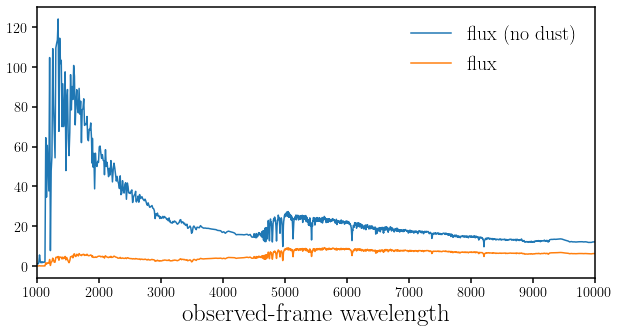

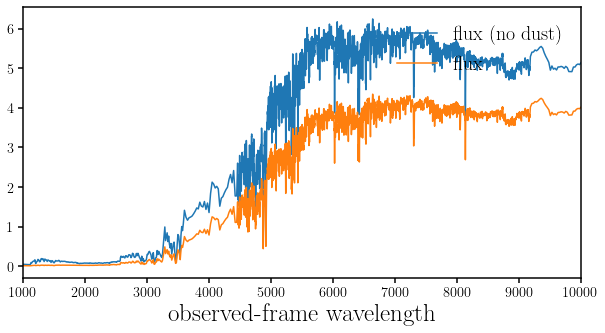

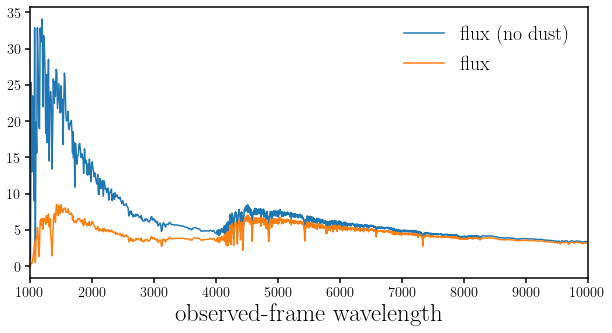

In [17]:
for i in np.random.choice(np.arange(np.sum(bgs_cut)), 3): 
    fig = plt.figure(figsize=(10, 5))
    sub = fig.add_subplot(111)
    sub.plot(waves_obs[i], fluxes_nodust[i].to(1e-17*U.erg/U.s/U.AA/U.cm**2), label='flux (no dust)')
    sub.plot(waves_obs[i], fluxes_dust[i].to(1e-17*U.erg/U.s/U.AA/U.cm**2), label='flux')
    sub.legend(loc='upper right', fontsize=20)
    sub.set_xlabel('observed-frame wavelength', fontsize=25)
    sub.set_xlim(1e3, 1e4)

In [18]:
mags_desi_nodust = np.array([get_mags_desi(w, f) for w, f in zip(waves_obs, fluxes_nodust)])
mags_sdss_nodust = np.array([get_mags_sdss(w, f) for w, f in zip(waves_obs, fluxes_nodust)])

mags_desi_dust = np.array([get_mags_desi(w, f) for w, f in zip(waves_obs, fluxes_dust)])
mags_sdss_dust = np.array([get_mags_sdss(w, f) for w, f in zip(waves_obs, fluxes_dust)])

(0.0, 1.5)

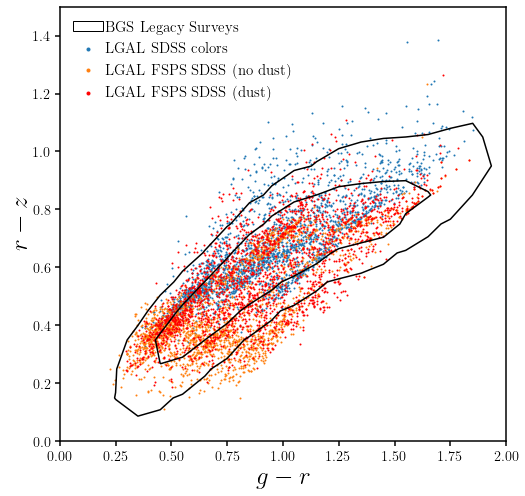

In [19]:
fig = plt.figure(figsize=(8,8))
sub = fig.add_subplot(111)
dfm.hist2d(g_bgs - r_bgs, r_bgs - z_bgs, color='k', levels=[0.68, 0.95], 
           range=[[-1., 3.], [-1., 3.]], bins=40, smooth=0.5,             
           plot_datapoints=False, fill_contours=False, plot_density=False, linewidth=0.5, ax=sub)
sub.fill_between([0],[0],[0], fc='none', ec='k', label='BGS Legacy Surveys') 
sub.scatter((lgal.sdss_g - lgal.sdss_r)[bgs_cut], (lgal.sdss_r - lgal.sdss_z)[bgs_cut], c='C0', s=1, label='LGAL SDSS colors')
sub.scatter(mags_sdss_nodust[:,1] - mags_sdss_nodust[:,2], mags_sdss_nodust[:,2] - mags_sdss_nodust[:,4], c='C1', s=1, label='LGAL FSPS SDSS (no dust)')
sub.scatter(mags_sdss_dust[:,1] - mags_sdss_dust[:,2], mags_sdss_dust[:,2] - mags_sdss_dust[:,4], c='r', s=1, label='LGAL FSPS SDSS (dust)')

sub.legend(loc='upper left', handletextpad=0.1, markerscale=3, fontsize=15)
sub.set_xlabel('$g-r$', fontsize=25)
sub.set_xlim(0., 2.)
sub.set_ylabel('$r-z$', fontsize=25)
sub.set_ylim(0., 1.5)

(0.0, 1.5)

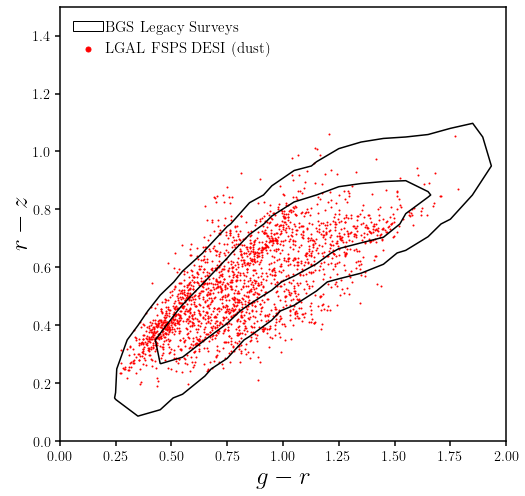

In [20]:
fig = plt.figure(figsize=(8,8))
sub = fig.add_subplot(111)
dfm.hist2d(g_bgs - r_bgs, r_bgs - z_bgs, color='k', levels=[0.68, 0.95], 
           range=[[-1., 3.], [-1., 3.]], bins=40, smooth=0.5,             
           plot_datapoints=False, fill_contours=False, plot_density=False, linewidth=0.5, ax=sub)
sub.fill_between([0],[0],[0], fc='none', ec='k', label='BGS Legacy Surveys') 
sub.scatter(mags_desi_dust[:,0] - mags_desi_dust[:,1], mags_desi_dust[:,1] - mags_desi_dust[:,2], c='r', s=1, label='LGAL FSPS DESI (dust)')

sub.legend(loc='upper left', handletextpad=0.1, markerscale=5, fontsize=15)
sub.set_xlabel('$g-r$', fontsize=25)
sub.set_xlim(0., 2.)
sub.set_ylabel('$r-z$', fontsize=25)
sub.set_ylim(0., 1.5)

In [24]:
iminis = np.sort(np.random.choice(mags_desi_dust.shape[0], size=100, replace=False))

(0.0, 1.5)

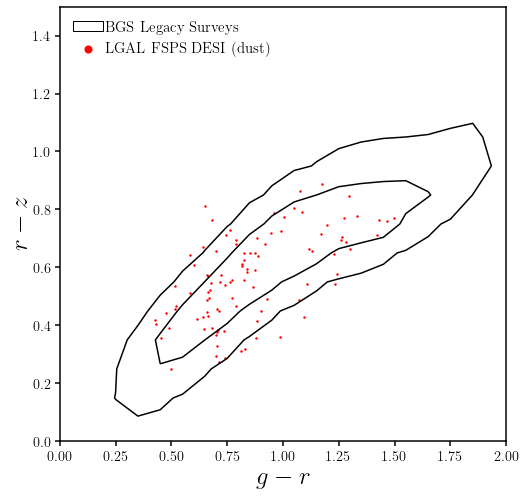

In [26]:
fig = plt.figure(figsize=(8,8))
sub = fig.add_subplot(111)
dfm.hist2d(g_bgs - r_bgs, r_bgs - z_bgs, color='k', levels=[0.68, 0.95], 
           range=[[-1., 3.], [-1., 3.]], bins=40, smooth=0.5,             
           plot_datapoints=False, fill_contours=False, plot_density=False, linewidth=0.5, ax=sub)
sub.fill_between([0],[0],[0], fc='none', ec='k', label='BGS Legacy Surveys') 
sub.scatter(mags_desi_dust[iminis,0] - mags_desi_dust[iminis,1], mags_desi_dust[iminis,1] - mags_desi_dust[iminis,2], c='r', s=2, label='LGAL FSPS DESI (dust)')

sub.legend(loc='upper left', handletextpad=0.1, markerscale=5, fontsize=15)
sub.set_xlabel('$g-r$', fontsize=25)
sub.set_xlim(0., 2.)
sub.set_ylabel('$r-z$', fontsize=25)
sub.set_ylim(0., 1.5)

In [31]:
pickle.dump(outdict, open(os.path.join(dat_dir, 'Lgal_fsps_mocha.p'), 'wb'))

In [37]:
outdict_mini = {}
for k in outdict.keys(): 
    outdict_mini[k] = [outdict[k][ii] for ii in iminis]

In [39]:
pickle.dump(outdict_mini, open(os.path.join(dat_dir, 'Lgal_fsps_minimocha.p'), 'wb'))